In [1]:
# Specify the directory where  to save the plots
import os
#plot_save_path="C:\\Users\\Jose Luis\\Desktop\\Plots"

#plot_save_path="C:\\Users\\e410675\\OneDrive - London South Bank University\\Desktop\\Plots"

plot_save_path = "/Users/e410675/Desktop/Plots"



In [2]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('chppd-smhi_merged filter with year month.csv')

# Display the first few rows of the dataframe
df

Organisation Name  \
0                         Airedale NHS Foundation Trust   
1                         Airedale NHS Foundation Trust   
2                         Airedale NHS Foundation Trust   
3                         Airedale NHS Foundation Trust   
4                         Airedale NHS Foundation Trust   
...                                                 ...   
6190  York And Scarborough Teaching Hospitals NHS Fo...   
6191  York And Scarborough Teaching Hospitals NHS Fo...   
6192  York And Scarborough Teaching Hospitals NHS Fo...   
6193  York And Scarborough Teaching Hospitals NHS Fo...   
6194  York And Scarborough Teaching Hospitals NHS Fo...   

      CHPPD – Registered Nurses and Midwives  Non-registered Nurses  \
0                                       4.83                   5.18   
1                                       4.60                   4.76   
2                                       4.71                   4.65   
3                                       4.91                   4.71   
4                                       5.10                   5.04   
...                                      ...                    ...   
6190                                    4.10                   3.44   
6191                                    4.12                   3.41   
6192                                    4.12                   3.48   
6193                                    4.21                   3.48   
6194                                    4.14                   3.46   

      CHPPD - Overall year_month  SHMI_VALUE  
0               10.02    2020-12      0.9361  
1                9.36    2021-01      0.9375  
2                9.36    2021-02      0.9330  
3                9.62    2021-03      0.9245  
4               10.14    2021-04      0.9469  
...               ...        ...         ...  
6190             7.54    2025-02      0.9284  
6191             7.53    2025-03      0.9314  
6192             7.60    2025-04      0.9274  
6193             7.69    2025-05      0.9219  
6194             7.60    2025-06      0.9220  

[6195 rows x 6 columns]

### Remove outliers where CHPPD - Overall > 17

In [3]:
"""# Assuming your DataFrame is named df
# Set the 'year_month' column as the index
df.set_index('year_month', inplace=True)

# Sort the DataFrame by the index
df = df.sort_index()

df """

"# Assuming your DataFrame is named df\n# Set the 'year_month' column as the index\ndf.set_index('year_month', inplace=True)\n\n# Sort the DataFrame by the index\ndf = df.sort_index()\n\ndf "

Removed 22 outlier rows.
Saved to: /Users/e410675/Desktop/Plots/A1_CHPPD_SHMI_LowCHPPD_HighSHMI_2025_06.png


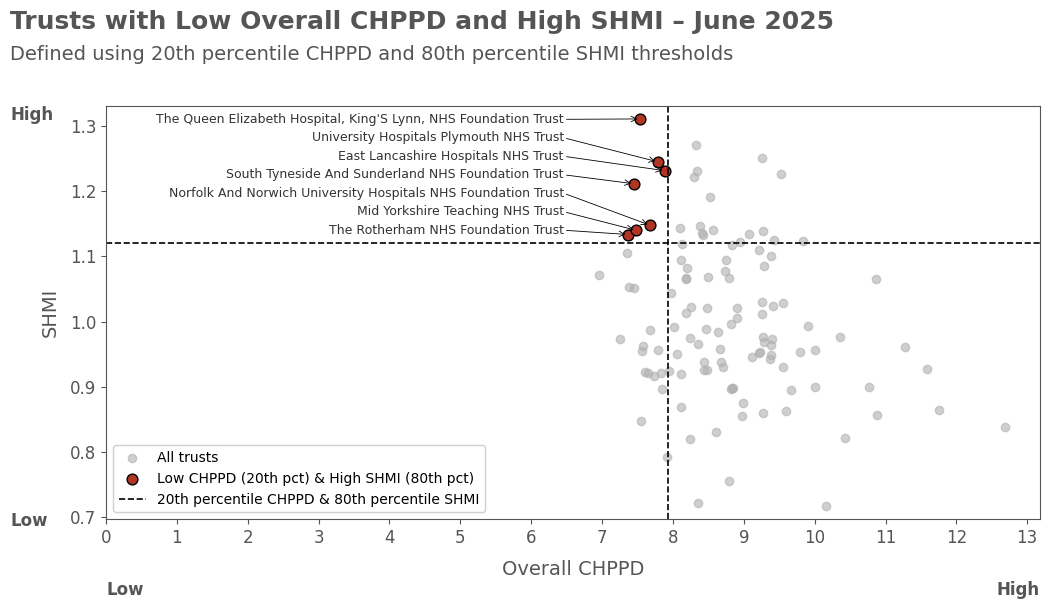

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os   # for saving
from matplotlib.ticker import MultipleLocator
import matplotlib.lines as mlines

# -----------------------------
# Styling constants (AfC-style)
# -----------------------------
YEAR_LABEL_GRAY = "#555555"

# -----------------------------
# Load and prepare the data
# -----------------------------
file_path = "chppd-smhi_merged filter with year month.csv"
df = pd.read_csv(file_path)

# Remove outliers where CHPPD - Overall > 16
df_clean = df[df["CHPPD - Overall"] <= 16].copy()
removed = len(df) - len(df_clean)
print(f"Removed {removed} outlier rows.")

df = df_clean.copy()

# Rename columns to simpler names
df = df.rename(columns={
    "Organisation Name": "org_name",
    "CHPPD - Overall": "overall_chppd",
    "SHMI_VALUE": "shmi",
    "year_month": "date"
})

# Parse year_month as datetime (YYYY-MM)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

# -----------------------------
# Keep only the latest month
# -----------------------------
latest_date = df["date"].max()
df_latest = df[df["date"] == latest_date].copy()

# -----------------------------
# Define thresholds (20th / 80th percentiles)
# -----------------------------
low_chppd_thresh = df_latest["overall_chppd"].quantile(0.20)   # 20th percentile
high_shmi_thresh = df_latest["shmi"].quantile(0.80)            # 80th percentile

# Standout trusts = low CHPPD + high SHMI
mask_standout = (
    (df_latest["overall_chppd"] <= low_chppd_thresh) &
    (df_latest["shmi"] >= high_shmi_thresh)
)
df_standout = df_latest[mask_standout].copy()

# Sort standout trusts by SHMI (for label ordering)
df_standout = df_standout.sort_values("shmi").reset_index(drop=True)

# -------------------------------------------
# Optional: swap two specific trusts in label order (if present)
# -------------------------------------------
trust_a = "East Suffolk And North Essex NHS Foundation Trust"
trust_b = "South Tyneside And Sunderland NHS Foundation Trust"

idx_a = df_standout.index[df_standout["org_name"] == trust_a]
idx_b = df_standout.index[df_standout["org_name"] == trust_b]

if len(idx_a) == 1 and len(idx_b) == 1:
    ia = idx_a[0]
    ib = idx_b[0]
    df_standout.iloc[[ia, ib]] = df_standout.iloc[[ib, ia]]

# -----------------------------
# Define the vertical label band (ONLY for standout trusts)
# Place labels between SHMI 1.14 and 1.31
# -----------------------------
n_labels = len(df_standout)
label_band_min = 1.14
label_band_max = 1.31

if n_labels > 1:
    label_y_values = np.linspace(label_band_min, label_band_max, n_labels)
elif n_labels == 1:
    label_y_values = np.array([(label_band_min + label_band_max) / 2])
else:
    label_y_values = np.array([])

# -----------------------------
# Axis span
# -----------------------------
x_min_data = df_latest["overall_chppd"].min()
x_max_data = df_latest["overall_chppd"].max()
y_min_data = df_latest["shmi"].min()
y_max_data = df_latest["shmi"].max()

# Horizontal offset for text to the left of the point
x_offset = 1.8
margin_x = 0.5
margin_y = 0.02

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 7))
fig.patch.set_facecolor("white")

# Colors
grey_color = "#b0b0b0"
red_color = "#b23524"

# All trusts (grey points)
all_scatter = ax.scatter(
    df_latest["overall_chppd"],
    df_latest["shmi"],
    alpha=0.6,
    color=grey_color,
    label="All trusts"
)

# Standout trusts (red points with black outline)
standout_scatter = ax.scatter(
    df_standout["overall_chppd"],
    df_standout["shmi"],
    s=60,
    color=red_color,
    edgecolor="black",
    label="Low CHPPD (20th pct) & High SHMI (80th pct)"
)

# -----------------------------
# Add labels ONLY for standout trusts
# -----------------------------
for i, row in df_standout.iterrows():
    x = row["overall_chppd"]
    y = row["shmi"]
    label_y = float(label_y_values[i])

    # Text position: shifted left by x_offset, but not beyond the minimum x minus margin_x
    x_text_raw = x - x_offset
    x_text = max(x_min_data - margin_x, x_text_raw)

    # Trust name label
    ax.text(
        x_text,
        label_y,
        row["org_name"],
        fontsize=9,
        ha="right",
        va="center",
        color="#333333"
    )

    # Arrow from label to the actual point
    ax.annotate(
        "",
        xy=(x, y),
        xytext=(x_text, label_y),
        arrowprops=dict(
            arrowstyle="->",
            lw=0.6,
            color="black"
        )
    )

# -----------------------------
# Threshold lines (black dashed)
# -----------------------------
vline = ax.axvline(
    low_chppd_thresh,
    linestyle="--",
    linewidth=1.2,
    alpha=1.0,
    color="black"
)
hline = ax.axhline(
    high_shmi_thresh,
    linestyle="--",
    linewidth=1.2,
    alpha=1.0,
    color="black"
)

# -----------------------------
# Axis limits (CHPPD starts at 0)
# -----------------------------
ax.set_xlim(0, x_max_data + 0.5)
ax.set_ylim(
    min(y_min_data, label_band_min) - margin_y,
    max(y_max_data, label_band_max) + margin_y
)

# -----------------------------
# Axes labels & ticks
# -----------------------------
ax.set_xlabel("Overall CHPPD", color=YEAR_LABEL_GRAY, fontsize=14)
ax.xaxis.set_label_coords(0.5, -0.10)

ax.set_ylabel("")
ax.tick_params(axis="x", labelsize=12, colors=YEAR_LABEL_GRAY)
ax.tick_params(axis="y", labelsize=12, colors=YEAR_LABEL_GRAY)

# Tick locations (but NO grids)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

# -----------------------------
# REMOVE ALL GRIDLINES (keep only dashed thresholds)
# -----------------------------
ax.grid(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.minorticks_off()   # remove minor ticks completely (optional)

# -----------------------------
# Spines
# -----------------------------
for side in ["top", "right", "left", "bottom"]:
    ax.spines[side].set_visible(True)
    ax.spines[side].set_color(YEAR_LABEL_GRAY)

# -----------------------------
# Title & subtitle
# -----------------------------
main_title = f"Trusts with Low Overall CHPPD and High SHMI – {latest_date.strftime('%B %Y')}"
subtitle = "Defined using 20th percentile CHPPD and 80th percentile SHMI thresholds"

fig.suptitle(
    main_title,
    x=0.03,
    y=0.96,
    ha="left",
    fontsize=18,
    fontweight="bold",
    color=YEAR_LABEL_GRAY,
)

fig.text(
    0.03,
    0.91,
    subtitle,
    ha="left",
    va="top",
    fontsize=14,
    color=YEAR_LABEL_GRAY,
)

# -----------------------------
# Left sidebar: High / Low SHMI labels
# -----------------------------
fig.text(
    0.03,
    0.81,
    "High",
    ha="left",
    va="center",
    fontsize=12,
    fontweight="bold",
    color=YEAR_LABEL_GRAY,
)

fig.text(
    0.03,
    0.23,
    "Low",
    ha="left",
    va="center",
    fontsize=12,
    fontweight="bold",
    color=YEAR_LABEL_GRAY,
)

# -----------------------------
# SHMI label (fixed next to Y-axis)
# -----------------------------
ax.text(
    -0.06,           # a little to the left of the Y-axis
    0.5,             # middle of the axis
    "SHMI",
    transform=ax.transAxes,
    rotation=90,
    ha="center",
    va="center",
    fontsize=14,
    color=YEAR_LABEL_GRAY,
)

# -----------------------------
# Low / High labels under x-axis (CHPPD)
# -----------------------------
ax.text(
    0.0,
    -0.15,
    "Low",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=12,
    fontweight="bold",
    color=YEAR_LABEL_GRAY,
)

ax.text(
    1.0,
    -0.15,
    "High",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=12,
    fontweight="bold",
    color=YEAR_LABEL_GRAY,
)

# -----------------------------
# Legend (single dashed entry for both thresholds)
# -----------------------------
thresholds_legend = mlines.Line2D(
    [], [], color='black', linestyle='--', linewidth=1.2,
    label='20th percentile CHPPD & 80th percentile SHMI'
)

ax.legend(
    handles=[all_scatter, standout_scatter, thresholds_legend],
    loc="lower left",
    bbox_to_anchor=(0, 0.00),
    frameon=True,
    facecolor="#FFFFFF",
    edgecolor="#d0d0d0",
    framealpha=1.0,
)

# -----------------------------
# Layout
# -----------------------------
fig.subplots_adjust(left=0.15)
plt.tight_layout(rect=[0.05, 0.07, 0.98, 0.9])

# -----------------------------
# Save plot (AfC-style)
# -----------------------------
os.makedirs(plot_save_path, exist_ok=True)

month_str = latest_date.strftime("%Y_%m")
filename = f"A1_CHPPD_SHMI_LowCHPPD_HighSHMI_{month_str}.png"
save_path = os.path.join(plot_save_path, filename)

plt.savefig(save_path, bbox_inches="tight", dpi=300)
print(f"Saved to: {save_path}")

# -----------------------------
# Show
# -----------------------------
plt.show()



Latest month in data: 2025-06 (115 rows)
Saved to: /Users/e410675/Desktop/Plots/AA1_RNMid_CHPPD_SHMI_LowCHPPD_HighSHMI_2025_06.png


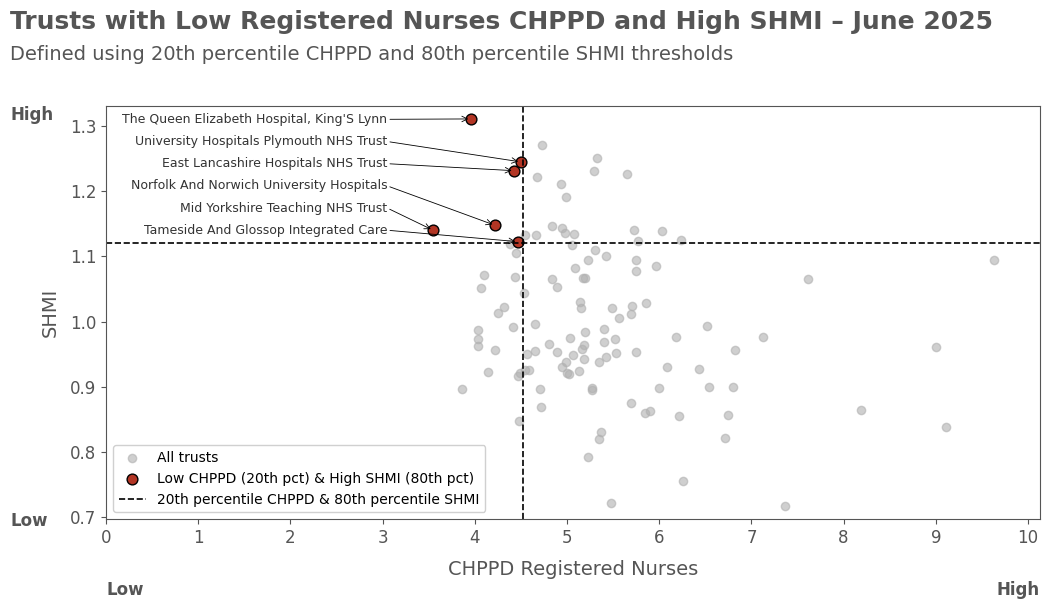

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os   # for saving
from matplotlib.ticker import MultipleLocator
import matplotlib.lines as mlines

# -----------------------------
# Styling constants (AfC-style)
# -----------------------------
YEAR_LABEL_GRAY = "#555555"

# -----------------------------
# Load and prepare the data
# -----------------------------
file_path = "chppd-smhi_merged filter with year month.csv"
df = pd.read_csv(file_path)

# -----------------------------
# Rename columns to simpler names
# -----------------------------
df = df.rename(columns={
    "Organisation Name": "org_name",
    "CHPPD – Registered Nurses and Midwives": "rnmid_chppd",
    "SHMI_VALUE": "shmi",
    "year_month": "date"
})

# Parse year_month as datetime (YYYY-MM)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

# -----------------------------
# Keep only the latest month
# -----------------------------
latest_date = df["date"].max()
df_latest = df[df["date"] == latest_date].copy()
print(f"Latest month in data: {latest_date.strftime('%Y-%m')} "
      f"({len(df_latest)} rows)")

# -----------------------------
# Define thresholds (20th / 80th percentiles)
# -----------------------------
low_chppd_thresh = df_latest["rnmid_chppd"].quantile(0.20)
high_shmi_thresh = df_latest["shmi"].quantile(0.80)

mask_standout = (
    (df_latest["rnmid_chppd"] <= low_chppd_thresh) &
    (df_latest["shmi"] >= high_shmi_thresh)
)
df_standout = df_latest[mask_standout].copy()

df_standout = df_standout.sort_values("shmi").reset_index(drop=True)

# -----------------------------
# Optional: swap two specific trusts in label order
# -----------------------------
trust_a = "East Suffolk And North Essex NHS Foundation Trust"
trust_b = "South Tyneside And Sunderland NHS Foundation Trust"

idx_a = df_standout.index[df_standout["org_name"] == trust_a]
idx_b = df_standout.index[df_standout["org_name"] == trust_b]

if len(idx_a) == 1 and len(idx_b) == 1:
    ia = idx_a[0]
    ib = idx_b[0]
    df_standout.iloc[[ia, ib]] = df_standout.iloc[[ib, ia]]

# -----------------------------
# Label band for standout trusts
# -----------------------------
n_labels = len(df_standout)
label_band_min = 1.14
label_band_max = 1.31

if n_labels > 1:
    label_y_values = np.linspace(label_band_min, label_band_max, n_labels)
elif n_labels == 1:
    label_y_values = np.array([(label_band_min + label_band_max)/2])
else:
    label_y_values = np.array([])

# -----------------------------
# Axis span
# -----------------------------
x_min_data = df_latest["rnmid_chppd"].min()
x_max_data = df_latest["rnmid_chppd"].max()
y_min_data = df_latest["shmi"].min()
y_max_data = df_latest["shmi"].max()

x_offset = 1.8
margin_x = 0.5
margin_y = 0.02

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 7))
fig.patch.set_facecolor("white")

grey_color = "#b0b0b0"
red_color = "#b23524"

# All trusts
all_scatter = ax.scatter(
    df_latest["rnmid_chppd"],
    df_latest["shmi"],
    alpha=0.6,
    color=grey_color,
    label="All trusts"
)

# Standout trusts
standout_scatter = ax.scatter(
    df_standout["rnmid_chppd"],
    df_standout["shmi"],
    s=60,
    color=red_color,
    edgecolor="black",
    label="Low CHPPD (20th pct) & High SHMI (80th pct)"
)

# -----------------------------
# Add label cleanup + annotations
# -----------------------------
for i, row in df_standout.iterrows():
    x = row["rnmid_chppd"]
    y = row["shmi"]
    label_y = float(label_y_values[i])

    # --- CLEAN LABEL TEXT ---
    label_text = row["org_name"]

    # Tameside → ficar como "Integrated Care"
    label_text = label_text.replace(
        "Integrated Care NHS Foundation Trust",
        "Integrated Care"
    )

    # Remover NHS Foundation Trust do resto
    label_text = label_text.replace("NHS Foundation Trust", "")
    label_text = label_text.rstrip(", ").strip()

    # Position text
    x_text_raw = x - x_offset
    x_text = max(x_min_data - margin_x, x_text_raw)

    ax.text(
        x_text,
        label_y,
        label_text,
        fontsize=9,
        ha="right",
        va="center",
        color="#333333"
    )

    ax.annotate(
        "",
        xy=(x, y),
        xytext=(x_text, label_y),
        arrowprops=dict(arrowstyle="->", lw=0.6, color="black")
    )

# -----------------------------
# Threshold lines
# -----------------------------
vline = ax.axvline(low_chppd_thresh, linestyle="--", linewidth=1.2, color="black")
hline = ax.axhline(high_shmi_thresh, linestyle="--", linewidth=1.2, color="black")

# -----------------------------
# Axis limits
# -----------------------------
ax.set_xlim(0, x_max_data + 0.5)
ax.set_ylim(min(y_min_data, label_band_min)-margin_y,
            max(y_max_data, label_band_max)+margin_y)

# -----------------------------
# Axis styling
# -----------------------------
ax.set_xlabel("CHPPD Registered Nurses",
              color=YEAR_LABEL_GRAY, fontsize=14)
ax.xaxis.set_label_coords(0.5, -0.10)
ax.set_ylabel("")
ax.tick_params(axis="x", labelsize=12, colors=YEAR_LABEL_GRAY)
ax.tick_params(axis="y", labelsize=12, colors=YEAR_LABEL_GRAY)

ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.grid(False)
ax.minorticks_off()

for side in ["top", "right", "left", "bottom"]:
    ax.spines[side].set_visible(True)
    ax.spines[side].set_color(YEAR_LABEL_GRAY)

# -----------------------------
# Titles
# -----------------------------
main_title = f"Trusts with Low Registered Nurses CHPPD and High SHMI – {latest_date.strftime('%B %Y')}"
subtitle = "Defined using 20th percentile CHPPD and 80th percentile SHMI thresholds"

fig.suptitle(
    main_title,
    x=0.03,
    y=0.96,
    ha="left",
    fontsize=18,
    fontweight="bold",
    color=YEAR_LABEL_GRAY,
)

fig.text(
    0.03,
    0.91,
    subtitle,
    ha="left",
    va="top",
    fontsize=14,
    color=YEAR_LABEL_GRAY,
)

# -----------------------------
# Side labels (High / Low SHMI)
# -----------------------------
fig.text(0.03, 0.81, "High",
         ha="left", va="center",
         fontsize=12, fontweight="bold",
         color=YEAR_LABEL_GRAY)

fig.text(0.03, 0.23, "Low",
         ha="left", va="center",
         fontsize=12, fontweight="bold",
         color=YEAR_LABEL_GRAY)

# SHMI label next to axis
ax.text(
    -0.06, 0.5, "SHMI",
    transform=ax.transAxes,
    rotation=90,
    ha="center",
    va="center",
    fontsize=14,
    color=YEAR_LABEL_GRAY,
)

# Low / High under x-axis
ax.text(
    0.0, -0.15, "Low",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12, fontweight="bold",
    color=YEAR_LABEL_GRAY,
)

ax.text(
    1.0, -0.15, "High",
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=12, fontweight="bold",
    color=YEAR_LABEL_GRAY,
)

# -----------------------------
# Legend
# -----------------------------
thresholds_legend = mlines.Line2D(
    [], [], color='black', linestyle='--', linewidth=1.2,
    label='20th percentile CHPPD & 80th percentile SHMI'
)

ax.legend(
    handles=[all_scatter, standout_scatter, thresholds_legend],
    loc="lower left",
    bbox_to_anchor=(0, 0.00),
    frameon=True,
    facecolor="#FFFFFF",
    edgecolor="#d0d0d0",
    framealpha=1.0,
)

# -----------------------------
# Layout
# -----------------------------
fig.subplots_adjust(left=0.15)
plt.tight_layout(rect=[0.05, 0.07, 0.98, 0.9])


# -----------------------------
# Save plot (AfC-style)
# -----------------------------
os.makedirs(plot_save_path, exist_ok=True)

month_str = latest_date.strftime("%Y_%m")
filename = f"AA1_RNMid_CHPPD_SHMI_LowCHPPD_HighSHMI_{month_str}.png"
save_path = os.path.join(plot_save_path, filename)

plt.savefig(save_path, bbox_inches="tight", dpi=300)
print(f"Saved to: {save_path}")

plt.show()


Removed 22 outlier rows.
Latest month in data: 2025-06 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHealthcareWorkers_CHPPD_SHMI_LowCHPPD_HighSHMI_2025_06.png


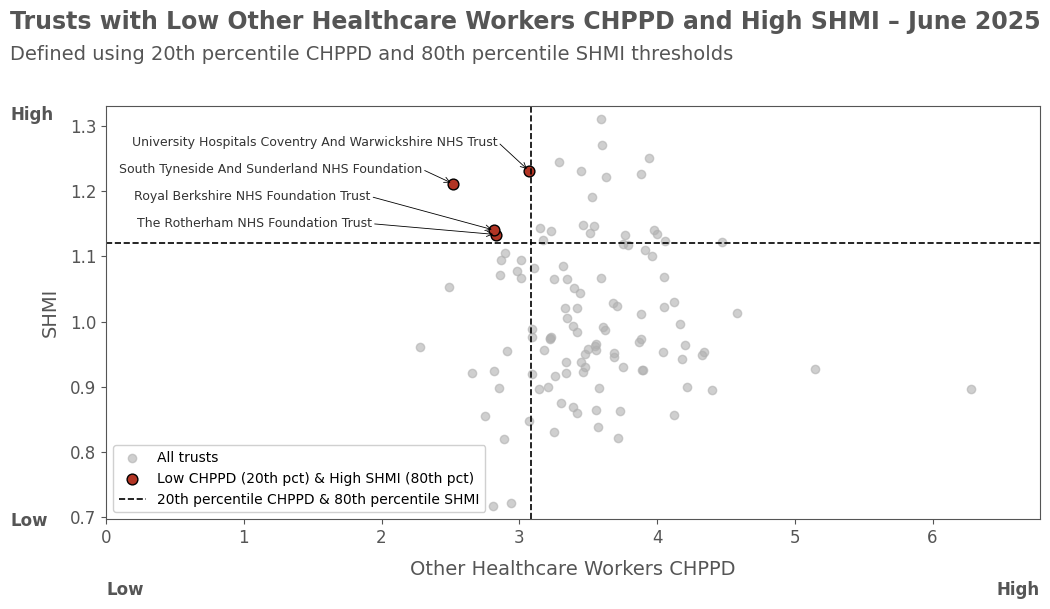

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os   # for saving
from matplotlib.ticker import MultipleLocator
import matplotlib.lines as mlines

# -----------------------------
# Styling constants (AfC-style)
# -----------------------------
YEAR_LABEL_GRAY = "#555555"

# -----------------------------
# Load and prepare the data
# -----------------------------
file_path = "chppd-smhi_merged filter with year month.csv"
df = pd.read_csv(file_path)

# Remove outliers where Overall CHPPD > 16
df_clean = df[df["CHPPD - Overall"] <= 16].copy()
removed = len(df) - len(df_clean)
print(f"Removed {removed} outlier rows.")

df = df_clean.copy()

# Rename columns
df = df.rename(columns={
    "Organisation Name": "org_name",
    "CHPPD - Overall": "overall_chppd",
    "Non-registered Nurses": "nonreg_chppd",
    "SHMI_VALUE": "shmi",
    "year_month": "date"
})

# Parse year_month as datetime (YYYY-MM)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

# -----------------------------
# Keep only the latest month
# -----------------------------
latest_date = df["date"].max()
df_latest = df[df["date"] == latest_date].copy()

print(
    f"Latest month in data: {latest_date.strftime('%Y-%m')} "
    f"({len(df_latest)} rows)"
)

# -----------------------------
# Define thresholds (20th / 80th percentiles)
# -----------------------------
low_nonreg_thresh = df_latest["nonreg_chppd"].quantile(0.20)
high_shmi_thresh = df_latest["shmi"].quantile(0.80)

mask_standout = (
    (df_latest["nonreg_chppd"] <= low_nonreg_thresh) &
    (df_latest["shmi"] >= high_shmi_thresh)
)

df_standout = df_latest[mask_standout].copy()
df_standout = df_standout.sort_values("shmi").reset_index(drop=True)

# -----------------------------
# Label band (UPDATED RANGE)
# -----------------------------
n_labels = len(df_standout)
label_band_min = 1.15   # <--- updated
label_band_max = 1.275  # <--- updated

if n_labels > 1:
    label_y_values = np.linspace(label_band_min, label_band_max, n_labels)
elif n_labels == 1:
    label_y_values = np.array([(label_band_min + label_band_max) / 2])
else:
    label_y_values = np.array([])

# -----------------------------
# Axis span
# -----------------------------
x_min_data = df_latest["nonreg_chppd"].min()
x_max_data = df_latest["nonreg_chppd"].max()
y_min_data = df_latest["shmi"].min()
y_max_data = df_latest["shmi"].max()

# Half arrow length
x_offset = 0.9
margin_x = 0.5
margin_y = 0.02

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 7))
fig.patch.set_facecolor("white")

grey_color = "#b0b0b0"
red_color = "#b23524"

# All trusts
all_scatter = ax.scatter(
    df_latest["nonreg_chppd"], df_latest["shmi"],
    alpha=0.6, color=grey_color, label="All trusts"
)

# Standout trusts
standout_scatter = ax.scatter(
    df_standout["nonreg_chppd"], df_standout["shmi"],
    s=60, color=red_color, edgecolor="black",
    label="Low CHPPD (20th pct) & High SHMI (80th pct)"
)

# -----------------------------
# Annotations
# -----------------------------
for i, row in df_standout.iterrows():
    x = row["nonreg_chppd"]
    y = row["shmi"]
    label_y = float(label_y_values[i])

    trust_name = row["org_name"]
    trust_lower = trust_name.lower()

    # Coventry: remove long suffix
    if "coventry" in trust_lower:
        trust_name = trust_name.replace("NHS Foundation Trust", "")
        trust_name = trust_name.replace("Foundation Trust", "")
        trust_name = trust_name.strip()

    # South Tyneside: remove "Trust"
    if "south tyneside" in trust_lower:
        trust_name = trust_name.replace(" Trust", "")
        trust_name = trust_name.replace(" trust", "")
        trust_name = trust_name.strip()

    # Default = half arrow; for Coventry & South Tyneside reduce more
    local_offset = x_offset
    if ("Coventry" in row["org_name"]) or ("South Tyneside" in row["org_name"]):
        local_offset = x_offset * 0.25

    x_text_raw = x - local_offset
    x_text = max(x_min_data - margin_x, x_text_raw)

    ax.text(
        x_text, label_y, trust_name,
        fontsize=9, ha="right", va="center", color="#333333"
    )

    ax.annotate(
        "", xy=(x, y), xytext=(x_text, label_y),
        arrowprops=dict(arrowstyle="->", lw=0.6, color="black")
    )

# -----------------------------
# Threshold lines
# -----------------------------
vline = ax.axvline(low_nonreg_thresh, linestyle="--", linewidth=1.2, color="black")
hline = ax.axhline(high_shmi_thresh, linestyle="--", linewidth=1.2, color="black")

# -----------------------------
# Axis limits
# -----------------------------
ax.set_xlim(0, x_max_data + 0.5)
ax.set_ylim(
    min(y_min_data, label_band_min) - margin_y,
    max(y_max_data, label_band_max) + margin_y
)

# -----------------------------
# Axis styling
# -----------------------------
ax.set_xlabel(
    "Other Healthcare Workers CHPPD",
    color=YEAR_LABEL_GRAY, fontsize=14
)
ax.xaxis.set_label_coords(0.5, -0.10)

ax.set_ylabel("")
ax.tick_params(axis="x", labelsize=12, colors=YEAR_LABEL_GRAY)
ax.tick_params(axis="y", labelsize=12, colors=YEAR_LABEL_GRAY)

ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.grid(False)
ax.minorticks_off()

for side in ["top", "right", "left", "bottom"]:
    ax.spines[side].set_visible(True)
    ax.spines[side].set_color(YEAR_LABEL_GRAY)

# -----------------------------
# Titles
# -----------------------------
main_title = (
    f"Trusts with Low Other Healthcare Workers CHPPD and High SHMI – "
    f"{latest_date.strftime('%B %Y')}"
)

subtitle = (
    "Defined using 20th percentile CHPPD "
    "and 80th percentile SHMI thresholds"
)

fig.suptitle(
    main_title, x=0.03, y=0.96,
    ha="left", fontsize=17, fontweight="bold", color=YEAR_LABEL_GRAY
)

fig.text(
    0.03, 0.91, subtitle,
    ha="left", va="top", fontsize=14, color=YEAR_LABEL_GRAY
)

# -----------------------------
# Side labels
# -----------------------------
fig.text(0.03, 0.81, "High", ha="left", va="center",
         fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY)
fig.text(0.03, 0.23, "Low", ha="left", va="center",
         fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY)

# SHMI vertical label
ax.text(
    -0.06, 0.5, "SHMI",
    transform=ax.transAxes,
    rotation=90, ha="center", va="center",
    fontsize=14, color=YEAR_LABEL_GRAY,
)

# Low / High under x-axis
ax.text(
    0.0, -0.15, "Low",
    transform=ax.transAxes, ha="left", va="top",
    fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY,
)
ax.text(
    1.0, -0.15, "High",
    transform=ax.transAxes, ha="right", va="top",
    fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY,
)

# -----------------------------
# Legend
# -----------------------------
thresholds_legend = mlines.Line2D(
    [], [], color='black', linestyle='--', linewidth=1.2,
    label='20th percentile CHPPD & 80th percentile SHMI'
)

ax.legend(
    handles=[all_scatter, standout_scatter, thresholds_legend],
    loc="lower left", bbox_to_anchor=(0, 0.00),
    frameon=True, facecolor="#FFFFFF",
    edgecolor="#d0d0d0", framealpha=1.0,
)

# -----------------------------
# Layout
# -----------------------------
fig.subplots_adjust(left=0.15)
plt.tight_layout(rect=[0.05, 0.07, 0.98, 0.9])


# -----------------------------
# Save plot (AfC-style)
# -----------------------------
os.makedirs(plot_save_path, exist_ok=True)

month_str = latest_date.strftime("%Y_%m")
filename = f"B1_OtherHealthcareWorkers_CHPPD_SHMI_LowCHPPD_HighSHMI_{month_str}.png"
save_path = os.path.join(plot_save_path, filename)

plt.savefig(save_path, bbox_inches="tight", dpi=300)
print(f"Saved to: {save_path}")




plt.show()


Saved to: /Users/e410675/Desktop/Plots/CHPPD_RN_distribution_2025_06.png


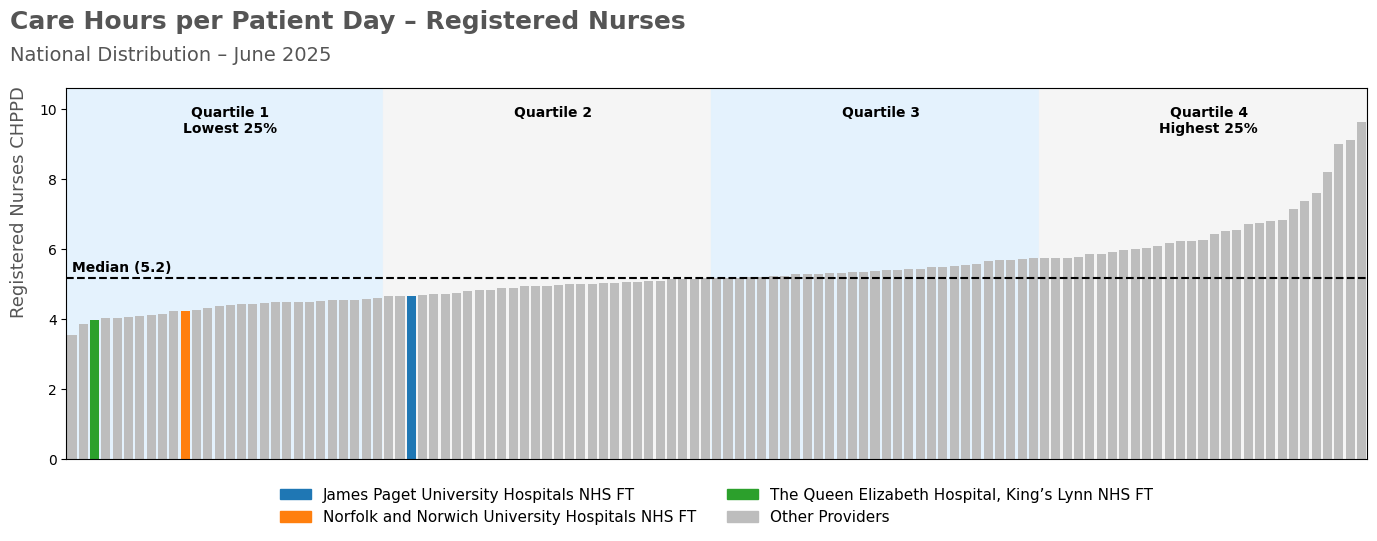

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os   # para guardar o ficheiro

# -----------------------------
# Styling
# -----------------------------
YEAR_LABEL_GRAY = "#555555"   # mesmo cinzento usado no outro plot

# -----------------------------
# Load and prepare the data
# -----------------------------
file_path = "chppd-smhi_merged filter with year month.csv"
df = pd.read_csv(file_path)

# Renomear colunas do ficheiro original para nomes mais simples
df = df.rename(columns={
    "Organisation Name": "org_name",
    "CHPPD – Registered Nurses and Midwives": "rnmid_chppd",
    "Non-registered Nurses": "nonreg_chppd",
    "CHPPD - Overall": "overall_chppd",
    "SHMI_VALUE": "shmi",
    "year_month": "date"
})

# Converter a coluna de data
df["date"] = pd.to_datetime(df["date"])

# -----------------------------
# Latest month only
# -----------------------------
latest_month = df["date"].max()
df_latest = df[df["date"] == latest_month]

month_year_str = latest_month.strftime("%B %Y")

metric = "rnmid_chppd"

# Sorted values
trust_values = (
    df_latest.groupby("org_name")[metric]
    .mean()
    .sort_values(ascending=True)
)

# -----------------------------
# Basic setup
# -----------------------------
n = len(trust_values)
x = range(n)
y = trust_values.values

fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor("white")

# Quartile boundaries
q1 = int(0.25 * n)
q2 = int(0.50 * n)
q3 = int(0.75 * n)

y_lim_top = y.max() * 1.05

# -----------------------------
# Quartile soft shading (menos saturado ~5%)
# -----------------------------
color_A = "#E3F2FD"
color_B = "#F5F5F5"

ax.axvspan(-0.5, q1 - 0.5, color=color_A, alpha=0.95, zorder=1)
ax.axvspan(q1 - 0.5, q2 - 0.5, color=color_B, alpha=0.95, zorder=1)
ax.axvspan(q2 - 0.5, q3 - 0.5, color=color_A, alpha=0.95, zorder=1)
ax.axvspan(q3 - 0.5, n - 0.5, color=color_B, alpha=0.95, zorder=1)

# -----------------------------
# Color palette (TAB10)
# -----------------------------
tab10 = plt.cm.tab10

color_jpaget = tab10(0)    # blue
color_nnuht  = tab10(1)    # orange
color_qeh    = tab10(2)    # green
other_color  = "#BDBDBD"   # grey

highlight_map = {
    "James Paget University Hospitals NHS Foundation Trust": color_jpaget,
    "Norfolk And Norwich University Hospitals NHS Foundation Trust": color_nnuht,
    "The Queen Elizabeth Hospital, King'S Lynn, NHS Foundation Trust": color_qeh,
}

# Build colors
colors = [highlight_map.get(org, other_color) for org in trust_values.index]

# -----------------------------
# Bars
# -----------------------------
ax.bar(x, y, color=colors, zorder=2)
ax.set_xticks([])

# -----------------------------
# Quartile labels (em bold)
# -----------------------------
ax.text(q1/2, y_lim_top, "Quartile 1\nLowest 25%",
        ha="center", va="top", fontsize=10, fontweight="bold")
ax.text((q1+q2)/2, y_lim_top, "Quartile 2",
        ha="center", va="top", fontsize=10, fontweight="bold")
ax.text((q2+q3)/2, y_lim_top, "Quartile 3",
        ha="center", va="top", fontsize=10, fontweight="bold")
ax.text((q3+n)/2, y_lim_top, "Quartile 4\nHighest 25%",
        ha="center", va="top", fontsize=10, fontweight="bold")

# -----------------------------
# Median line + label (em bold)
# -----------------------------
median_val = trust_values.median()
ax.axhline(median_val, linestyle="--", color="black", zorder=3)
ax.text(0, median_val + 0.1, f"Median ({median_val:.1f})",
        ha="left", va="bottom", zorder=3, fontweight="bold")

# -----------------------------
# Title (AfC style)
# -----------------------------
main_title = "Care Hours per Patient Day – Registered Nurses"
subtitle = f"National Distribution – {month_year_str}"

fig.suptitle(
    main_title,
    x=0.0, y=0.98, ha="left",
    fontsize=18, fontweight="bold", color=YEAR_LABEL_GRAY
)
fig.text(
    0.0, 0.92, subtitle,
    ha="left", va="top",
    fontsize=14, color=YEAR_LABEL_GRAY
)

# -----------------------------
# LEFT vertical y-label (AfC style)
# -----------------------------
fig.text(
    0.0, 0.66, "Registered Nurses CHPPD",
    rotation=90, va="center", ha="left",
    color=YEAR_LABEL_GRAY, fontsize=13
)

# -----------------------------
# Legend
# -----------------------------
handles = [
    mpatches.Patch(color=color_jpaget, label="James Paget University Hospitals NHS FT"),
    mpatches.Patch(color=color_nnuht, label="Norfolk and Norwich University Hospitals NHS FT"),
    mpatches.Patch(color=color_qeh, label="The Queen Elizabeth Hospital, King’s Lynn NHS FT"),
    mpatches.Patch(color=other_color, label="Other Providers"),
]

ax.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.04),
    ncol=2,
    frameon=False,
    fontsize=11
)

# -----------------------------
# REMOVE WHITE SPACE on left/right
# -----------------------------
ax.set_xlim(-0.5, n - 0.5)
ax.margins(x=0)

plt.ylim(top=y_lim_top * 1.05)

# deixar espaço para título e y-label à esquerda
plt.tight_layout(rect=[0.01, 0.08, 0.98, 0.94])

# -----------------------------
# Save plot (per month)
# -----------------------------
# assumo que já tens plot_save_path definido noutro sítio
month_str = latest_month.strftime("%Y_%m")
filename = f"CHPPD_RN_distribution_{month_str}.png"
save_path = os.path.join(plot_save_path, filename)

plt.savefig(save_path, bbox_inches="tight", dpi=300)
print(f"Saved to: {save_path}")

plt.show()

Saved to: /Users/e410675/Desktop/Plots/CHPPD_NRN_distribution_2025_06.png


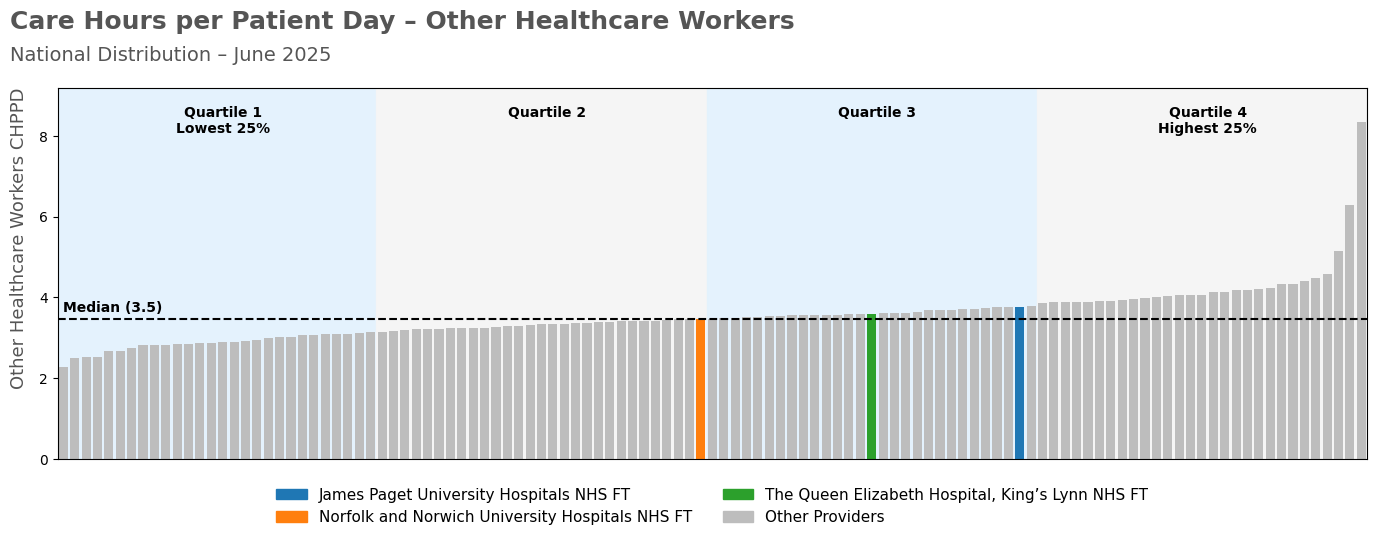

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# -----------------------------
# Styling
# -----------------------------
YEAR_LABEL_GRAY = "#555555"   # mesmo cinzento usado no outro plot

# -----------------------------
# Load and prepare the data
# -----------------------------
file_path = "chppd-smhi_merged filter with year month.csv"
df = pd.read_csv(file_path)

# Renomear colunas do ficheiro original para nomes mais simples
df = df.rename(columns={
    "Organisation Name": "org_name",
    "CHPPD – Registered Nurses and Midwives": "rnmid_chppd",
    "Non-registered Nurses": "nonreg_chppd",
    "CHPPD - Overall": "overall_chppd",
    "SHMI_VALUE": "shmi",
    "year_month": "date"
})

# -----------------------------
# Load and prepare data
# -----------------------------
df["date"] = pd.to_datetime(df["date"])

# Latest month only
latest_month = df["date"].max()
df_latest = df[df["date"] == latest_month]

month_year_str = latest_month.strftime("%B %Y")

# --- NON-REGISTERED / OTHER HEALTHCARE WORKERS ---
metric = "nonreg_chppd"

# Sorted values
trust_values = (
    df_latest.groupby("org_name")[metric]
    .mean()
    .sort_values(ascending=True)
)

# -----------------------------
# Basic setup
# -----------------------------
n = len(trust_values)
x = range(n)
y = trust_values.values

fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor("white")

# Quartile boundaries
q1 = int(0.25 * n)
q2 = int(0.50 * n)
q3 = int(0.75 * n)

y_lim_top = y.max() * 1.05

# -----------------------------
# Quartile soft shading
# -----------------------------
color_A = "#E3F2FD"
color_B = "#F5F5F5"

ax.axvspan(-0.5, q1 - 0.5,       color=color_A, alpha=0.95, zorder=1)
ax.axvspan(q1 - 0.5, q2 - 0.5,   color=color_B, alpha=0.95, zorder=1)
ax.axvspan(q2 - 0.5, q3 - 0.5,   color=color_A, alpha=0.95, zorder=1)
ax.axvspan(q3 - 0.5, n - 0.5,    color=color_B, alpha=0.95, zorder=1)

# -----------------------------
# Color palette (TAB10)
# -----------------------------
tab10 = plt.cm.tab10

color_jpaget = tab10(0)    # blue
color_nnuht  = tab10(1)    # orange
color_qeh    = tab10(2)    # green
other_color  = "#BDBDBD"   # grey

highlight_map = {
    "James Paget University Hospitals NHS Foundation Trust": color_jpaget,
    "Norfolk And Norwich University Hospitals NHS Foundation Trust": color_nnuht,
    "The Queen Elizabeth Hospital, King'S Lynn, NHS Foundation Trust": color_qeh,
}

# Build colors
colors = [highlight_map.get(org, other_color) for org in trust_values.index]

# -----------------------------
# Bars
# -----------------------------
ax.bar(x, y, color=colors, zorder=2)
ax.set_xticks([])

# -----------------------------
# Quartile labels (bold)
# -----------------------------
ax.text(q1/2, y_lim_top, "Quartile 1\nLowest 25%",
        ha="center", va="top", fontsize=10, fontweight="bold")
ax.text((q1+q2)/2, y_lim_top, "Quartile 2",
        ha="center", va="top", fontsize=10, fontweight="bold")
ax.text((q2+q3)/2, y_lim_top, "Quartile 3",
        ha="center", va="top", fontsize=10, fontweight="bold")
ax.text((q3+n)/2, y_lim_top, "Quartile 4\nHighest 25%",
        ha="center", va="top", fontsize=10, fontweight="bold")

# -----------------------------
# Median line + label (bold)
# -----------------------------
median_val = trust_values.median()
ax.axhline(median_val, linestyle="--", color="black", zorder=3)
ax.text(0, median_val + 0.1, f"Median ({median_val:.1f})",
        ha="left", va="bottom", zorder=3, fontweight="bold")

# -----------------------------
# Title (AfC style)
# -----------------------------
main_title = "Care Hours per Patient Day – Other Healthcare Workers"
subtitle = f"National Distribution – {month_year_str}"

fig.suptitle(
    main_title,
    x=0.0, y=0.98, ha="left",
    fontsize=18, fontweight="bold", color=YEAR_LABEL_GRAY
)
fig.text(
    0.0, 0.92, subtitle,
    ha="left", va="top",
    fontsize=14, color=YEAR_LABEL_GRAY
)

# -----------------------------
# LEFT vertical y-label (AfC style)
# -----------------------------
fig.text(
    0.0, 0.60, "Other Healthcare Workers CHPPD",
    rotation=90, va="center", ha="left",
    color=YEAR_LABEL_GRAY, fontsize=13
)

# -----------------------------
# Legend
# -----------------------------
handles = [
    mpatches.Patch(color=color_jpaget, label="James Paget University Hospitals NHS FT"),
    mpatches.Patch(color=color_nnuht, label="Norfolk and Norwich University Hospitals NHS FT"),
    mpatches.Patch(color=color_qeh, label="The Queen Elizabeth Hospital, King’s Lynn NHS FT"),
    mpatches.Patch(color=other_color, label="Other Providers"),
]

ax.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.04),
    ncol=2,
    frameon=False,
    fontsize=11
)

# -----------------------------
# Remove white space on left/right
# -----------------------------
ax.set_xlim(-0.5, n - 0.5)
ax.margins(x=0)

plt.ylim(top=y_lim_top * 1.05)

# deixar espaço para título e y-label à esquerda
plt.tight_layout(rect=[0.01, 0.08, 0.98, 0.94])

# -----------------------------
# Save plot (per month)
# -----------------------------
month_str = latest_month.strftime("%Y_%m")
filename = f"CHPPD_NRN_distribution_{month_str}.png"
save_path = os.path.join(plot_save_path, filename)

plt.savefig(save_path, bbox_inches="tight", dpi=300)
print(f"Saved to: {save_path}")

plt.show()

Removed 22 outlier rows with Overall CHPPD > 16.
Removed 4 rows with SHMI < 0.1.
Found 54 distinct months.
Processing month: 2020-12 (113 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2020_12.png


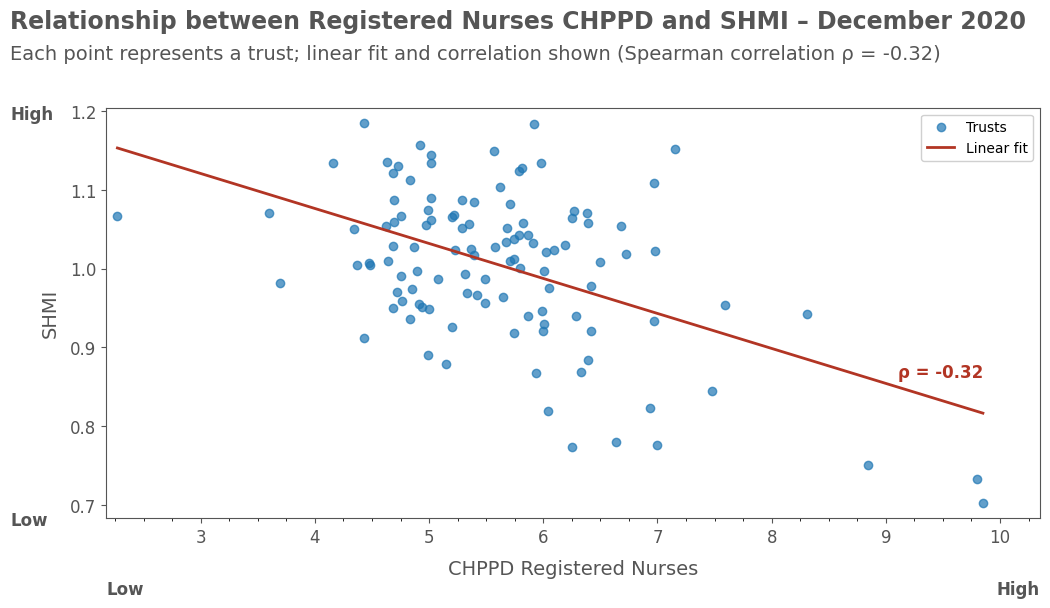

Processing month: 2021-01 (110 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_01.png


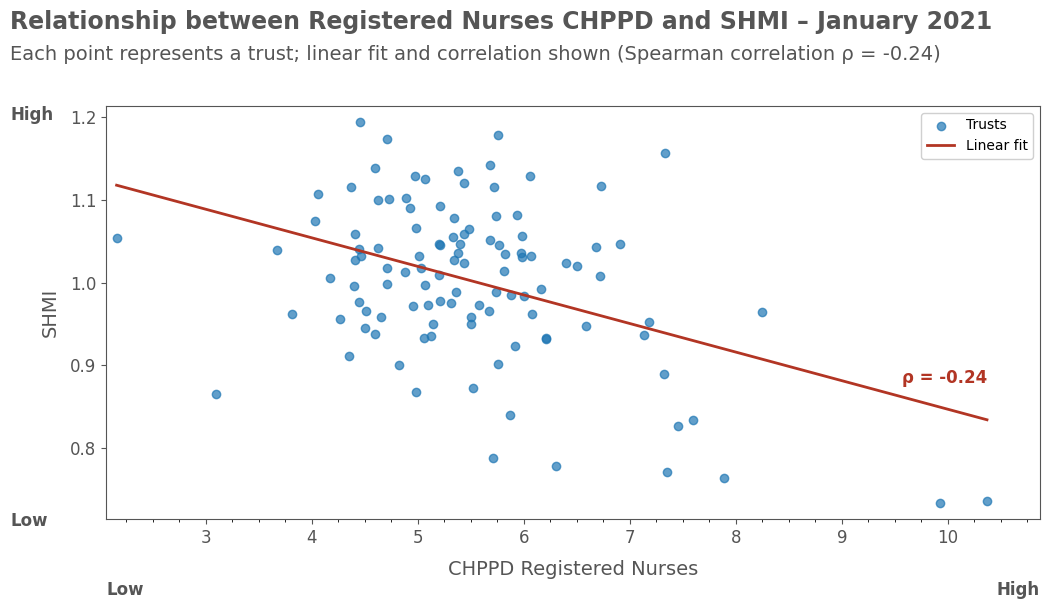

Processing month: 2021-02 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_02.png


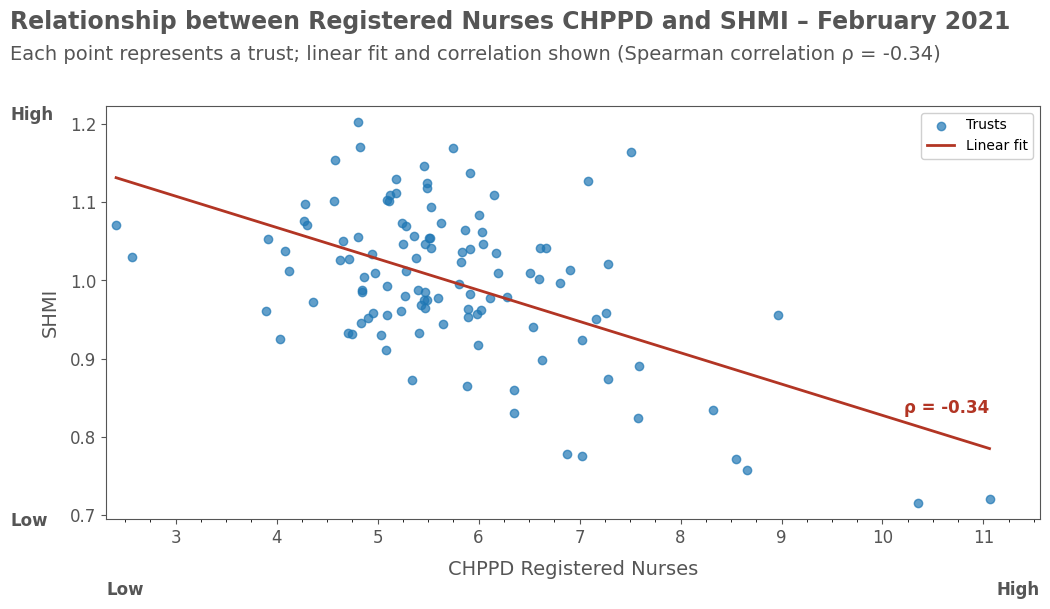

Processing month: 2021-03 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_03.png


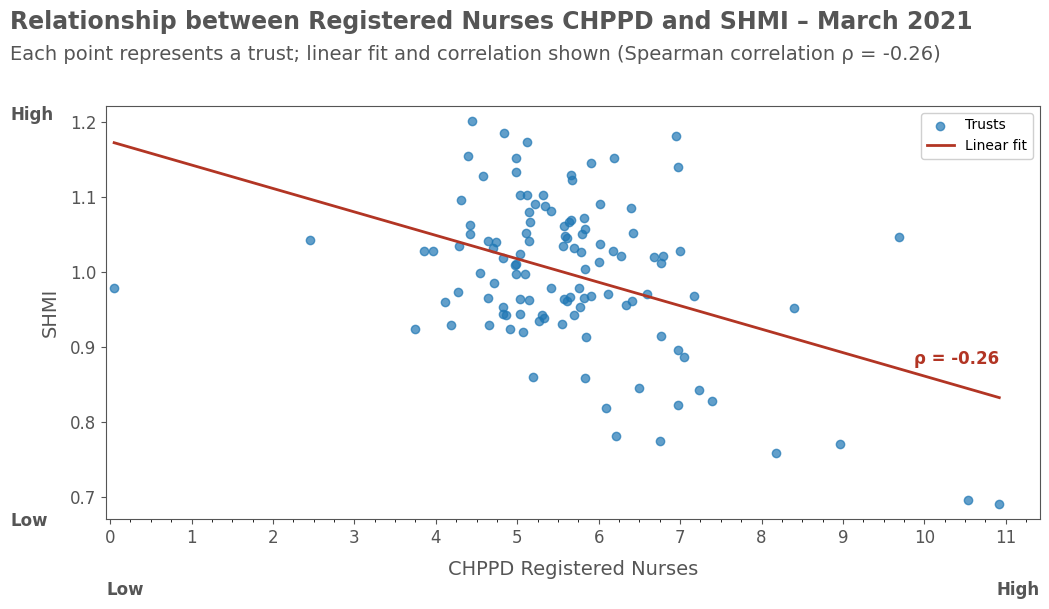

Processing month: 2021-04 (118 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_04.png


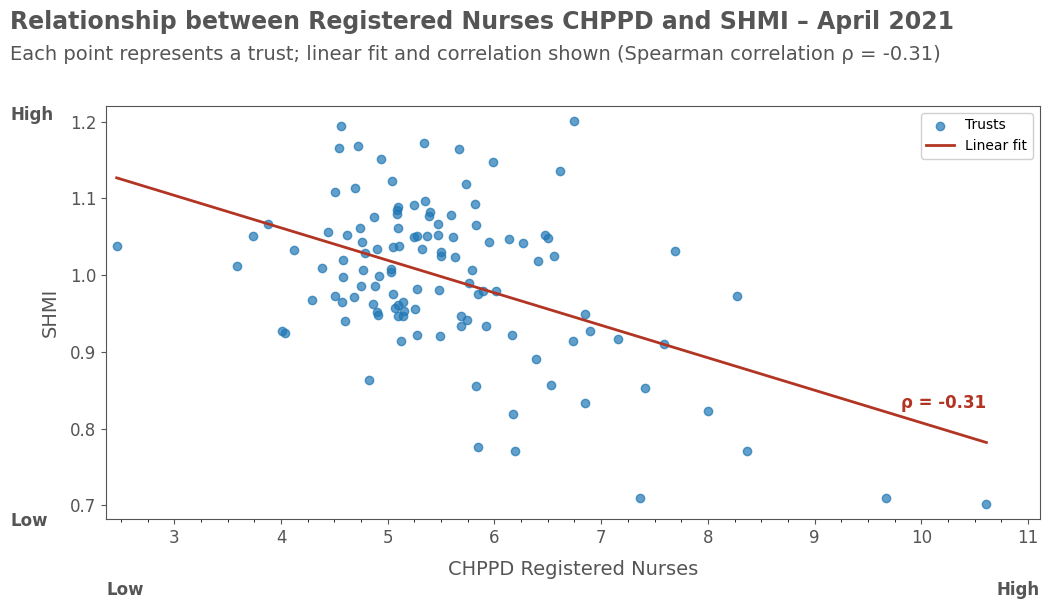

Processing month: 2021-05 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_05.png


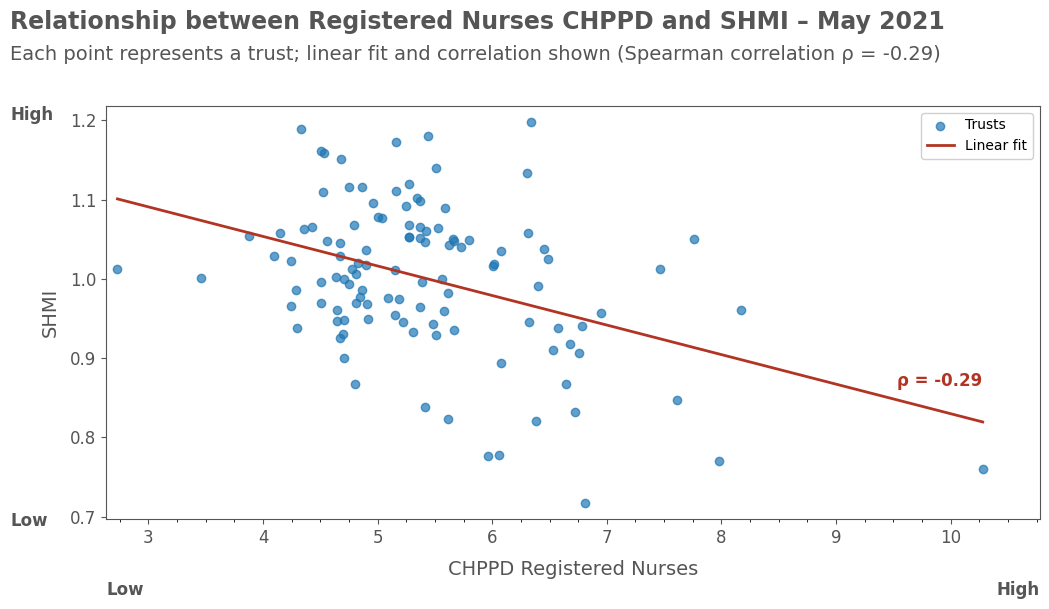

Processing month: 2021-06 (117 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_06.png


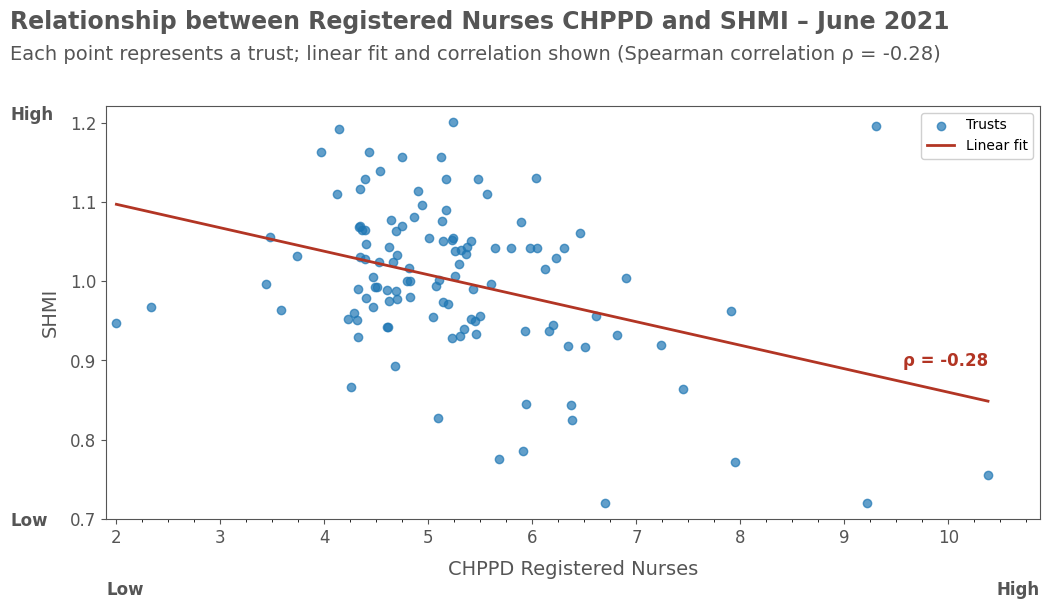

Processing month: 2021-08 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_08.png


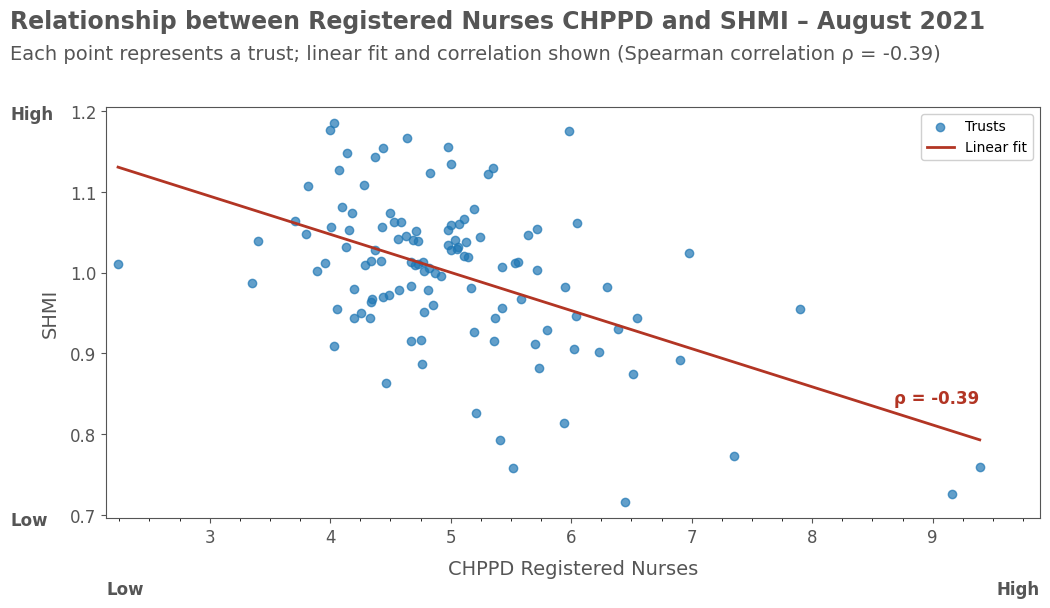

Processing month: 2021-09 (115 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_09.png


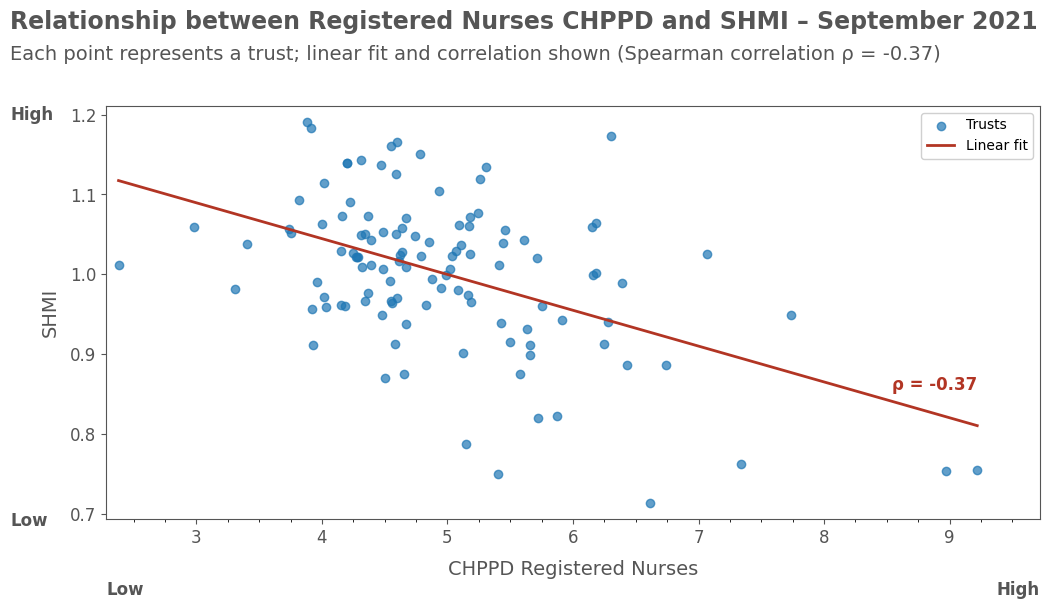

Processing month: 2021-10 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_10.png


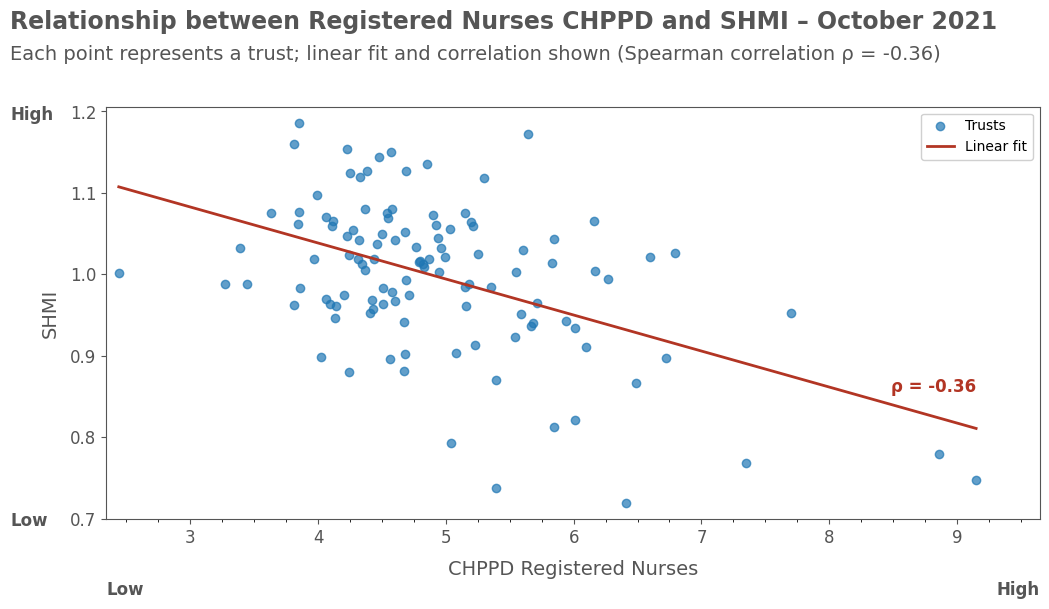

Processing month: 2021-11 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_11.png


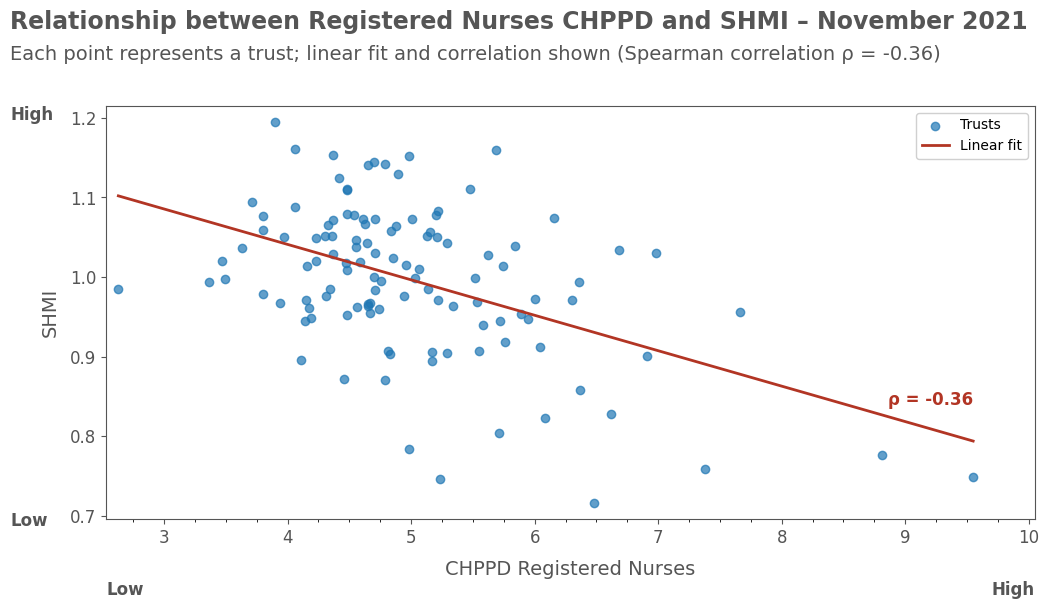

Processing month: 2021-12 (117 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2021_12.png


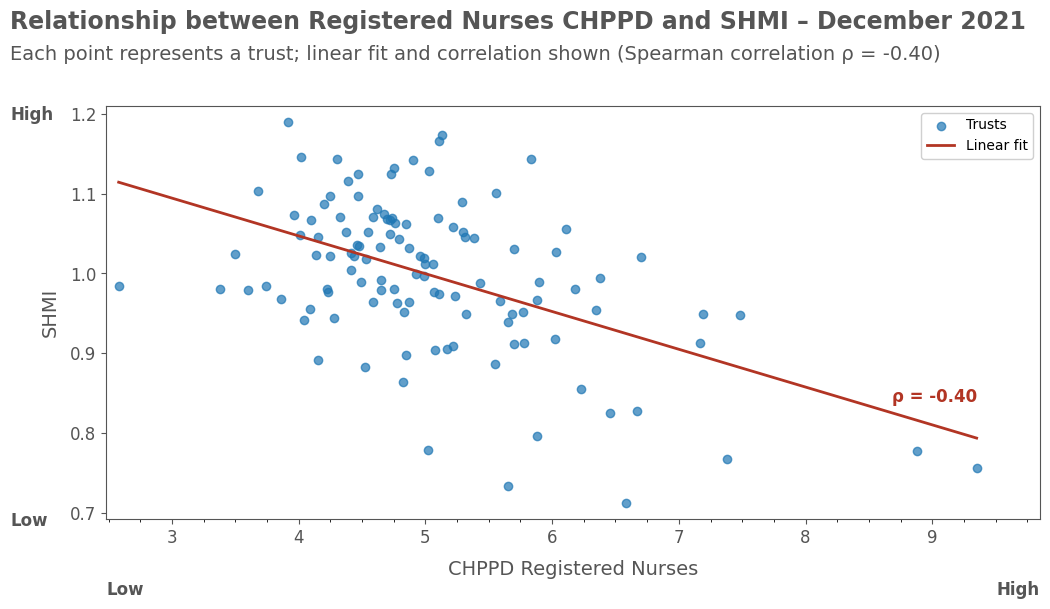

Processing month: 2022-01 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_01.png


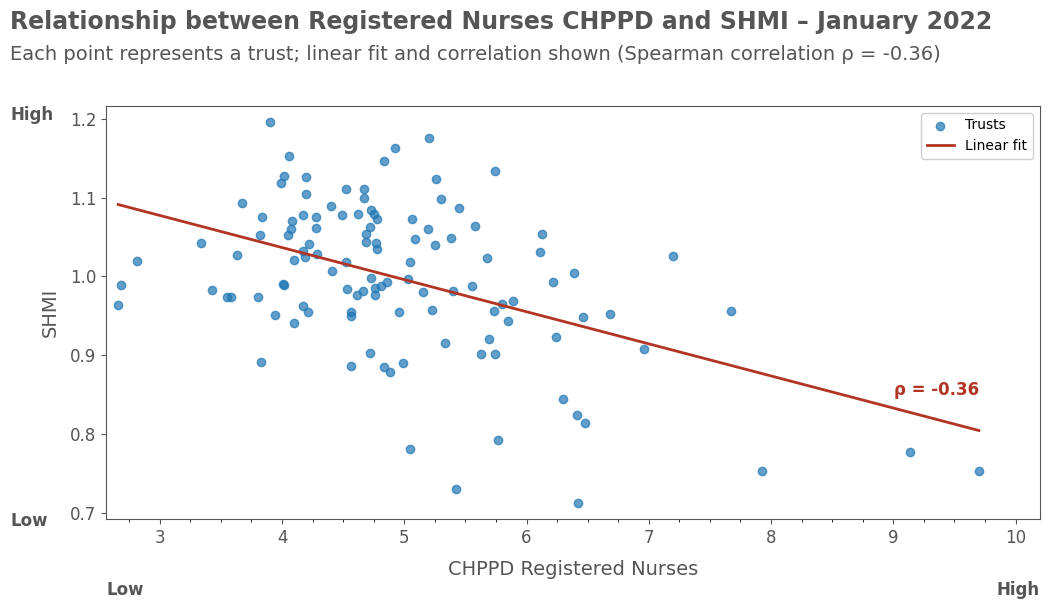

Processing month: 2022-02 (117 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_02.png


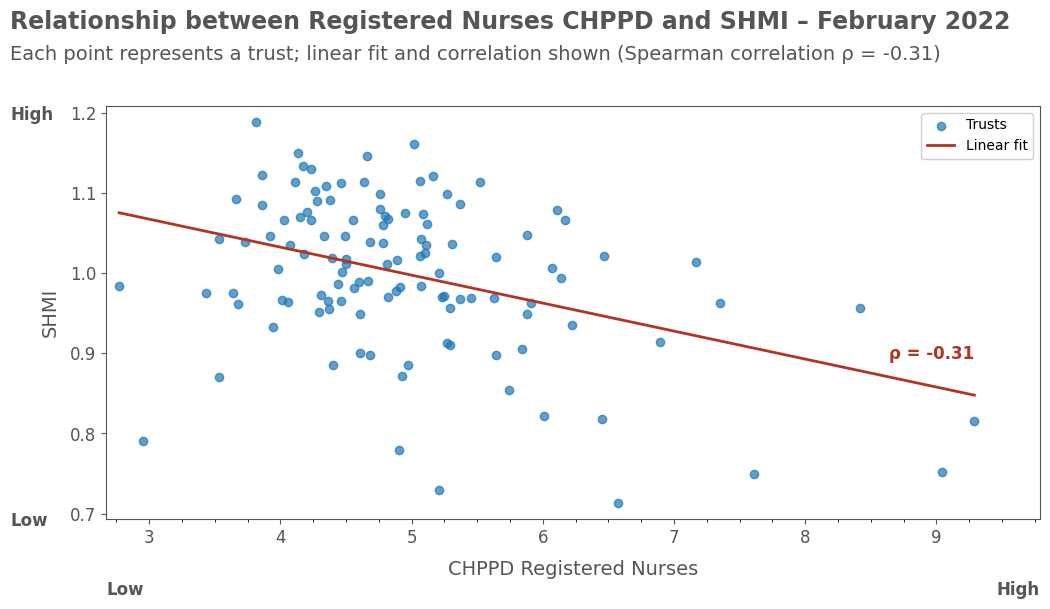

Processing month: 2022-03 (117 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_03.png


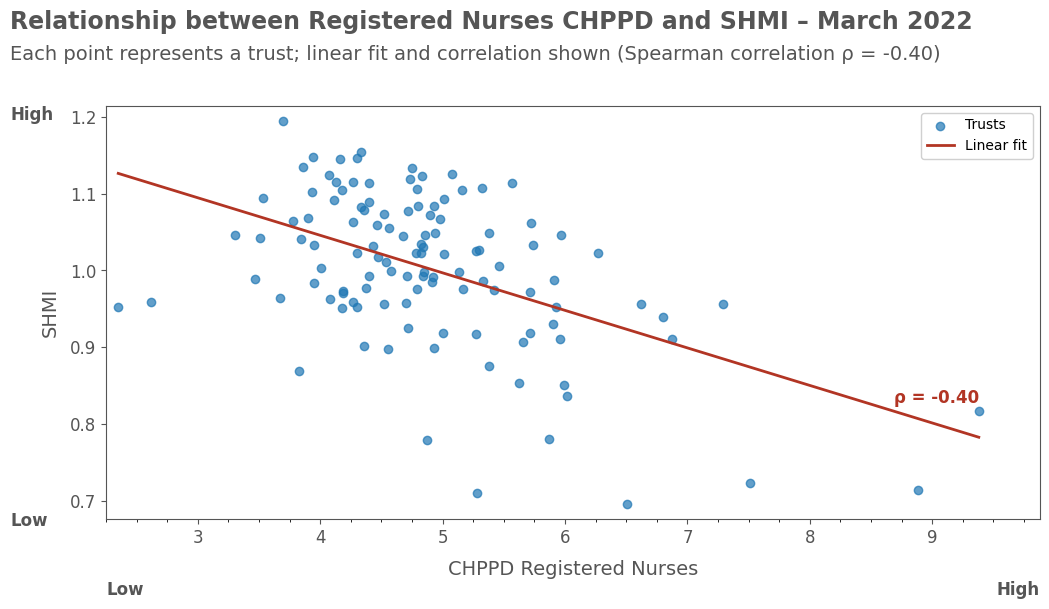

Processing month: 2022-04 (115 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_04.png


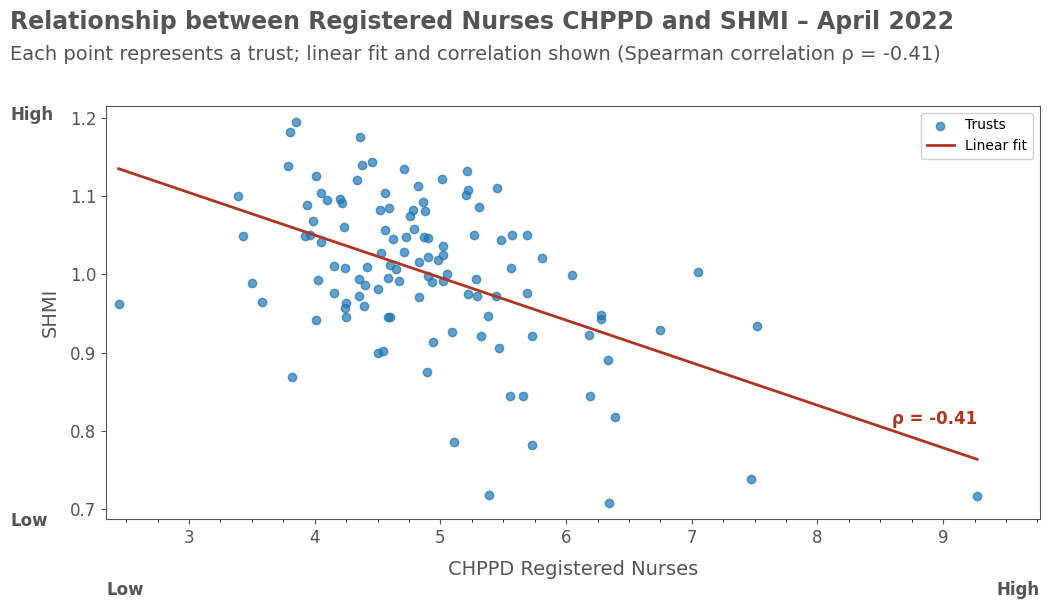

Processing month: 2022-05 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_05.png


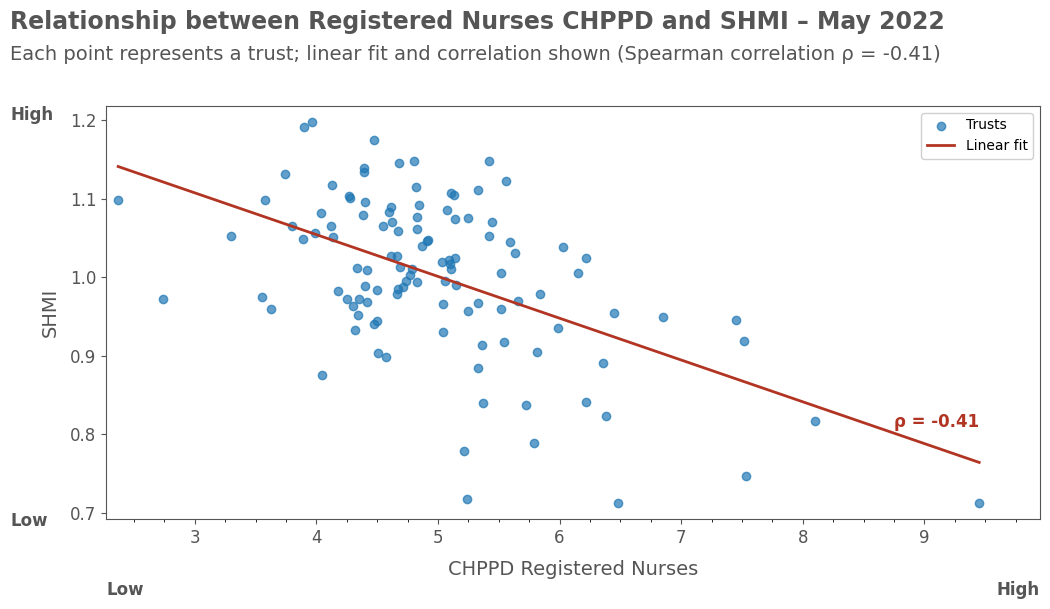

Processing month: 2022-06 (110 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_06.png


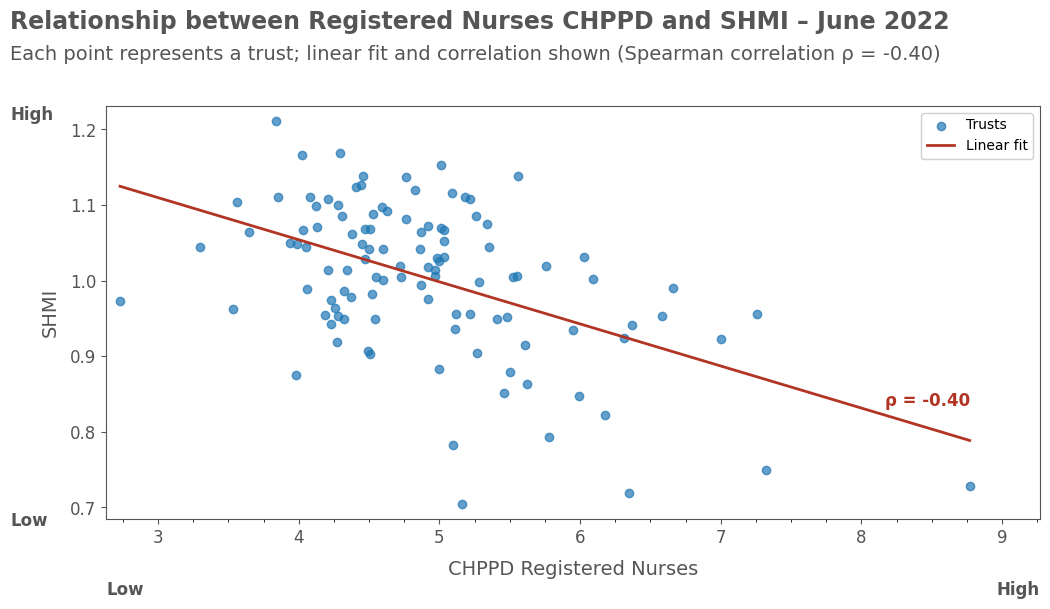

Processing month: 2022-07 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_07.png


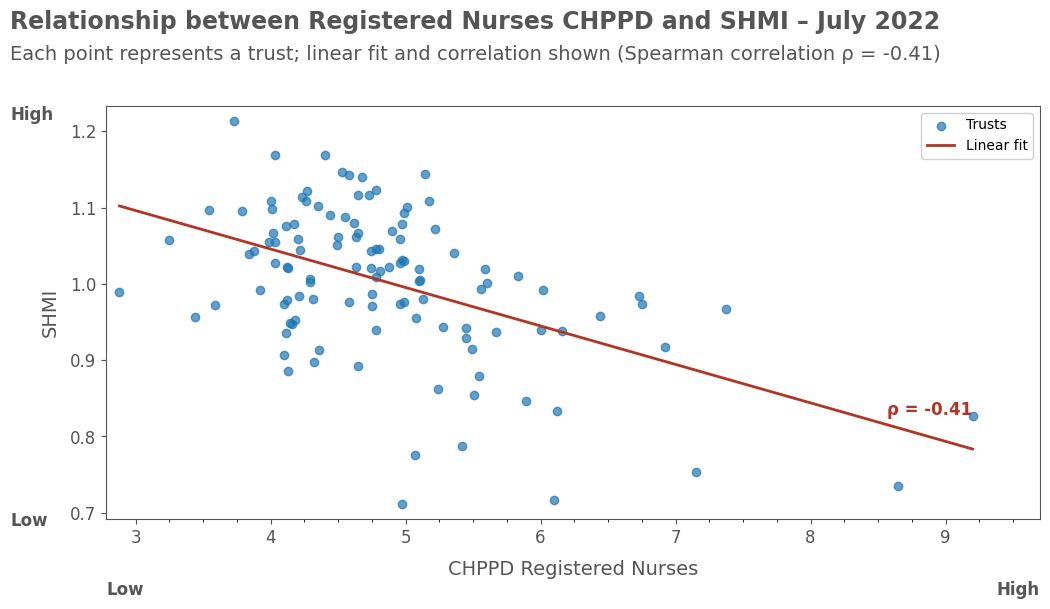

Processing month: 2022-08 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_08.png


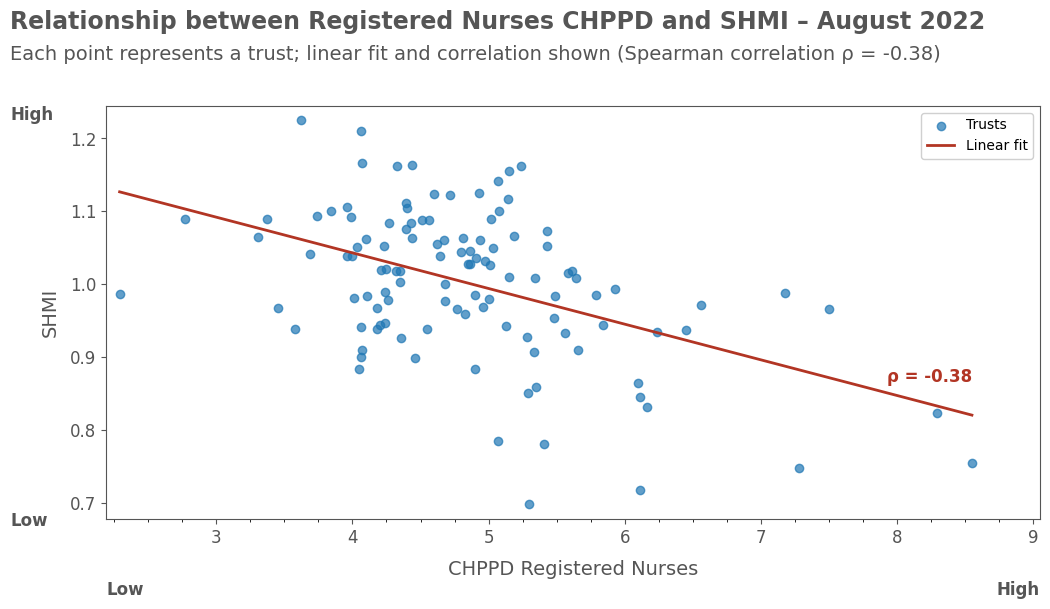

Processing month: 2022-09 (112 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_09.png


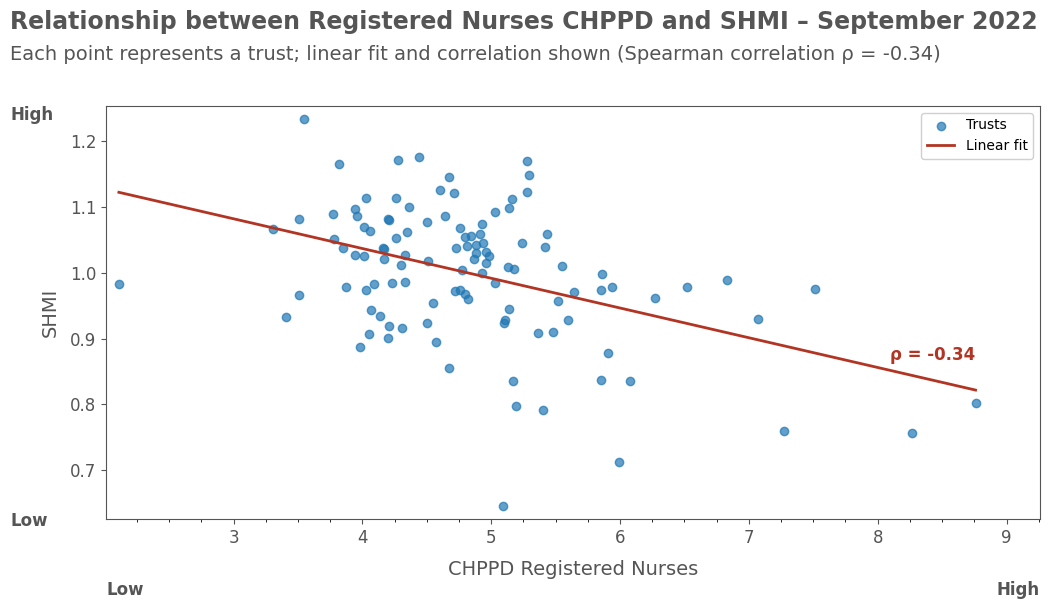

Processing month: 2022-10 (118 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_10.png


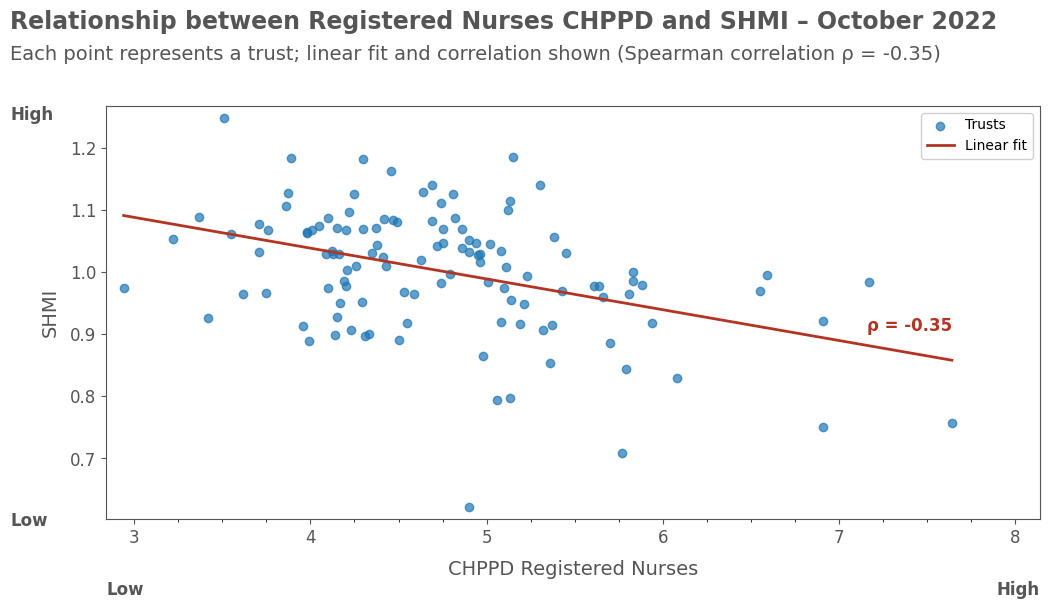

Processing month: 2022-11 (118 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_11.png


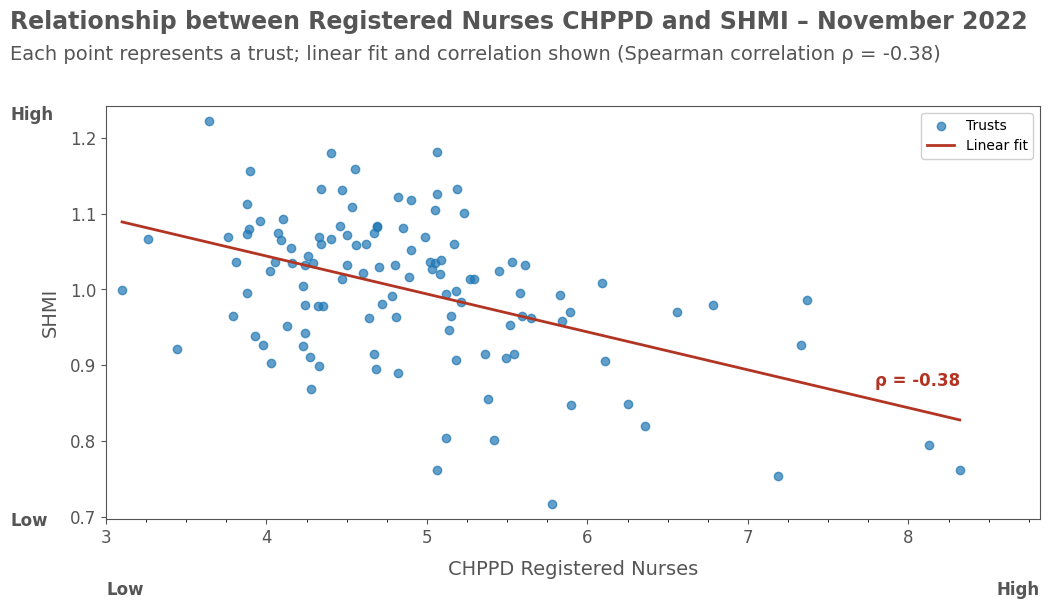

Processing month: 2022-12 (118 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2022_12.png


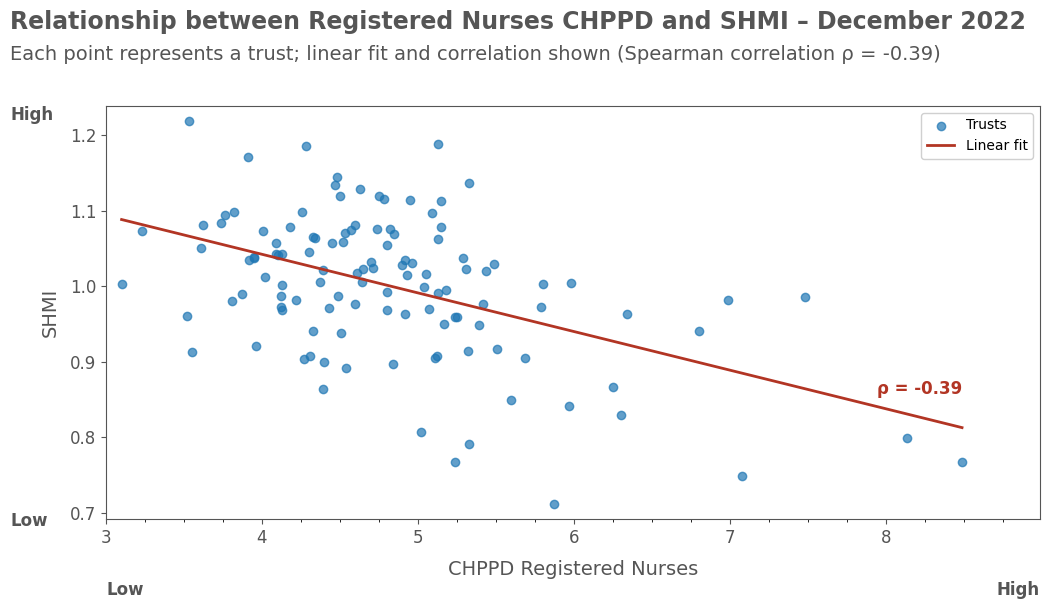

Processing month: 2023-01 (111 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_01.png


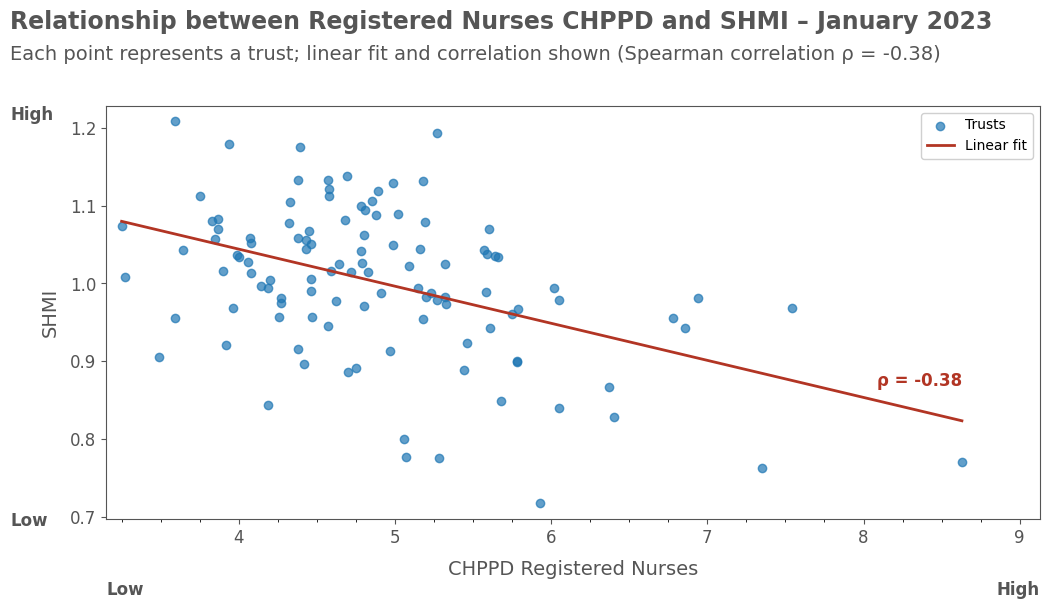

Processing month: 2023-02 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_02.png


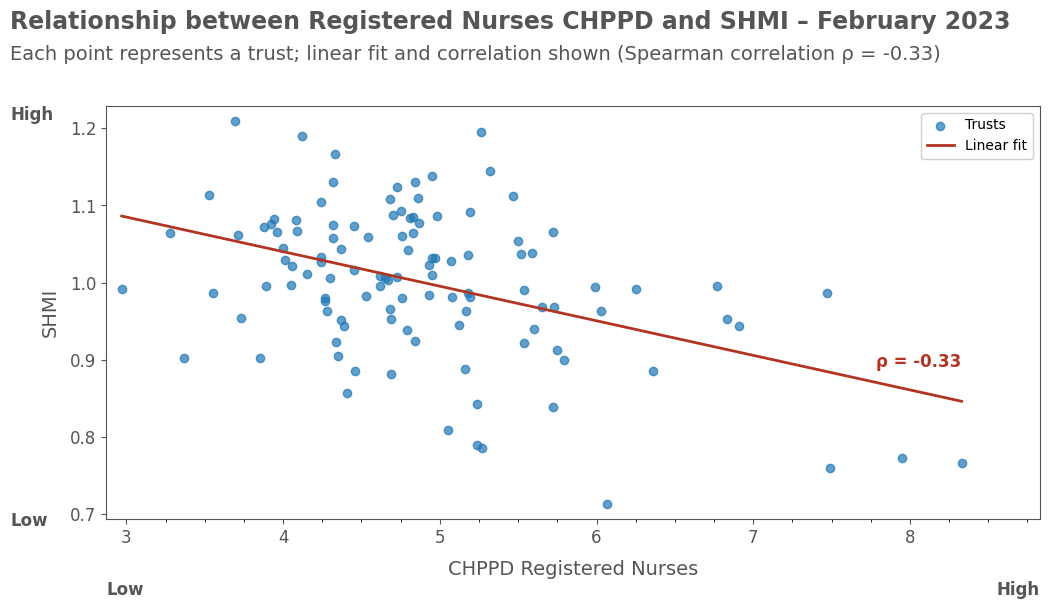

Processing month: 2023-03 (117 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_03.png


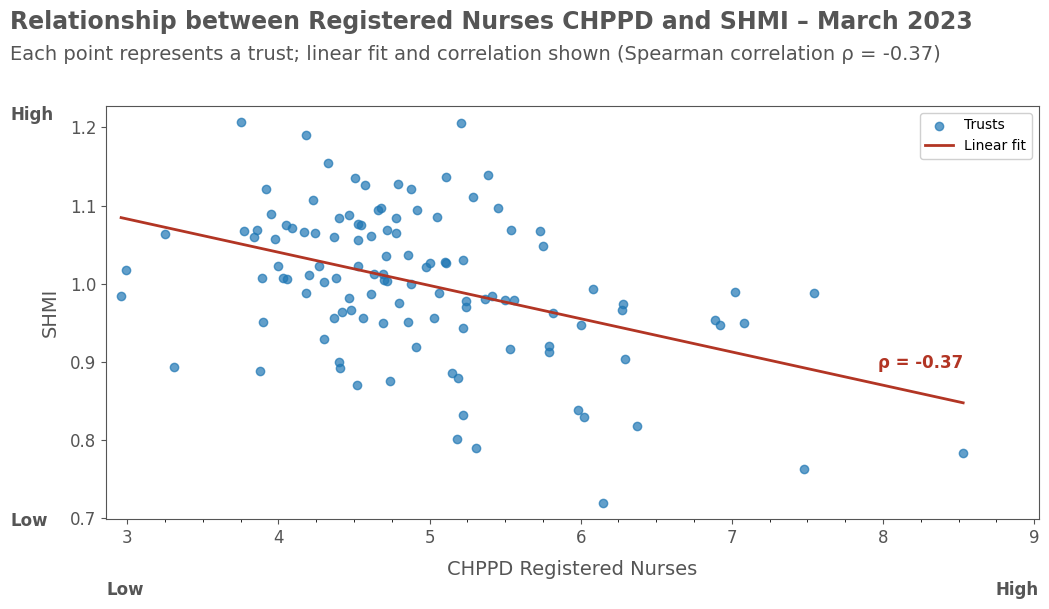

Processing month: 2023-04 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_04.png


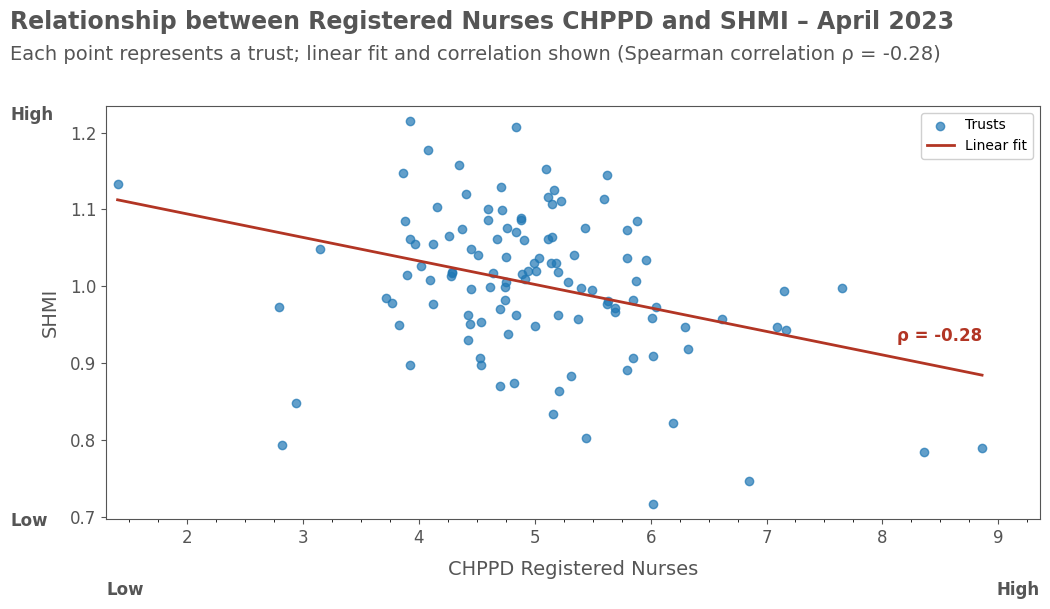

Processing month: 2023-05 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_05.png


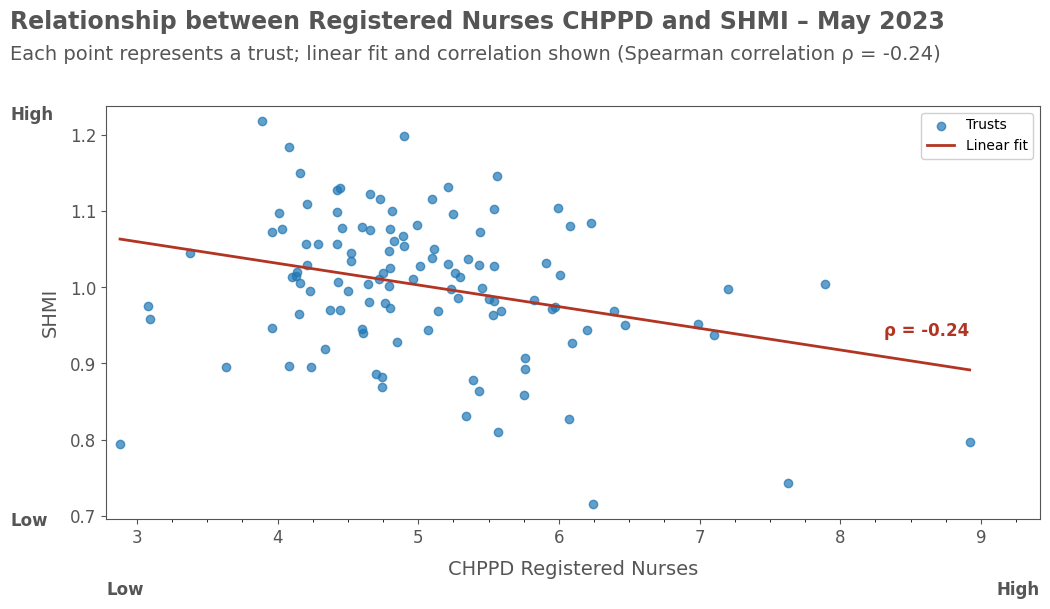

Processing month: 2023-06 (117 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_06.png


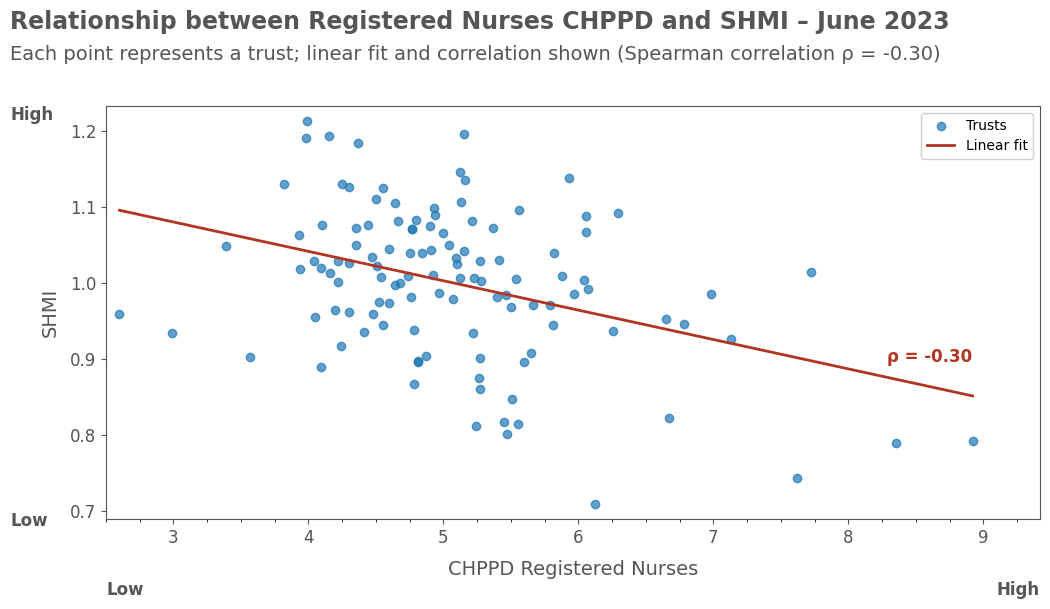

Processing month: 2023-07 (115 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_07.png


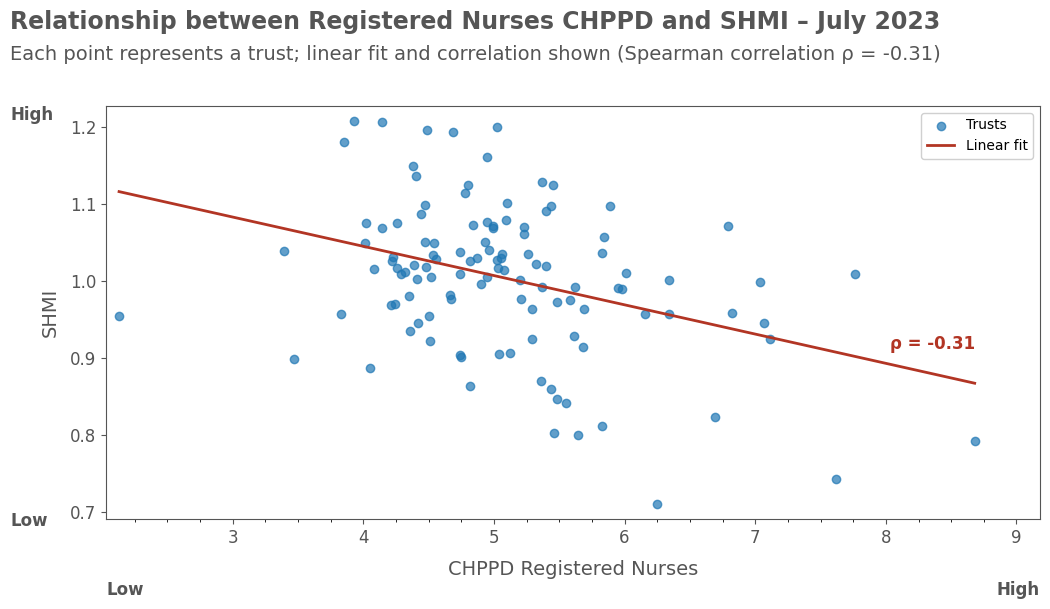

Processing month: 2023-08 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_08.png


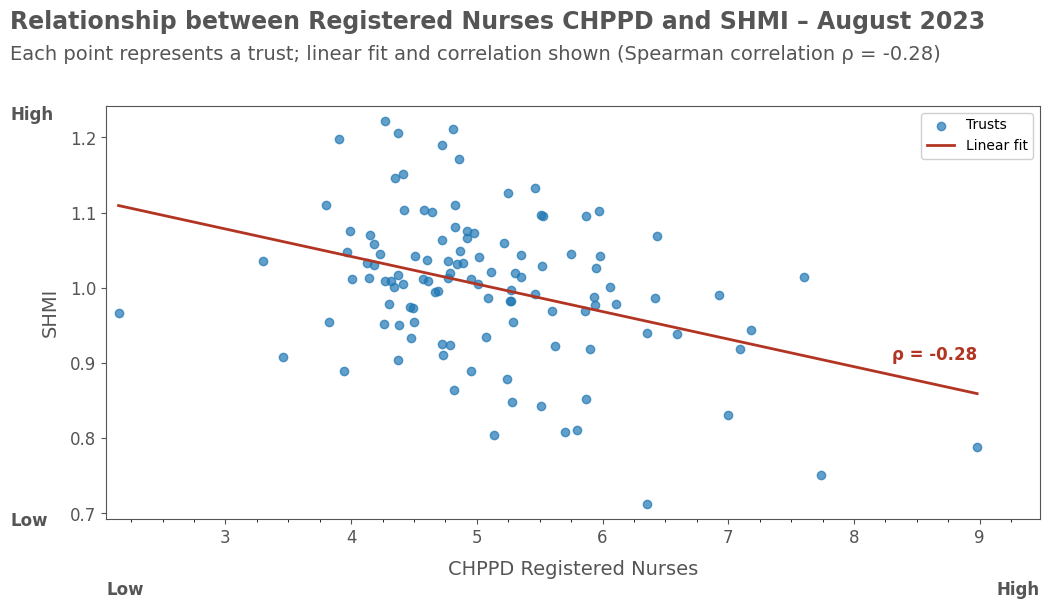

Processing month: 2023-09 (115 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_09.png


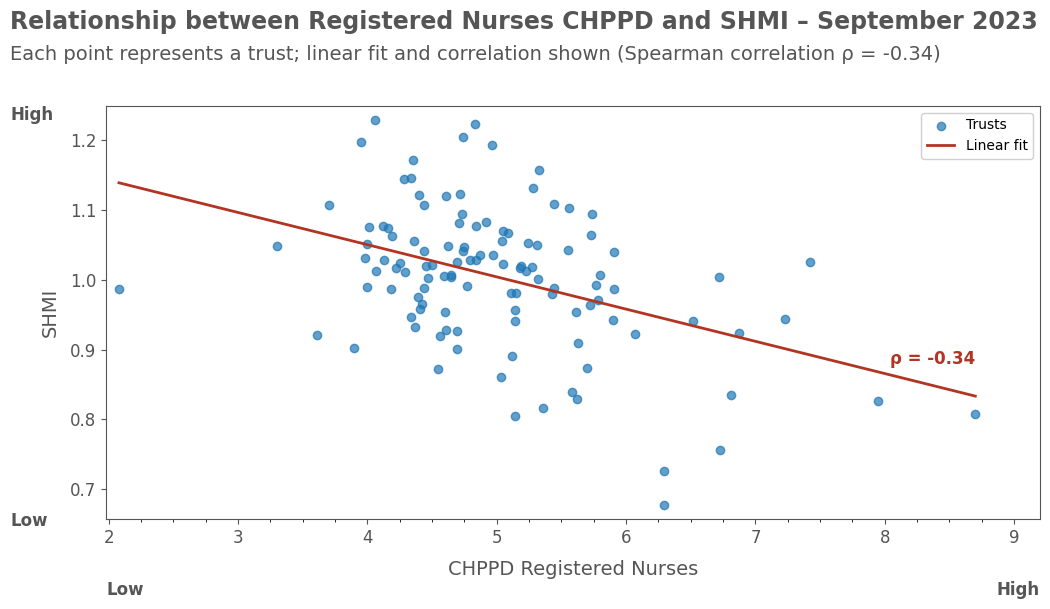

Processing month: 2023-10 (115 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_10.png


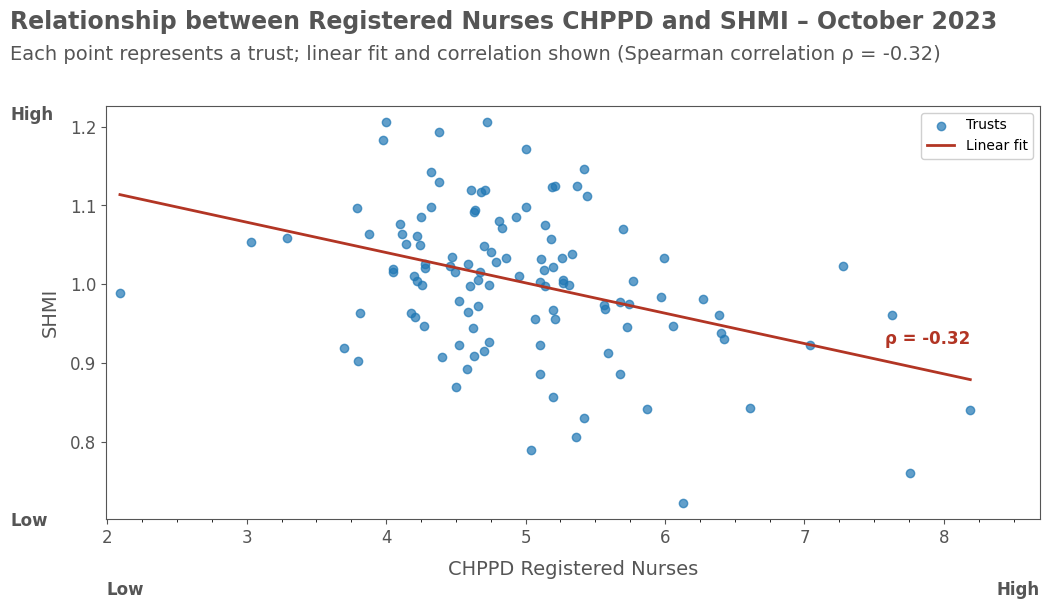

Processing month: 2023-11 (113 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_11.png


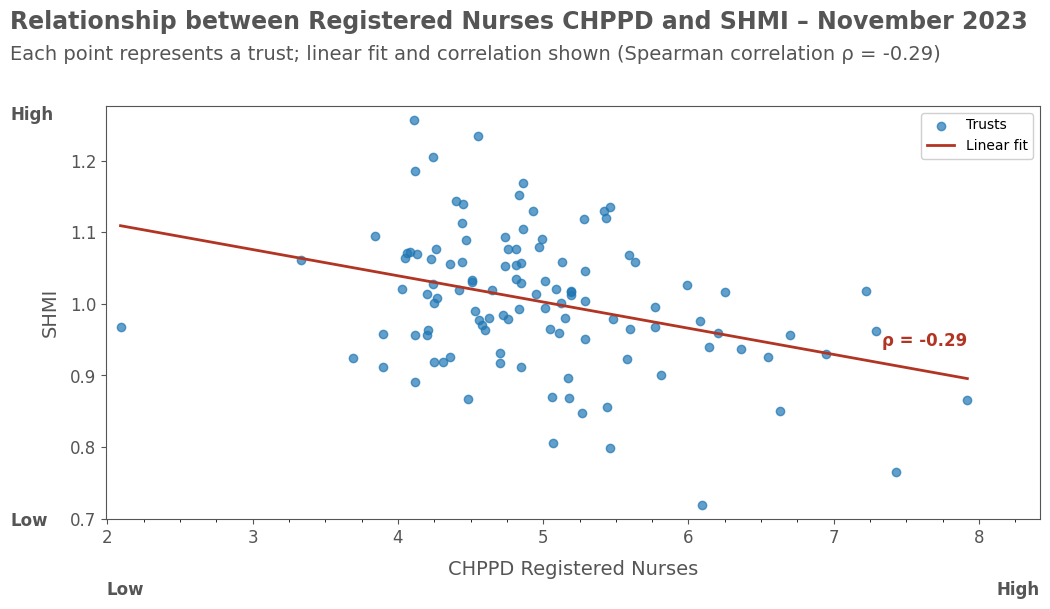

Processing month: 2023-12 (111 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2023_12.png


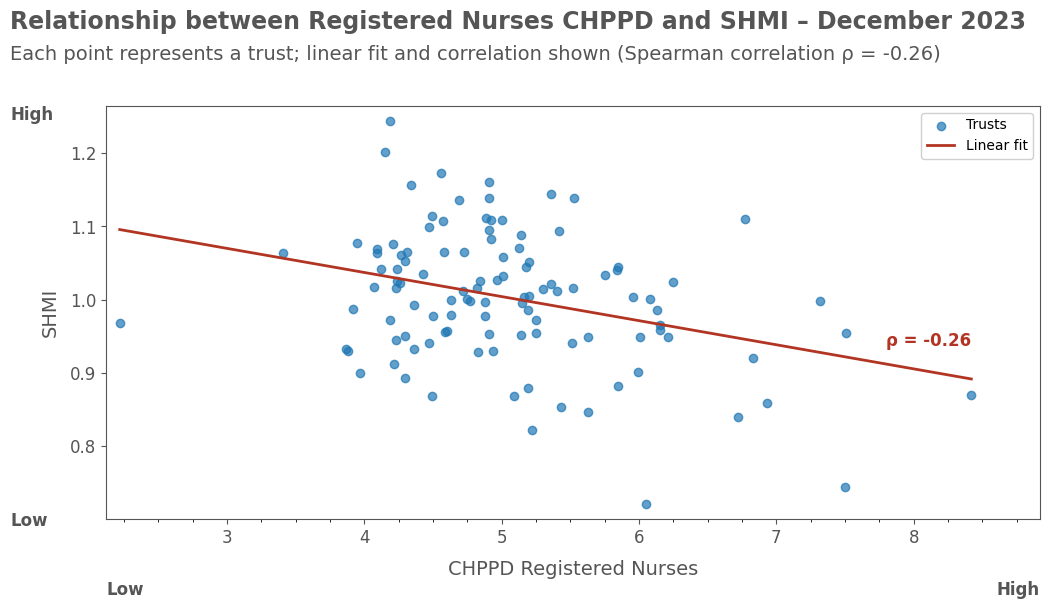

Processing month: 2024-01 (112 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_01.png


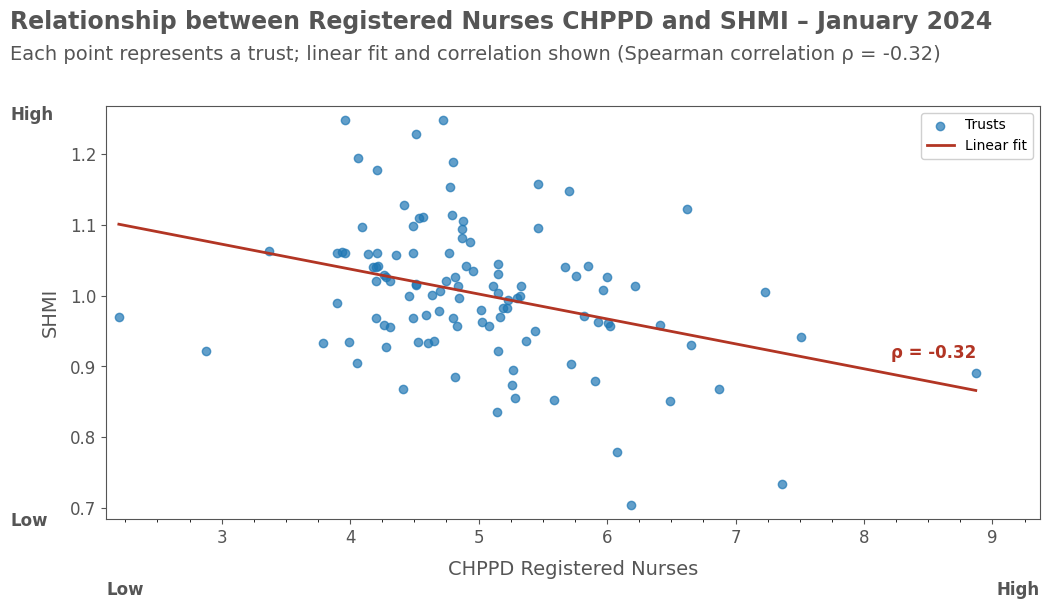

Processing month: 2024-02 (110 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_02.png


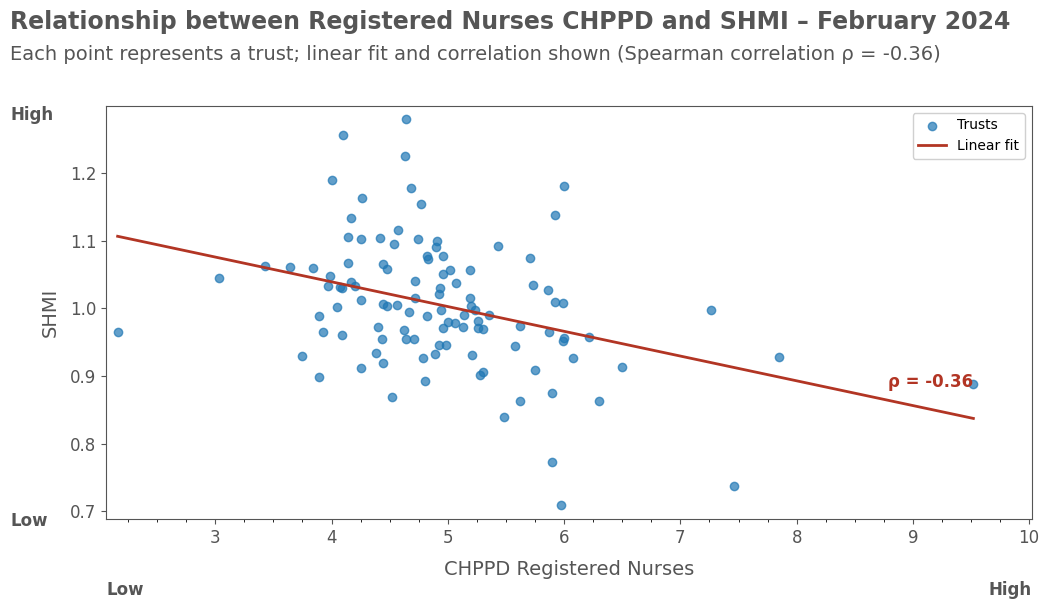

Processing month: 2024-03 (111 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_03.png


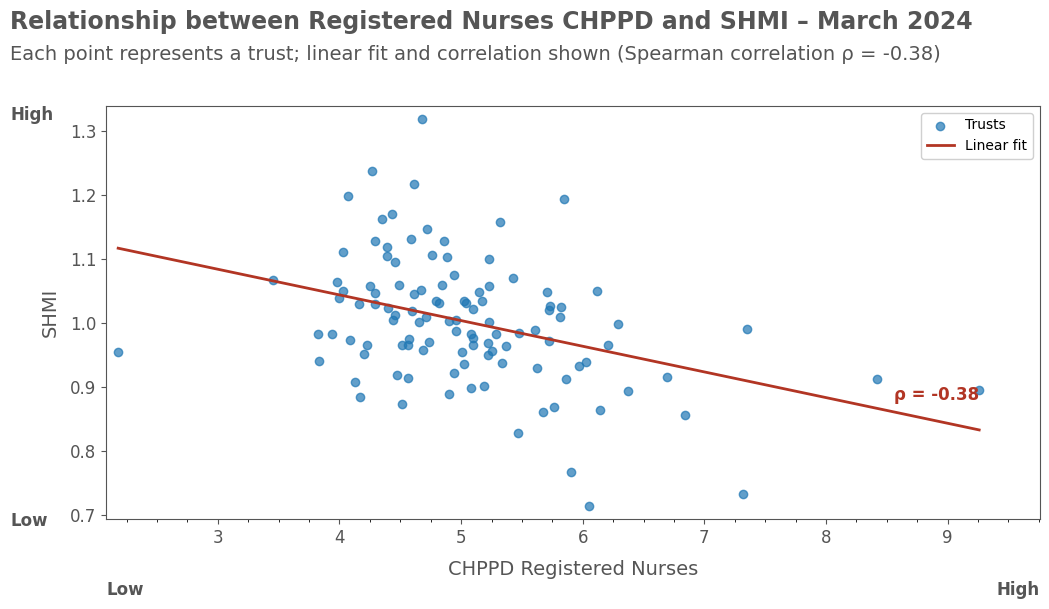

Processing month: 2024-04 (107 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_04.png


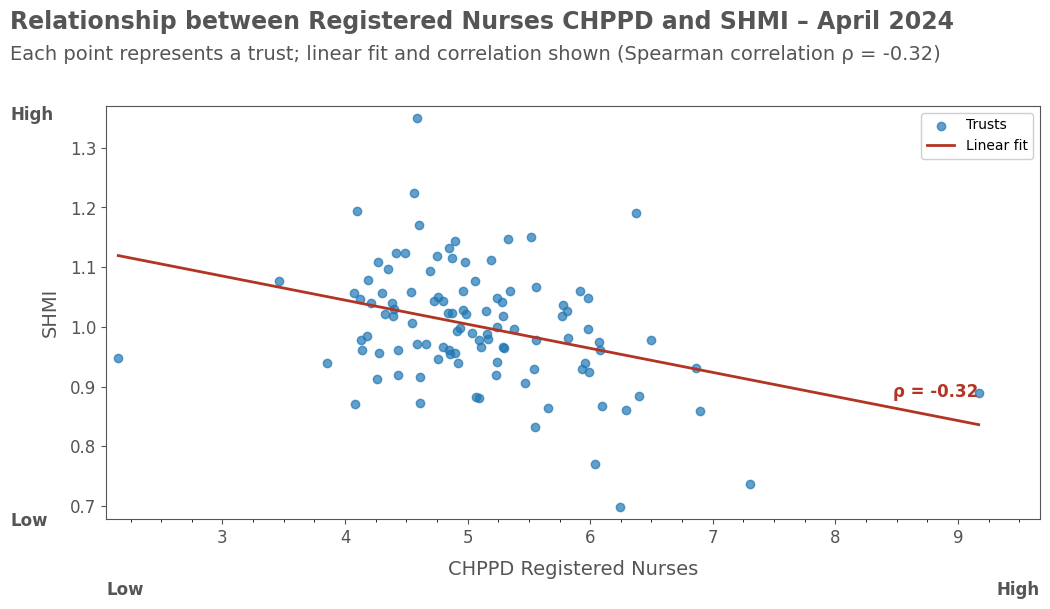

Processing month: 2024-05 (111 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_05.png


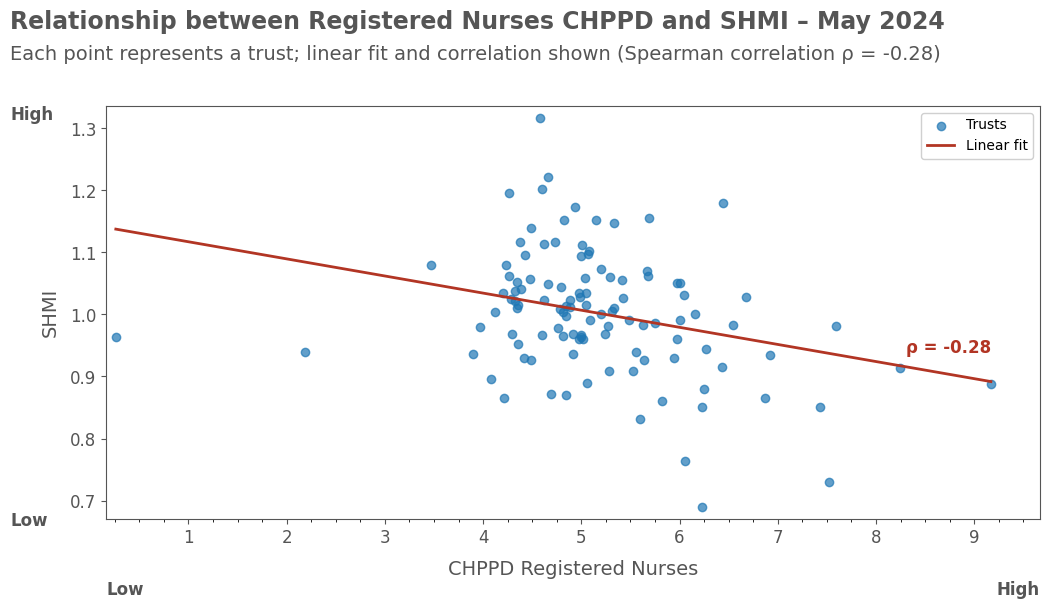

Processing month: 2024-06 (112 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_06.png


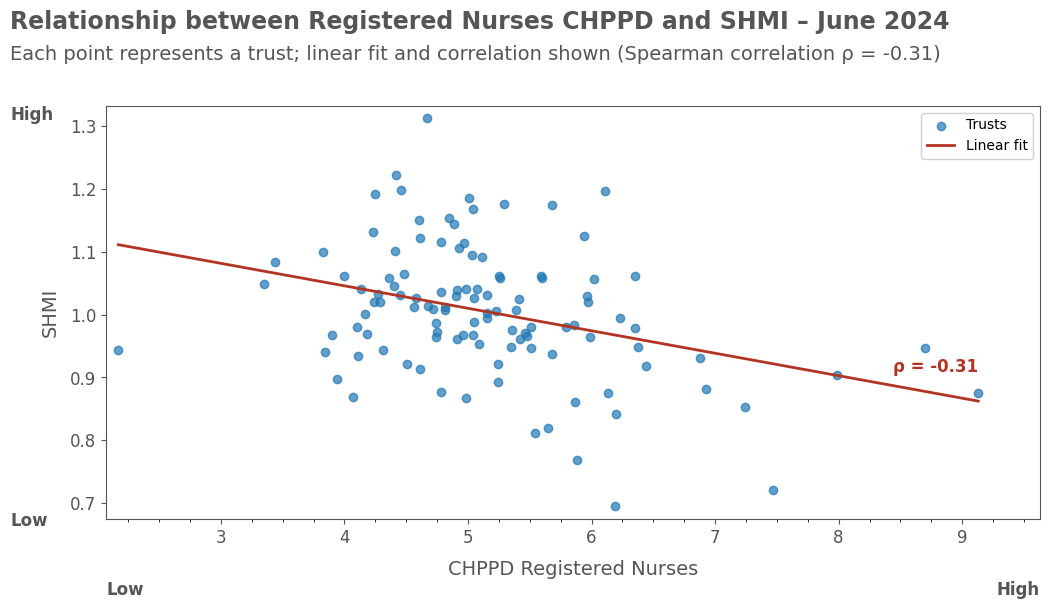

Processing month: 2024-07 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_07.png


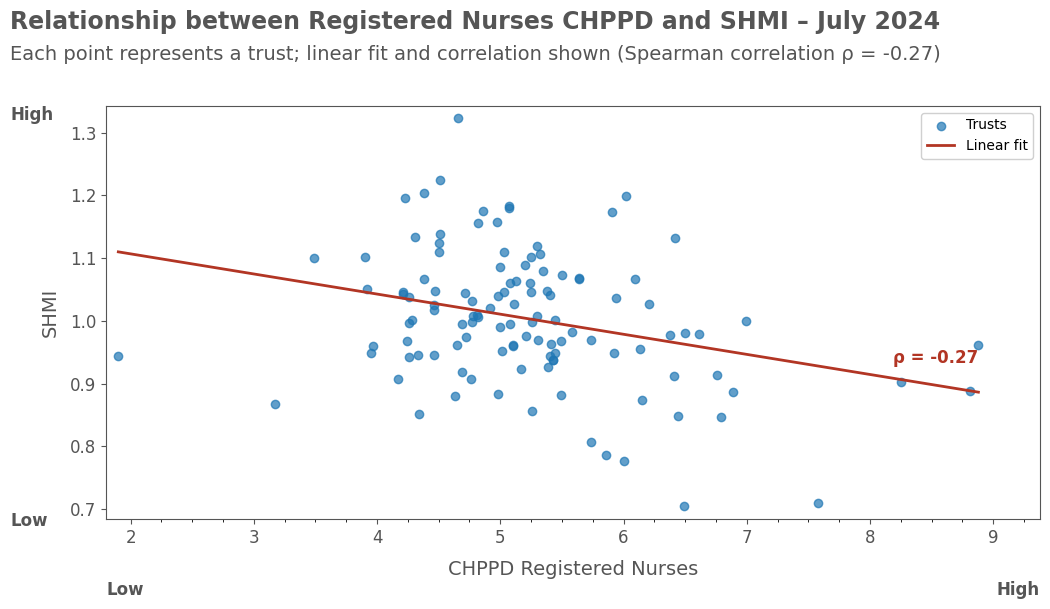

Processing month: 2024-08 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_08.png


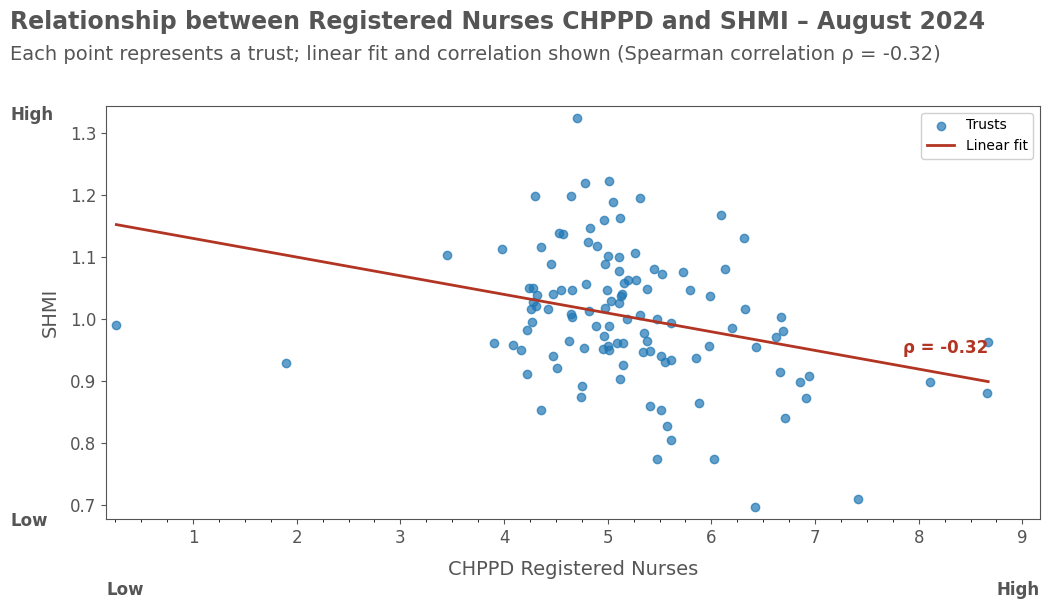

Processing month: 2024-09 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_09.png


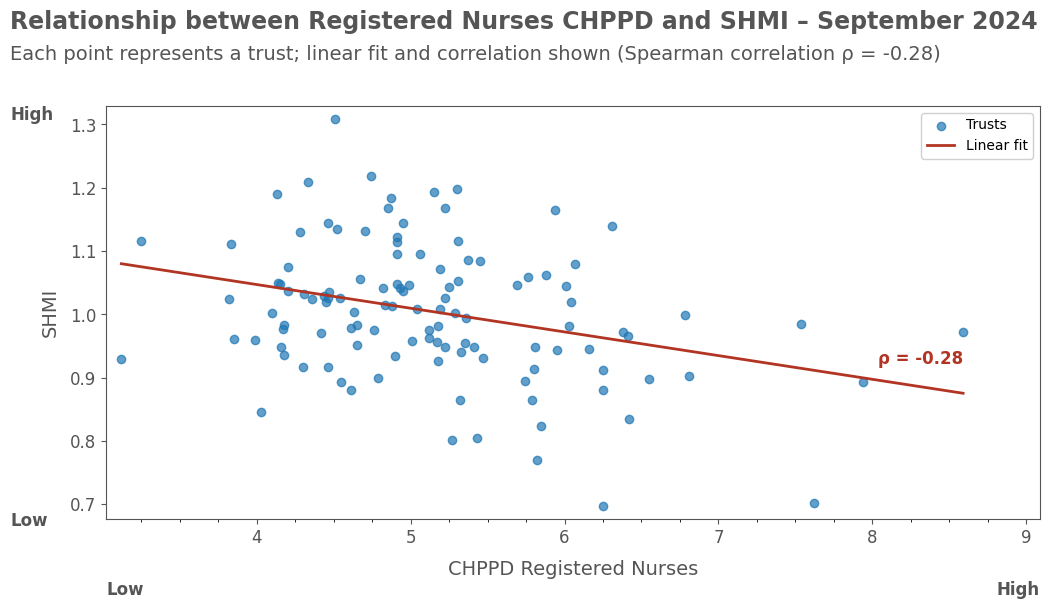

Processing month: 2024-10 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_10.png


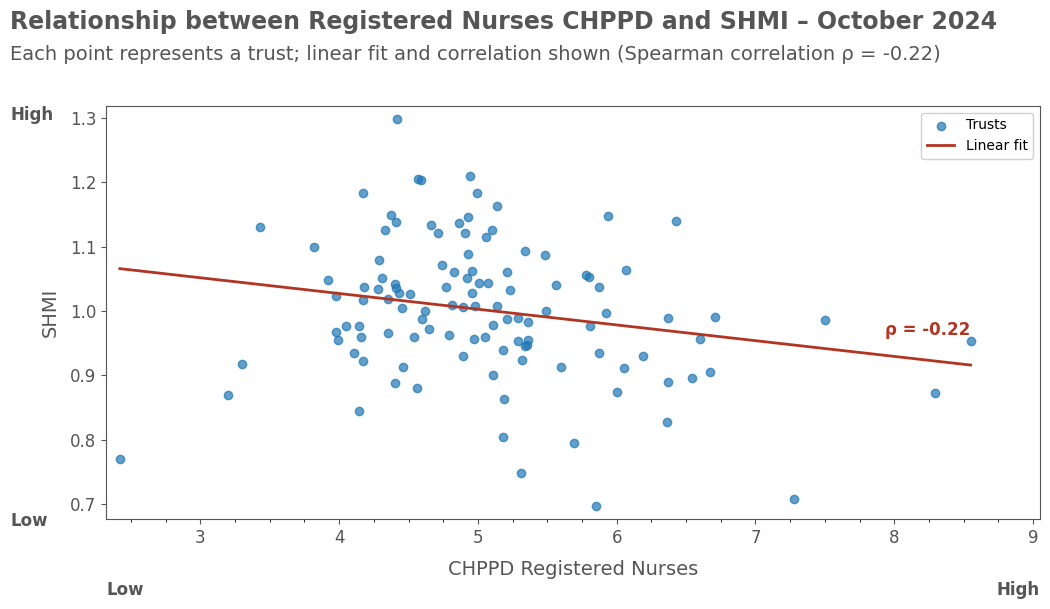

Processing month: 2024-11 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_11.png


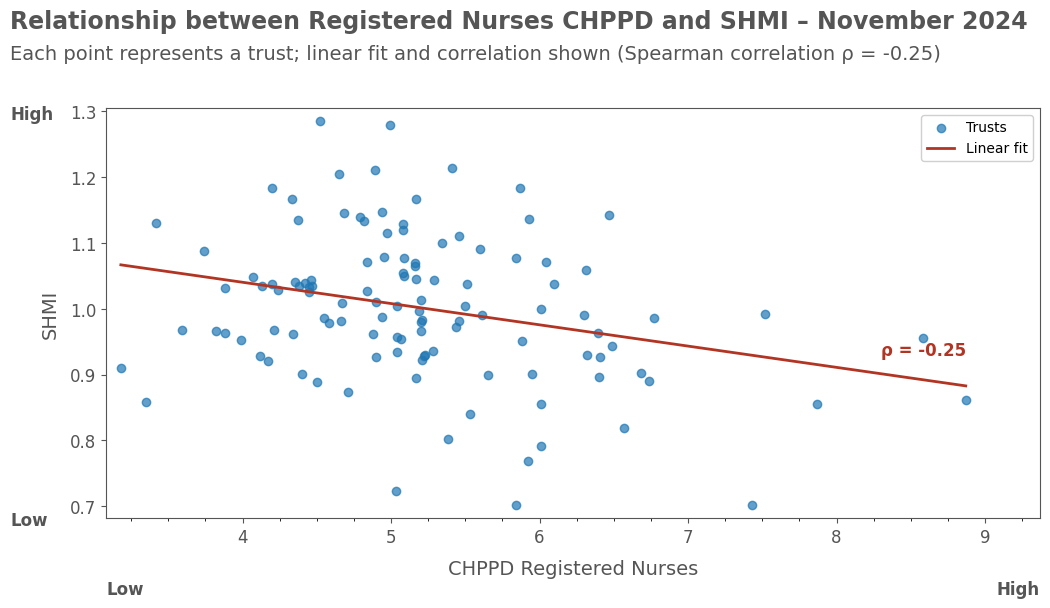

Processing month: 2024-12 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2024_12.png


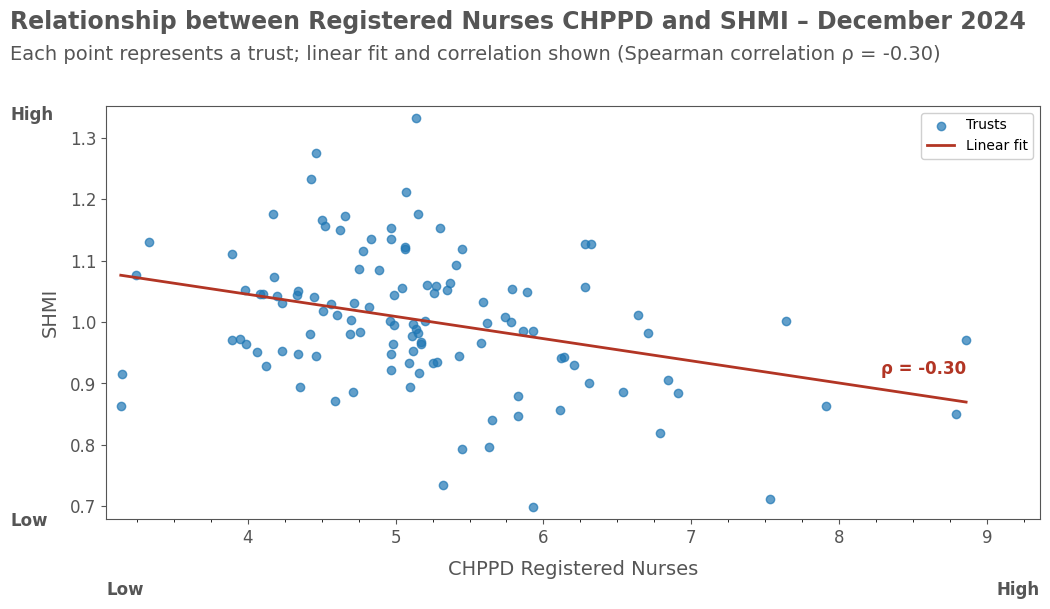

Processing month: 2025-01 (103 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2025_01.png


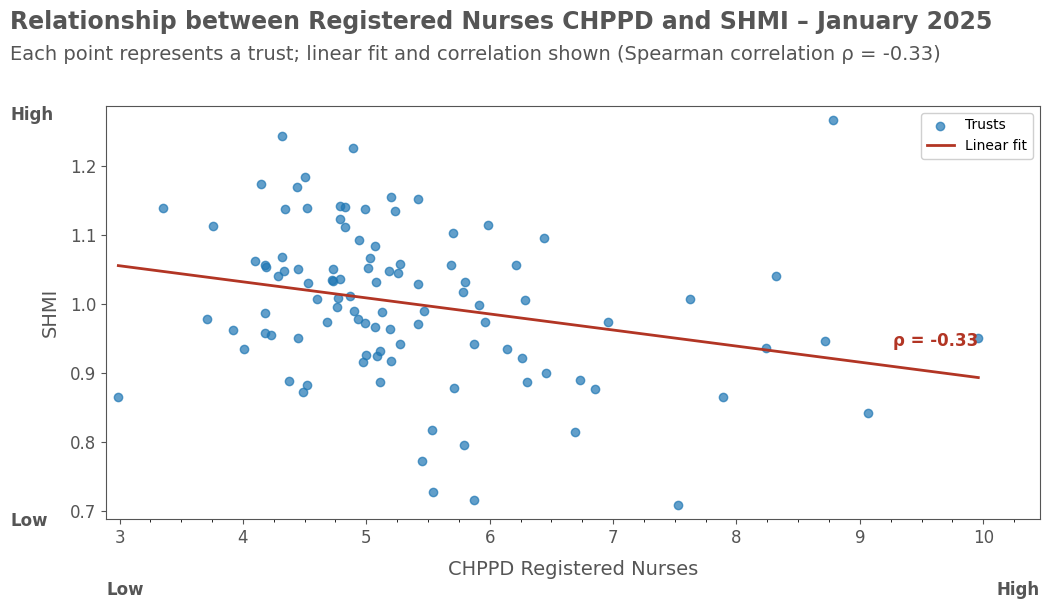

Processing month: 2025-02 (115 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2025_02.png


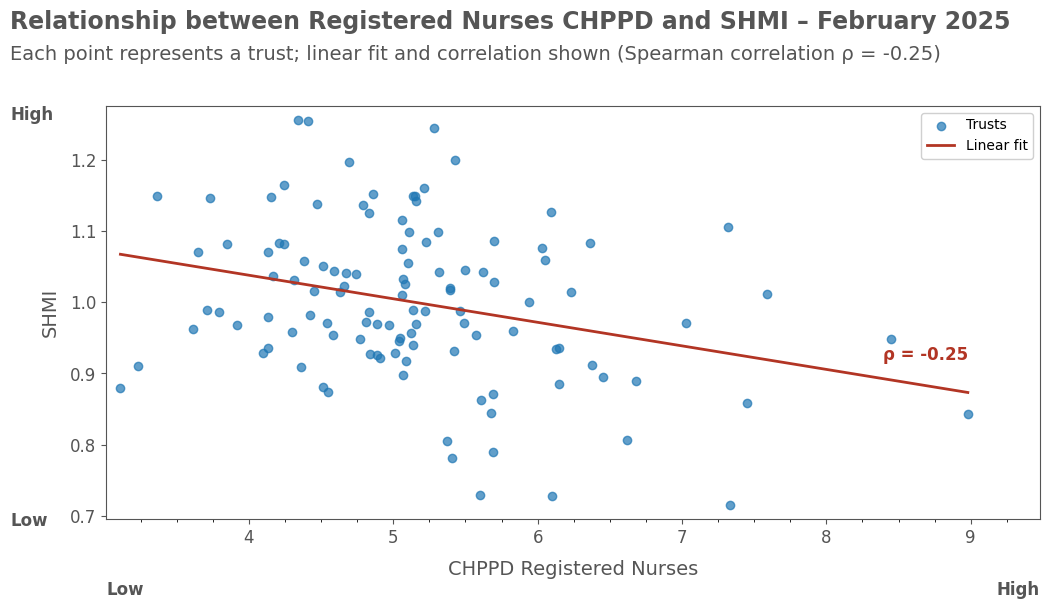

Processing month: 2025-03 (115 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2025_03.png


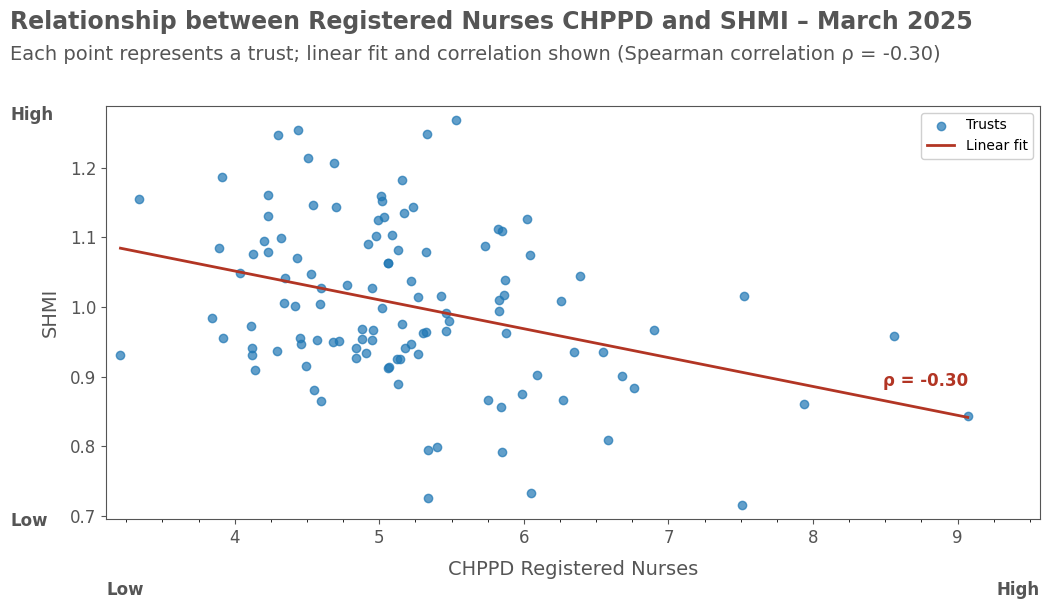

Processing month: 2025-04 (116 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2025_04.png


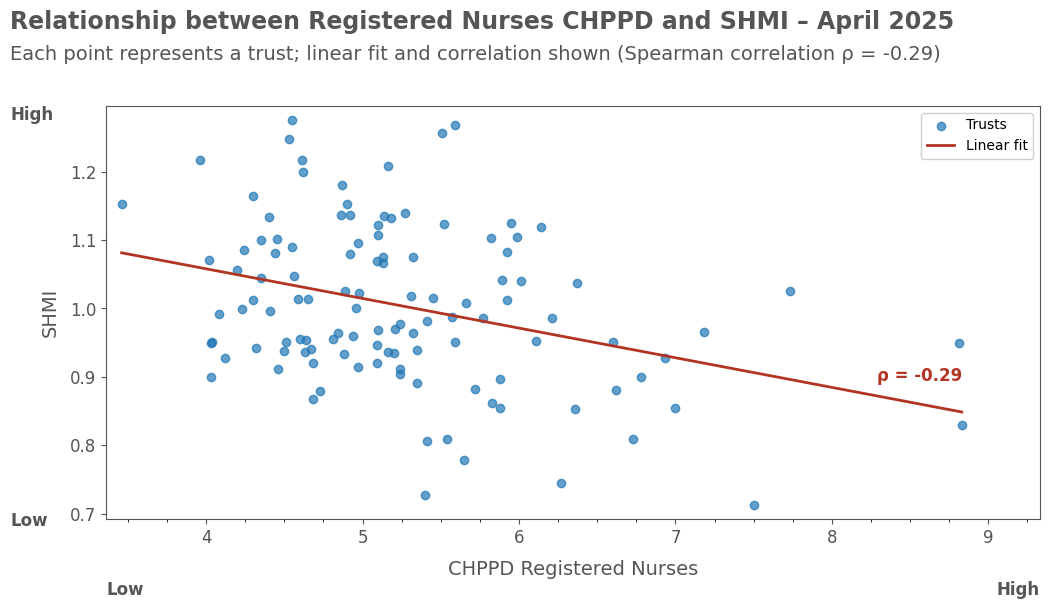

Processing month: 2025-05 (112 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2025_05.png


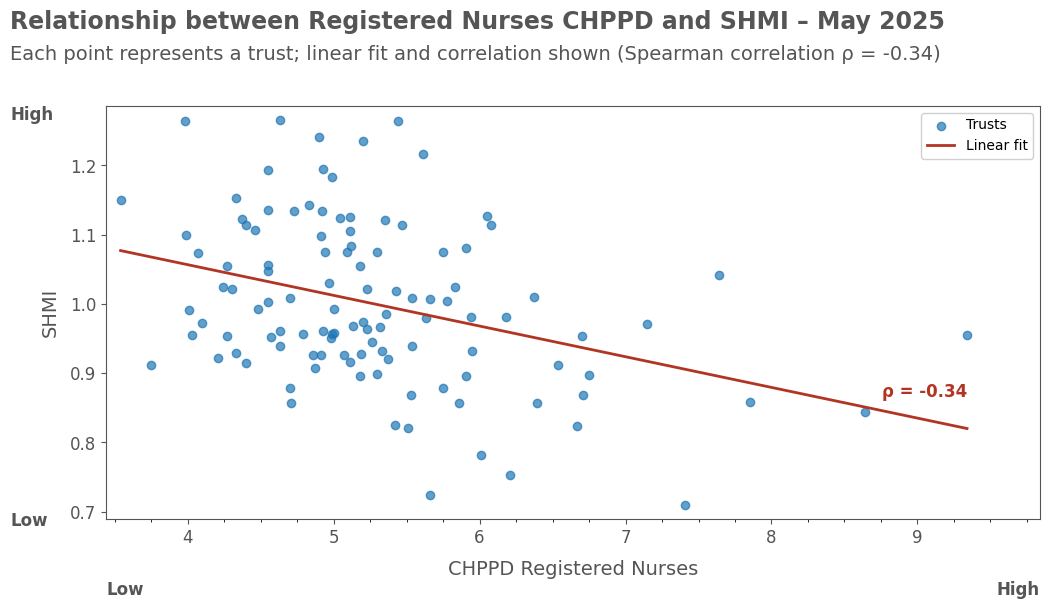

Processing month: 2025-06 (114 rows)
Saved Spearman plot to: /Users/e410675/Desktop/Plots/B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_2025_06.png


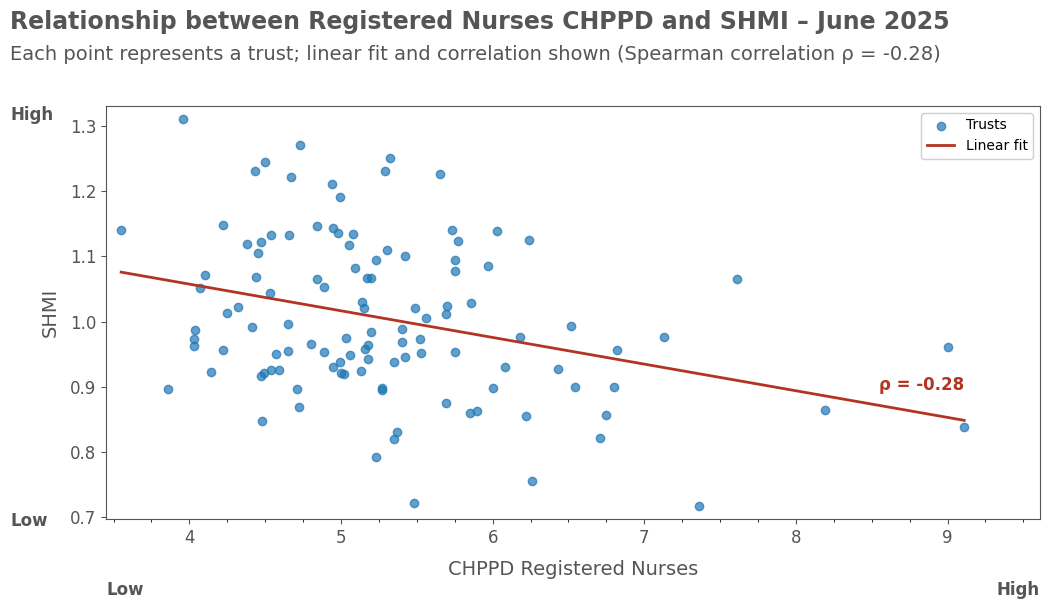

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os   # for saving
from scipy.stats import spearmanr
from matplotlib.ticker import MultipleLocator
import matplotlib.lines as mlines

# -----------------------------
# Styling constants (AfC-style)
# -----------------------------
YEAR_LABEL_GRAY = "#555555"


# -----------------------------
# Load and prepare the data
# -----------------------------
file_path = "chppd-smhi_merged filter with year month.csv"
df = pd.read_csv(file_path)

# Remove outliers where Overall CHPPD > 16
df_clean = df[df["CHPPD - Overall"] <= 16].copy()
removed_high = len(df) - len(df_clean)
print(f"Removed {removed_high} outlier rows with Overall CHPPD > 16.")

# Remove extreme low SHMI values (< 0.1)
before_shmi = len(df_clean)
df_clean = df_clean[df_clean["SHMI_VALUE"] >= 0.1].copy()
removed_low = before_shmi - len(df_clean)
print(f"Removed {removed_low} rows with SHMI < 0.1.")

df = df_clean.copy()

# Rename columns
df = df.rename(columns={
    "Organisation Name": "org_name",
    "CHPPD - Overall": "overall_chppd",
    "CHPPD – Registered Nurses and Midwives": "rnmid_chppd",
    "SHMI_VALUE": "shmi",
    "year_month": "date"
})

df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

os.makedirs(plot_save_path, exist_ok=True)

# -----------------------------
# LOOP FOR EACH MONTH
# -----------------------------
month_periods = sorted(df["date"].dt.to_period("M").unique())
print(f"Found {len(month_periods)} distinct months.")

for period in month_periods:

    mask = (df["date"].dt.to_period("M") == period)
    df_latest = df[mask].copy()

    if df_latest.empty or len(df_latest) < 2:
        continue

    latest_date = df_latest["date"].iloc[0]
    print(f"Processing month: {latest_date.strftime('%Y-%m')} ({len(df_latest)} rows)")

    # -----------------------------
    # Data
    # -----------------------------
    x = df_latest["rnmid_chppd"].values
    y = df_latest["shmi"].values

    # Linear regression (visual guide)
    m, b = np.polyfit(x, y, 1)

    # Spearman correlation
    rho_value, rho_p = spearmanr(x, y)

    # -----------------------------
    # Axis span
    # -----------------------------
    x_min_data = df_latest["rnmid_chppd"].min()
    x_max_data = df_latest["rnmid_chppd"].max()
    y_min_data = df_latest["shmi"].min()
    y_max_data = df_latest["shmi"].max()

    margin_x = 0.5
    margin_y = 0.02

    # -----------------------------
    # Plot
    # -----------------------------
    fig, ax = plt.subplots(figsize=(11, 7))
    fig.patch.set_facecolor("white")

    blue_color = "#1f77b4"
    red_color = "#b23524"

    all_scatter = ax.scatter(
        df_latest["rnmid_chppd"], df_latest["shmi"],
        alpha=0.7, color=blue_color, label="Trusts"
    )

    x_fit = np.linspace(x_min_data, x_max_data, 200)
    y_fit = m * x_fit + b

    reg_line, = ax.plot(
        x_fit, y_fit,
        linewidth=2, color=red_color, label="Linear fit"
    )

    # -----------------------------
    # ρ label at end of regression line
    # -----------------------------
    x_r = x_fit.max()
    y_r = m * x_r + b

    ax.text(
        x_r,
        y_r + 0.04,
        f"ρ = {rho_value:.2f}",
        color=red_color,
        fontsize=12, fontweight="bold",
        ha="right", va="bottom"
    )

    # -----------------------------
    # Axis limits
    # -----------------------------
    ax.set_xlim(x_min_data - 0.1, x_max_data + margin_x)
    ax.set_ylim(y_min_data - margin_y, y_max_data + margin_y)

    # Axis styling
    ax.set_xlabel(
        "CHPPD Registered Nurses",
        color=YEAR_LABEL_GRAY, fontsize=14
    )
    ax.xaxis.set_label_coords(0.5, -0.10)

    ax.tick_params(axis="x", labelsize=12, colors=YEAR_LABEL_GRAY)
    ax.tick_params(axis="y", labelsize=12, colors=YEAR_LABEL_GRAY)

    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))

    for side in ["top", "right", "left", "bottom"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color(YEAR_LABEL_GRAY)

    # -----------------------------
    # Titles
    # -----------------------------
    main_title = (
        f"Relationship between Registered Nurses CHPPD and SHMI – "
        f"{latest_date.strftime('%B %Y')}"
    )

    subtitle = (
        f"Each point represents a trust; linear fit and correlation shown "
        f"(Spearman correlation ρ = {rho_value:.2f})"
    )

    fig.suptitle(main_title, x=0.03, y=0.96,
                 ha="left", fontsize=17, fontweight="bold",
                 color=YEAR_LABEL_GRAY)

    fig.text(0.03, 0.91, subtitle,
             ha="left", va="top", fontsize=14, color=YEAR_LABEL_GRAY)

    # Side labels
    fig.text(0.03, 0.81, "High", ha="left", va="center",
             fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY)
    fig.text(0.03, 0.23, "Low", ha="left", va="center",
             fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY)

    ax.text(-0.06, 0.5, "SHMI",
            transform=ax.transAxes,
            rotation=90, ha="center", va="center",
            fontsize=14, color=YEAR_LABEL_GRAY)

    ax.text(0.0, -0.15, "Low",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY)

    ax.text(1.0, -0.15, "High",
            transform=ax.transAxes, ha="right", va="top",
            fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY)

    # Legend
    ax.legend(
        handles=[all_scatter, reg_line],
        loc="upper right",
        frameon=True,
        facecolor="#FFFFFF",
        edgecolor="#d0d0d0",
        framealpha=1.0,
    )

    fig.subplots_adjust(left=0.15)
    plt.tight_layout(rect=[0.05, 0.07, 0.98, 0.9])

    # -----------------------------
    # Save plot
    # -----------------------------
    month_str = latest_date.strftime("%Y_%m")
    filename = f"B1_RNMid_CHPPD_SHMI_Scatter_Regression_Spearman_{month_str}.png"
    save_path = os.path.join(plot_save_path, filename)

    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    print(f"Saved Spearman plot to: {save_path}")

    plt.show(fig)


Removed 22 outlier rows with Overall CHPPD > 16.
Removed 4 rows with SHMI < 0.1.
Found 54 distinct months in the data.
Processing month: 2020-12 (113 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2020_12.png


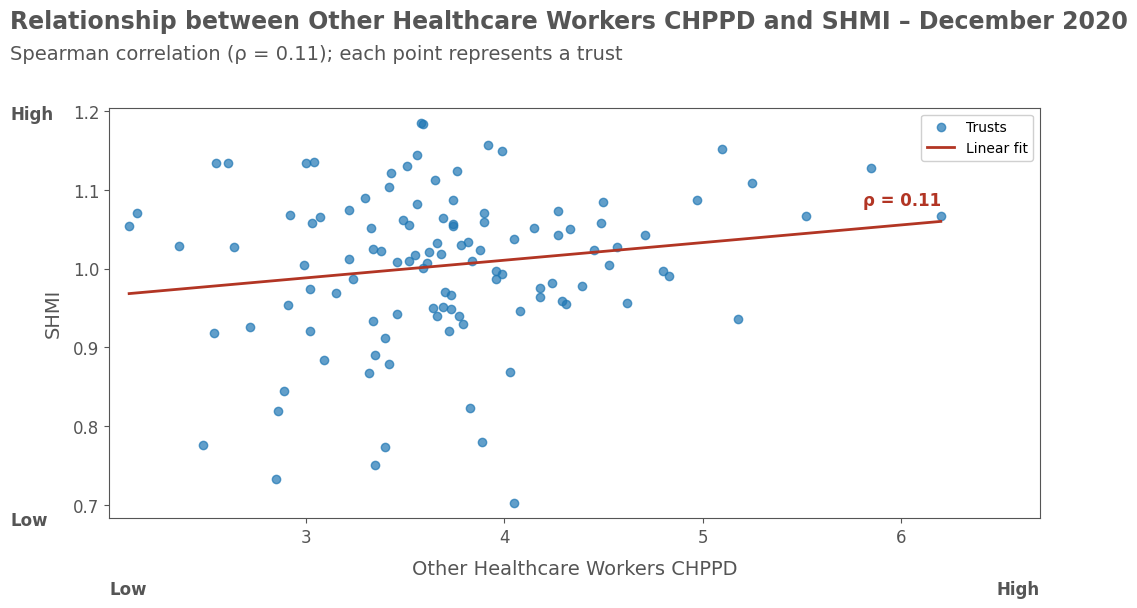

Processing month: 2021-01 (110 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_01.png


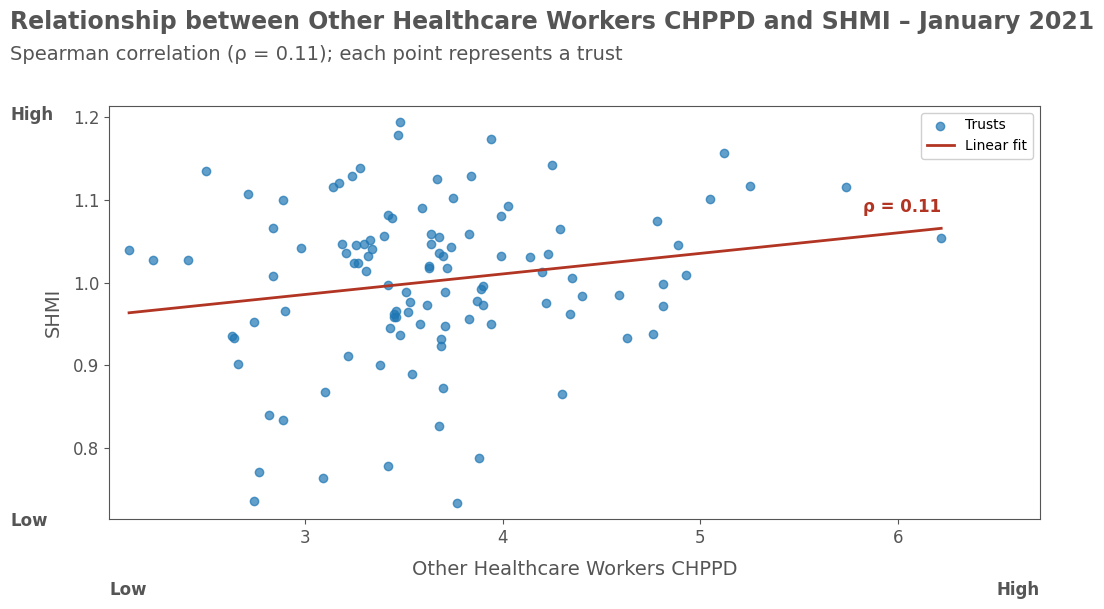

Processing month: 2021-02 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_02.png


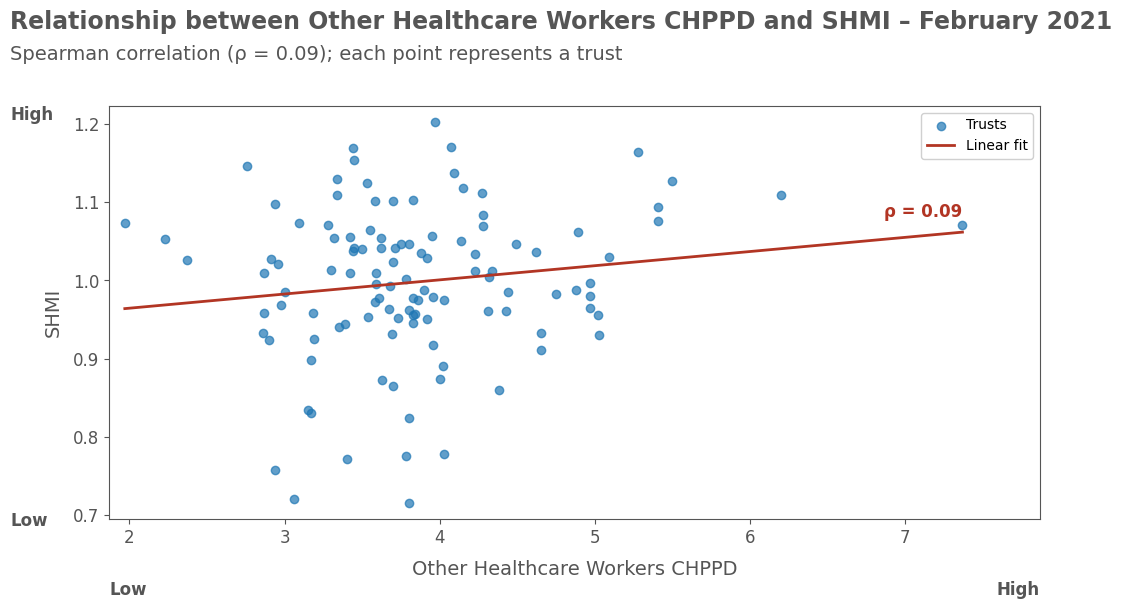

Processing month: 2021-03 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_03.png


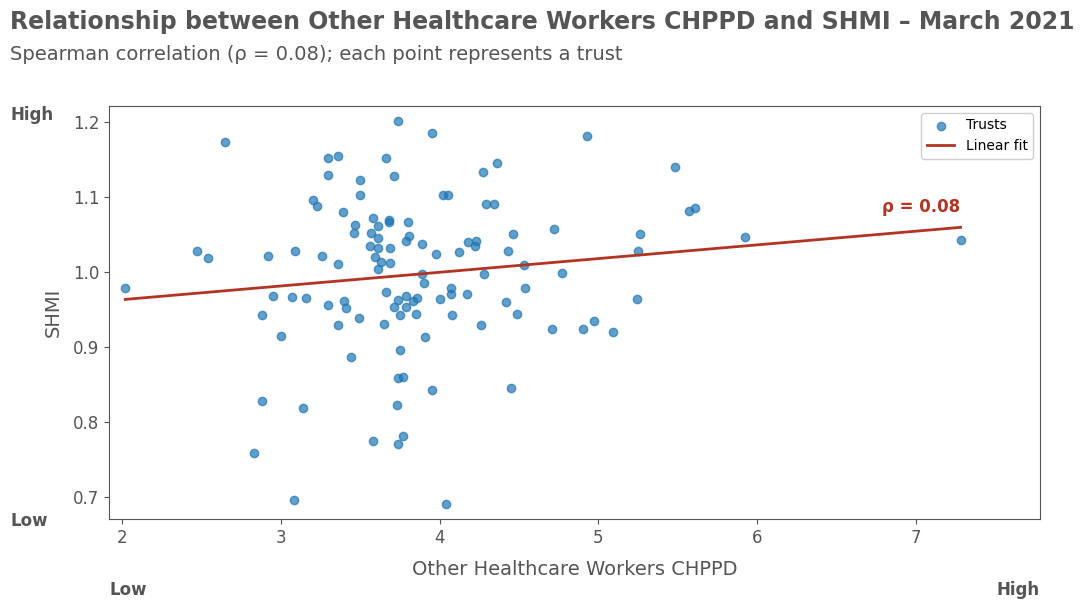

Processing month: 2021-04 (118 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_04.png


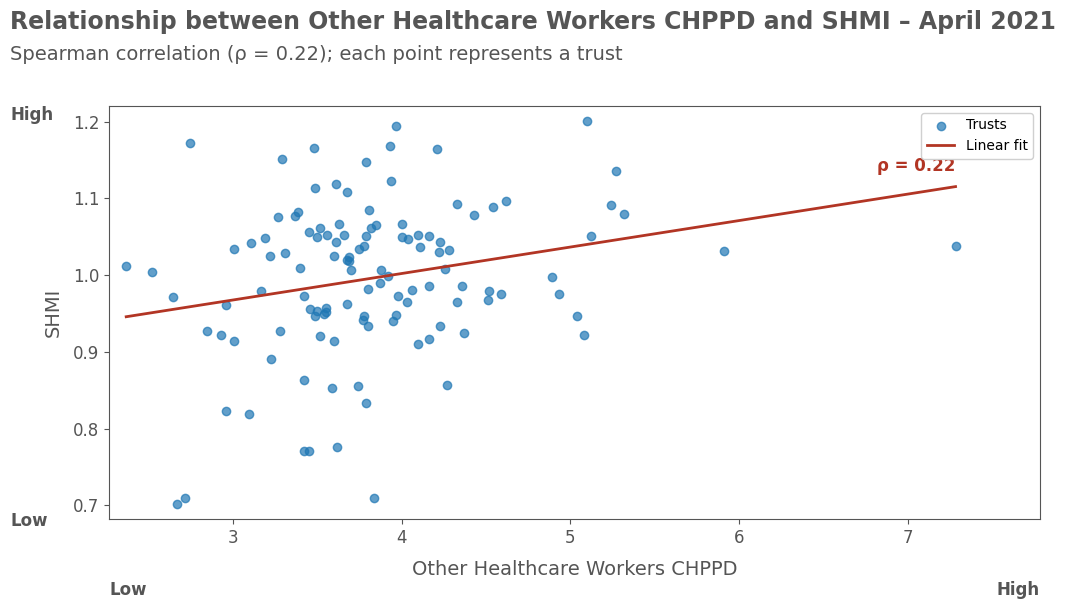

Processing month: 2021-05 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_05.png


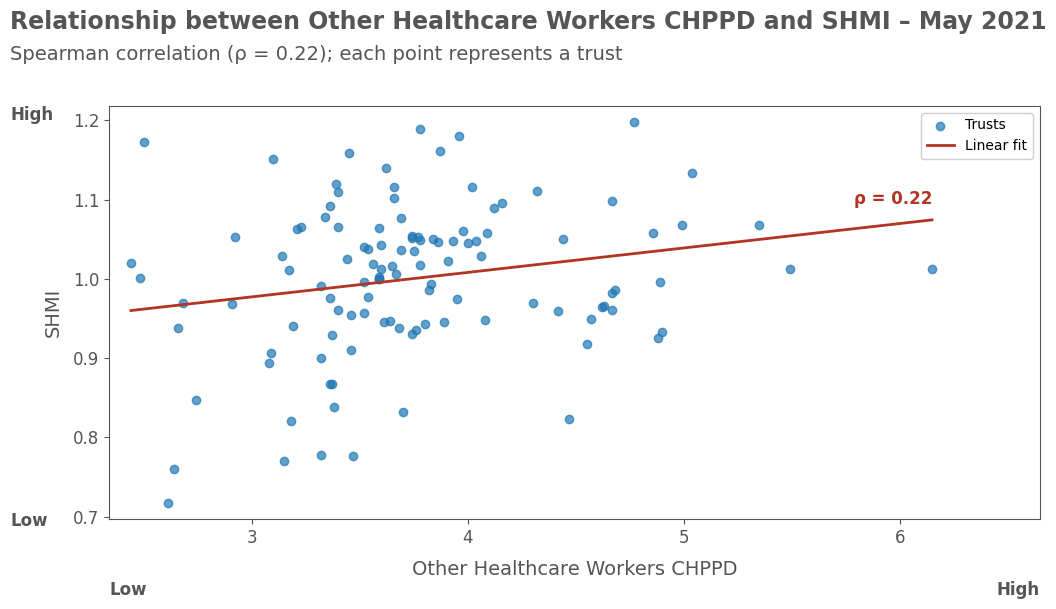

Processing month: 2021-06 (117 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_06.png


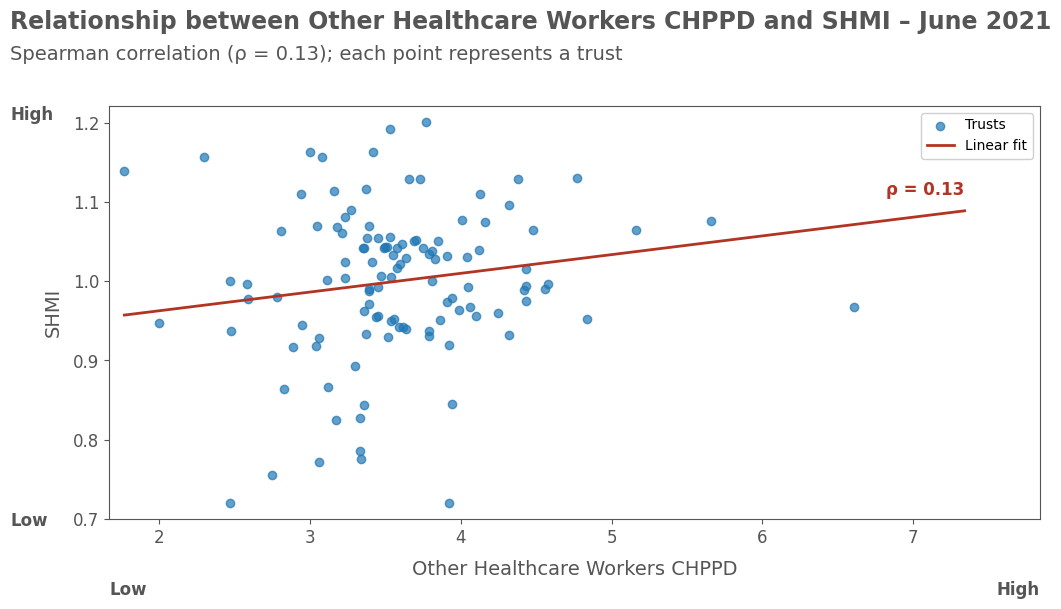

Processing month: 2021-08 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_08.png


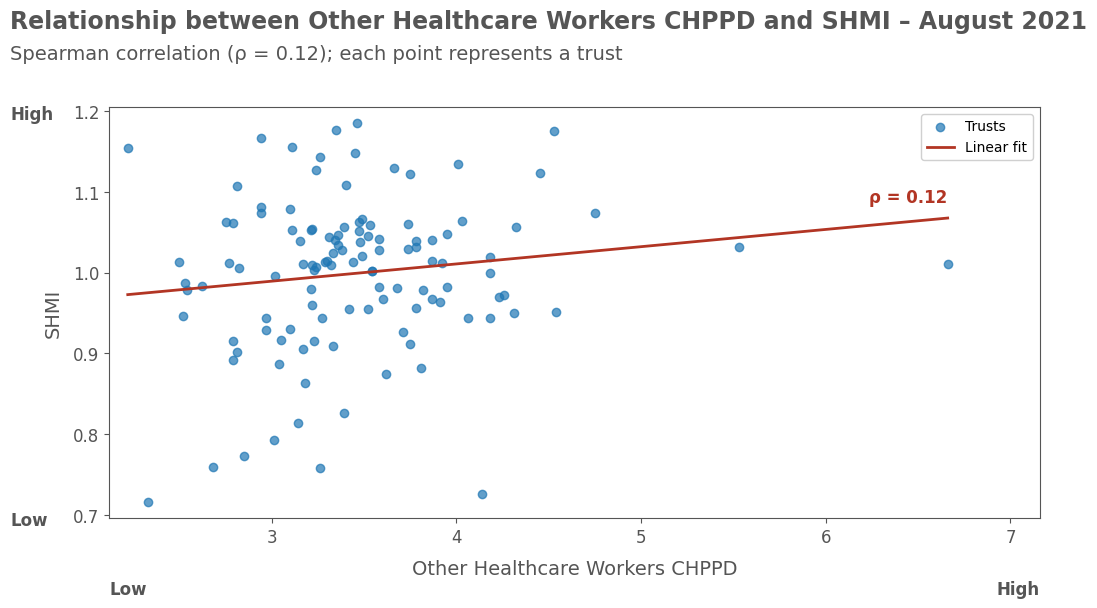

Processing month: 2021-09 (115 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_09.png


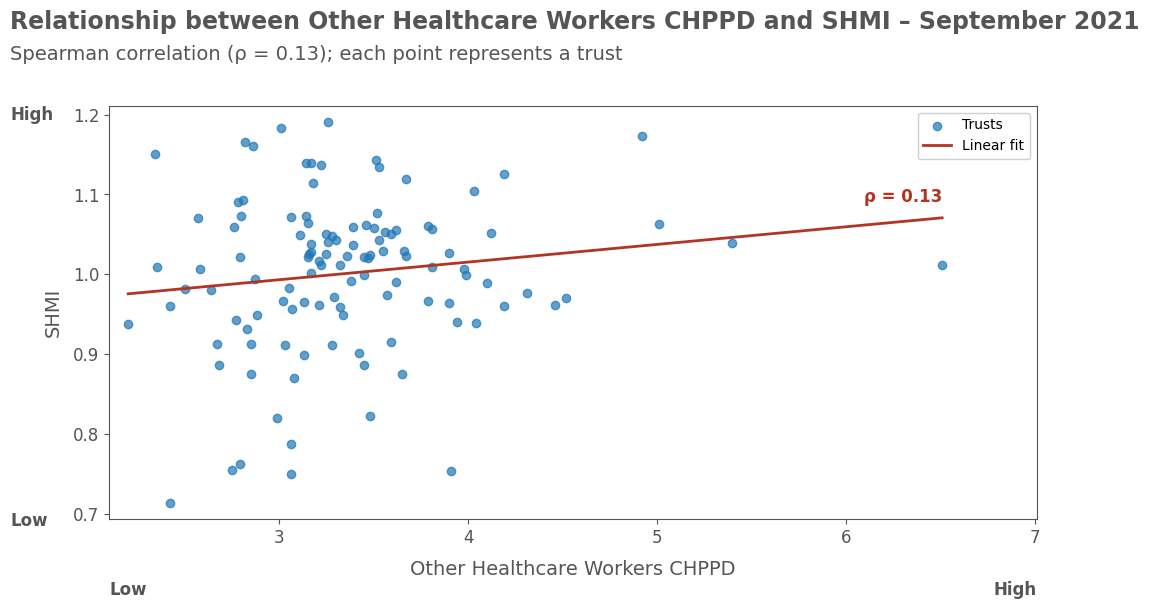

Processing month: 2021-10 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_10.png


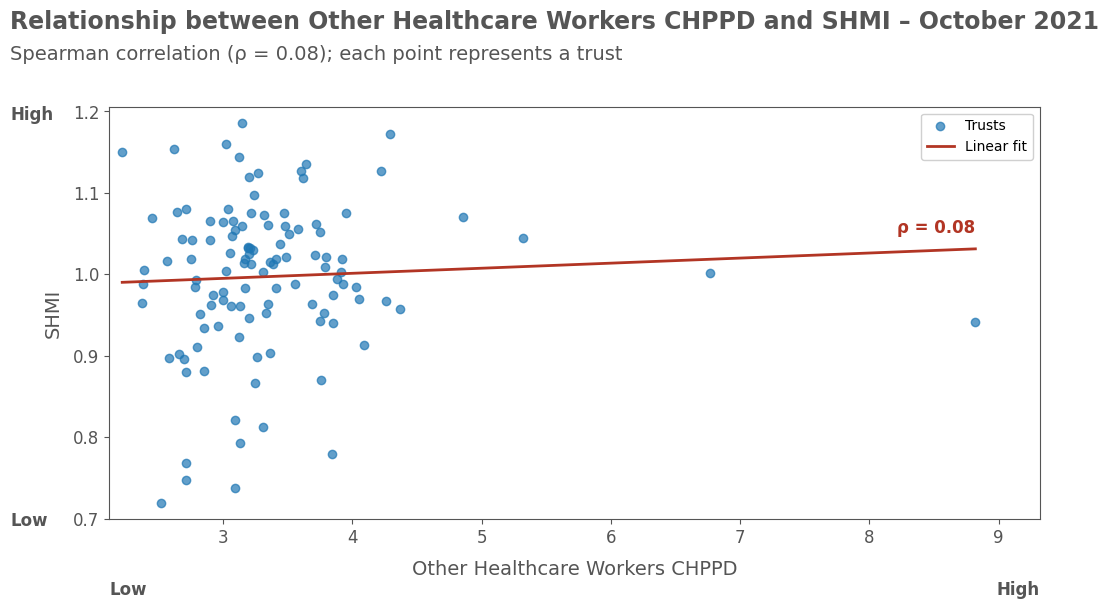

Processing month: 2021-11 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_11.png


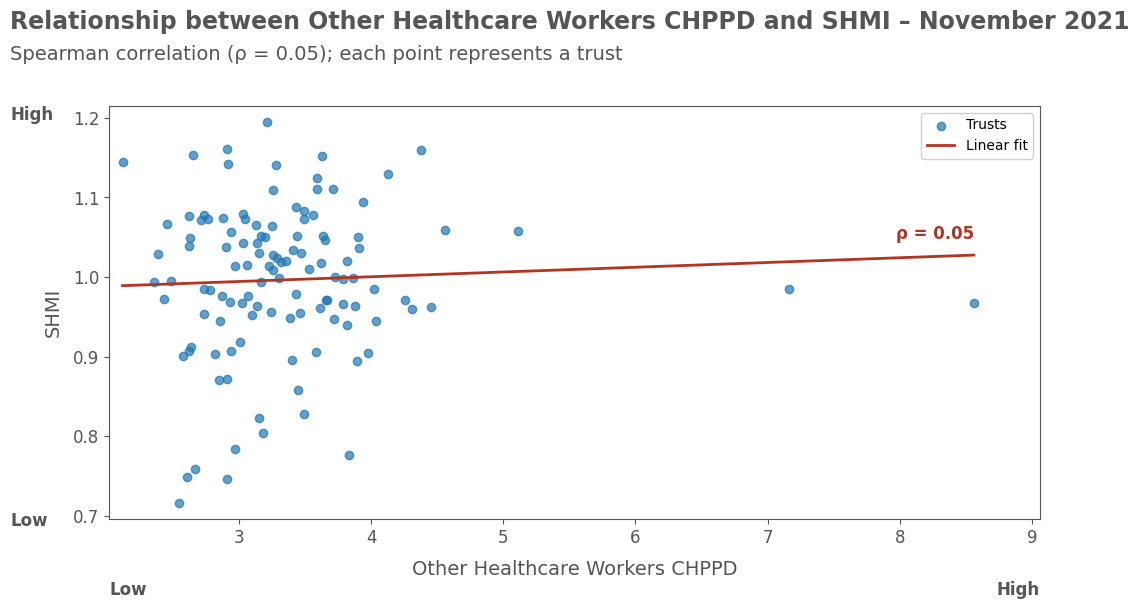

Processing month: 2021-12 (117 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2021_12.png


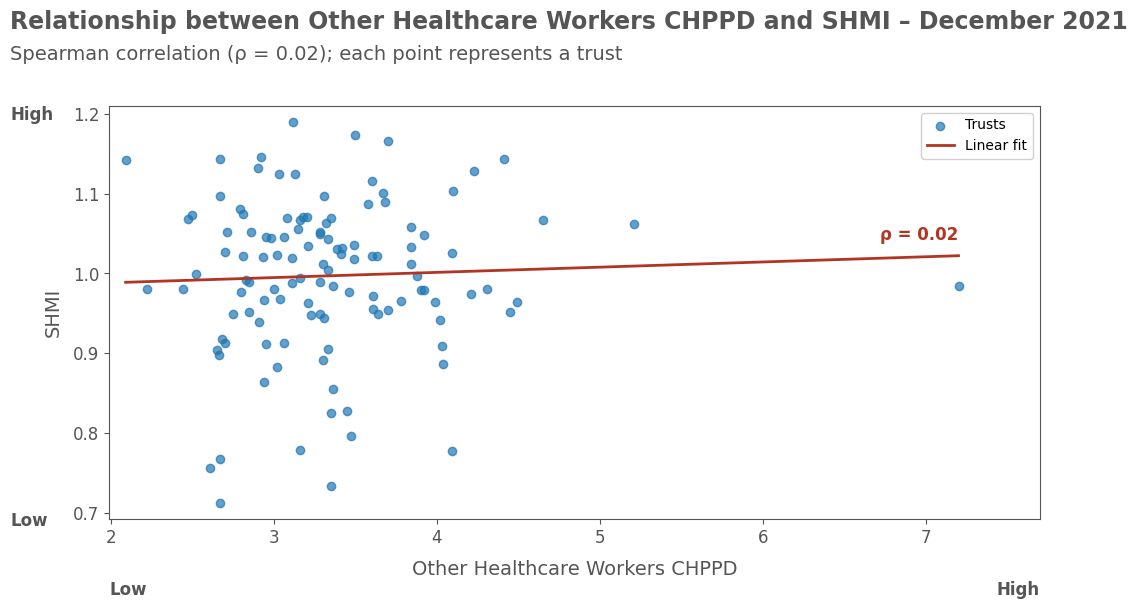

Processing month: 2022-01 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_01.png


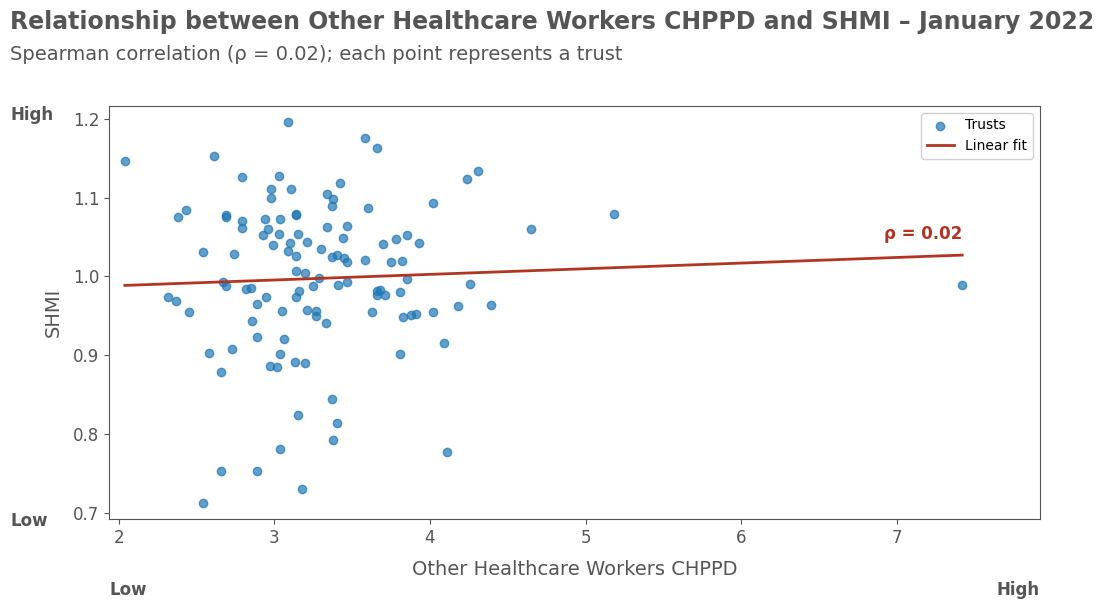

Processing month: 2022-02 (117 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_02.png


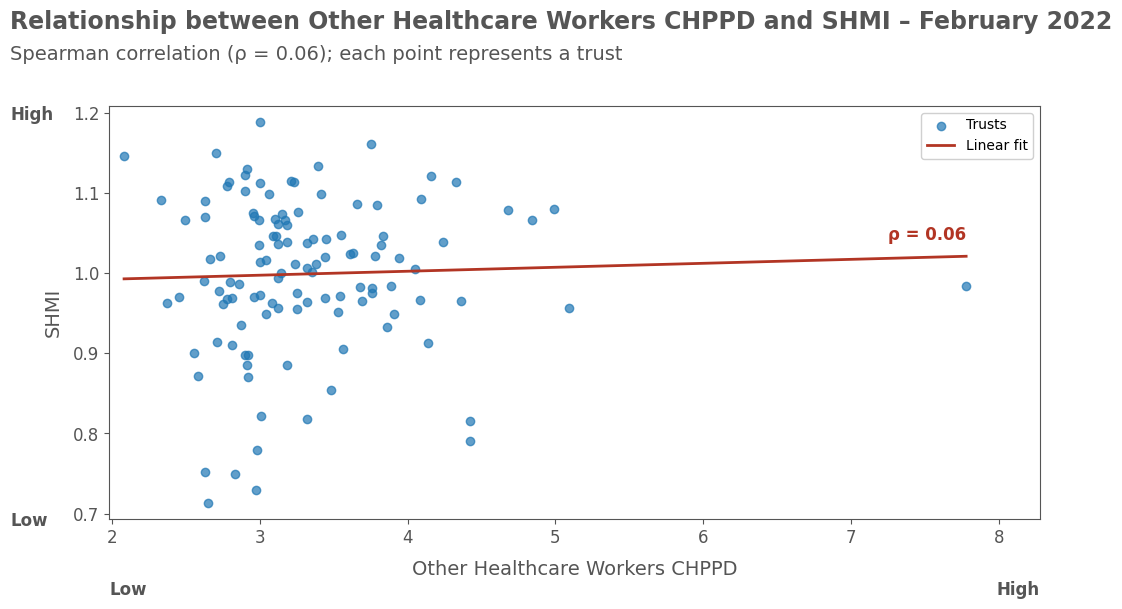

Processing month: 2022-03 (117 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_03.png


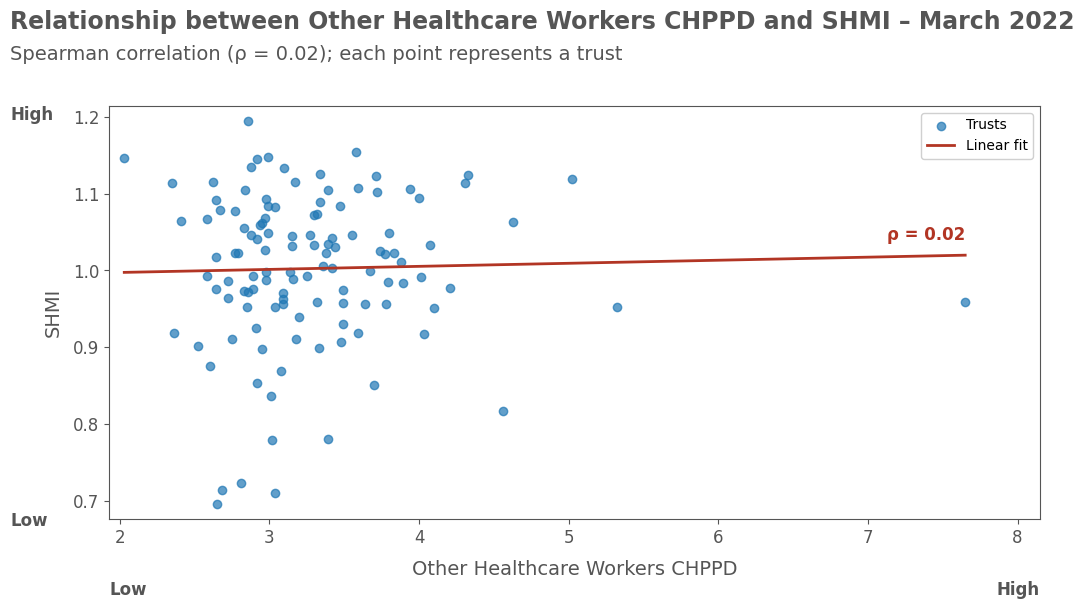

Processing month: 2022-04 (115 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_04.png


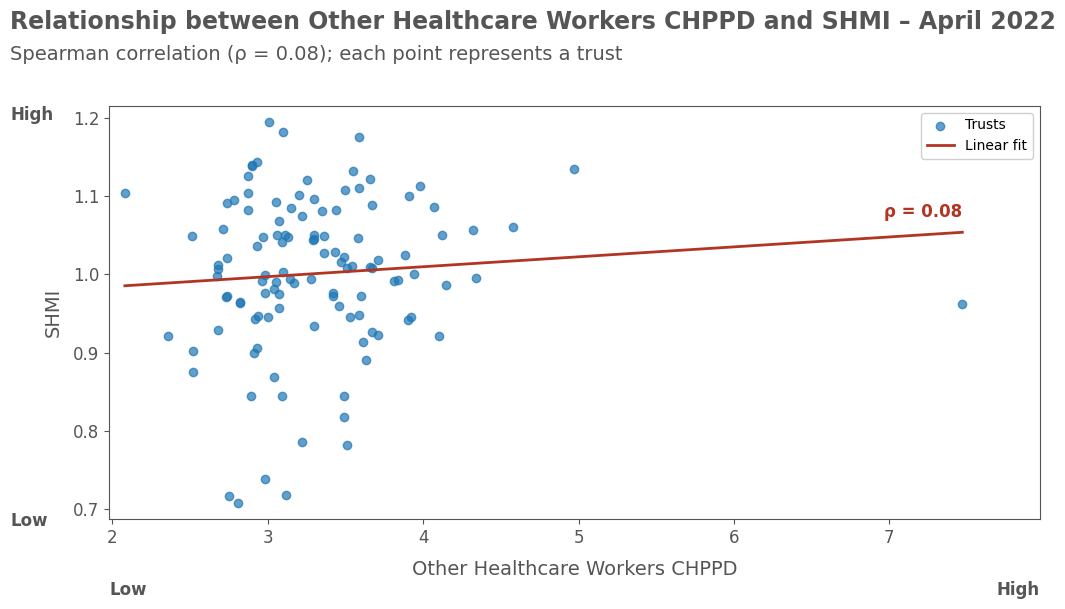

Processing month: 2022-05 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_05.png


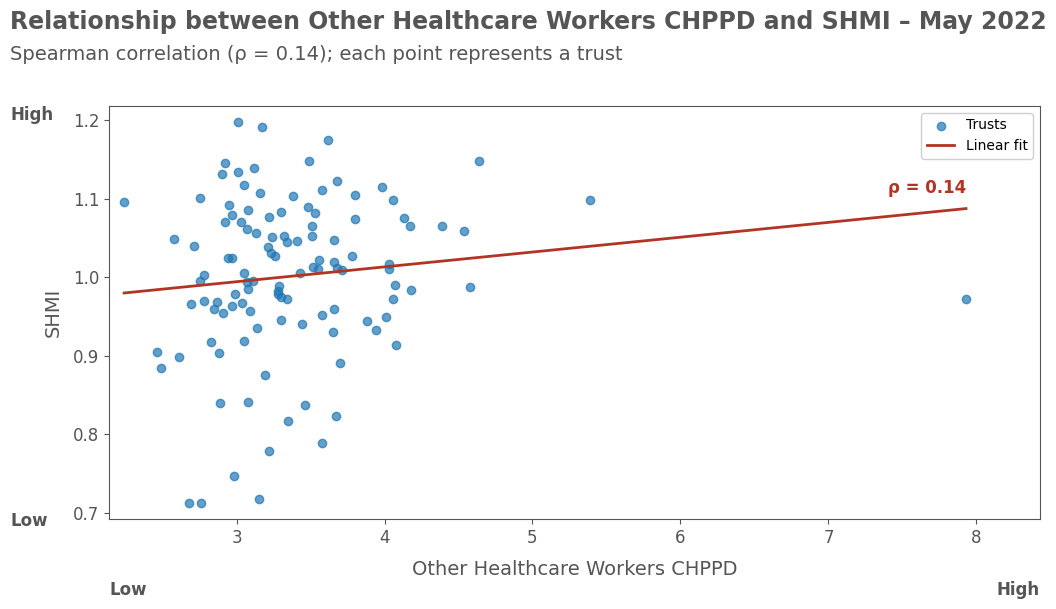

Processing month: 2022-06 (110 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_06.png


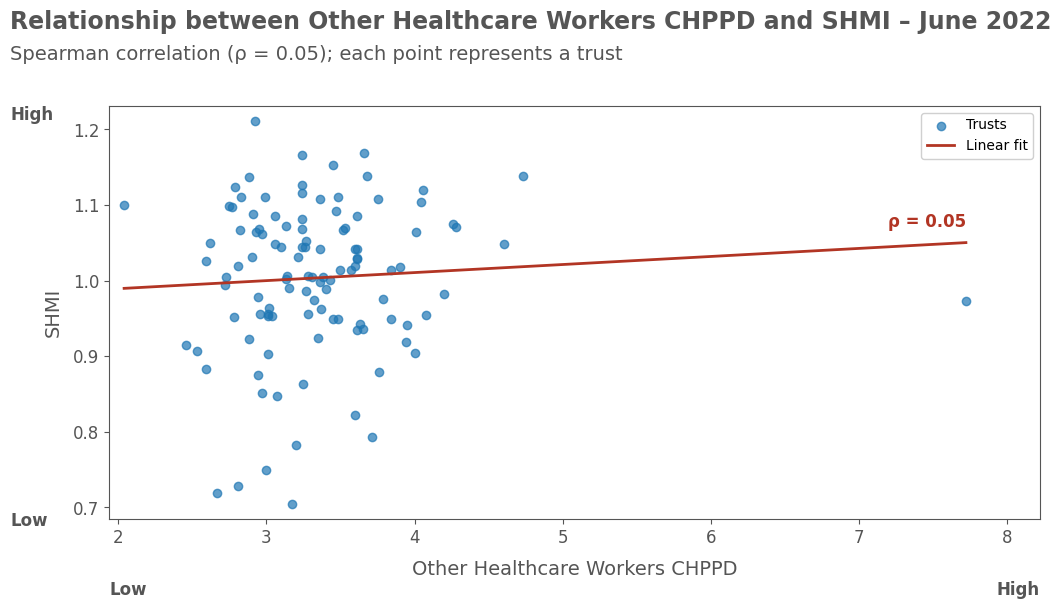

Processing month: 2022-07 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_07.png


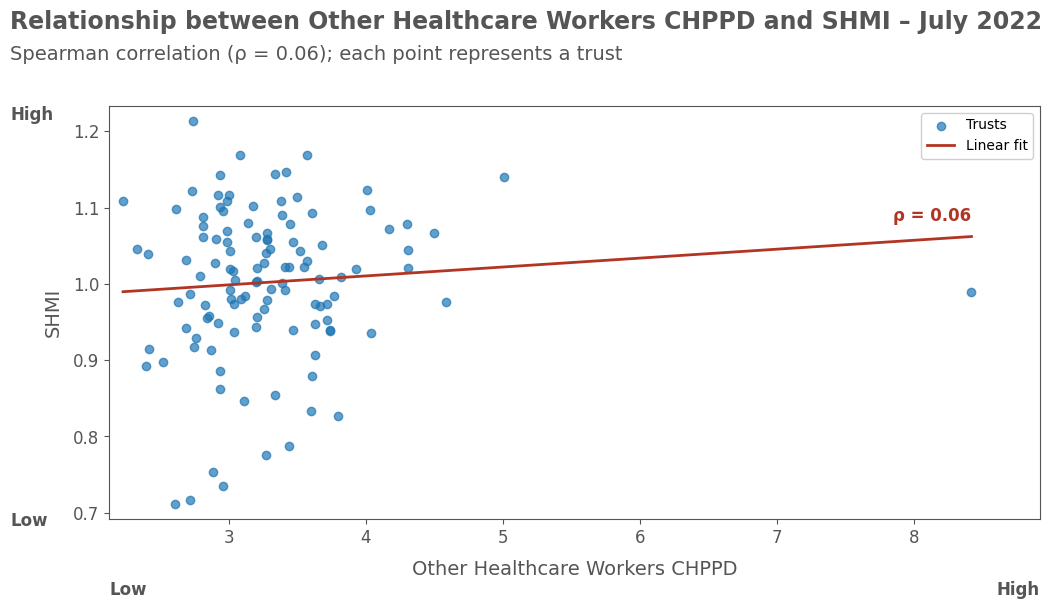

Processing month: 2022-08 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_08.png


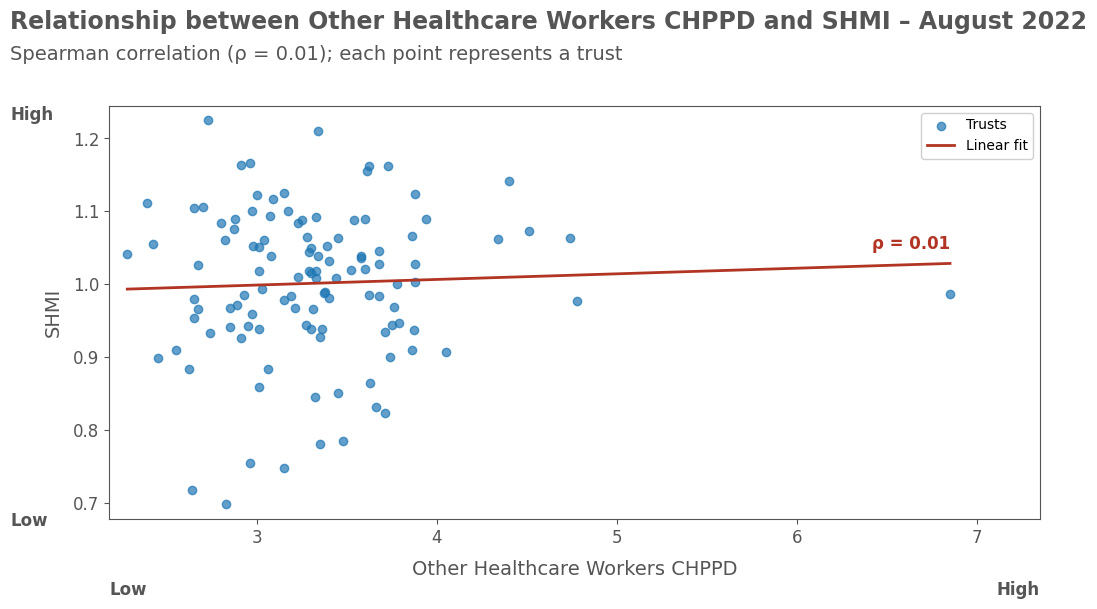

Processing month: 2022-09 (112 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_09.png


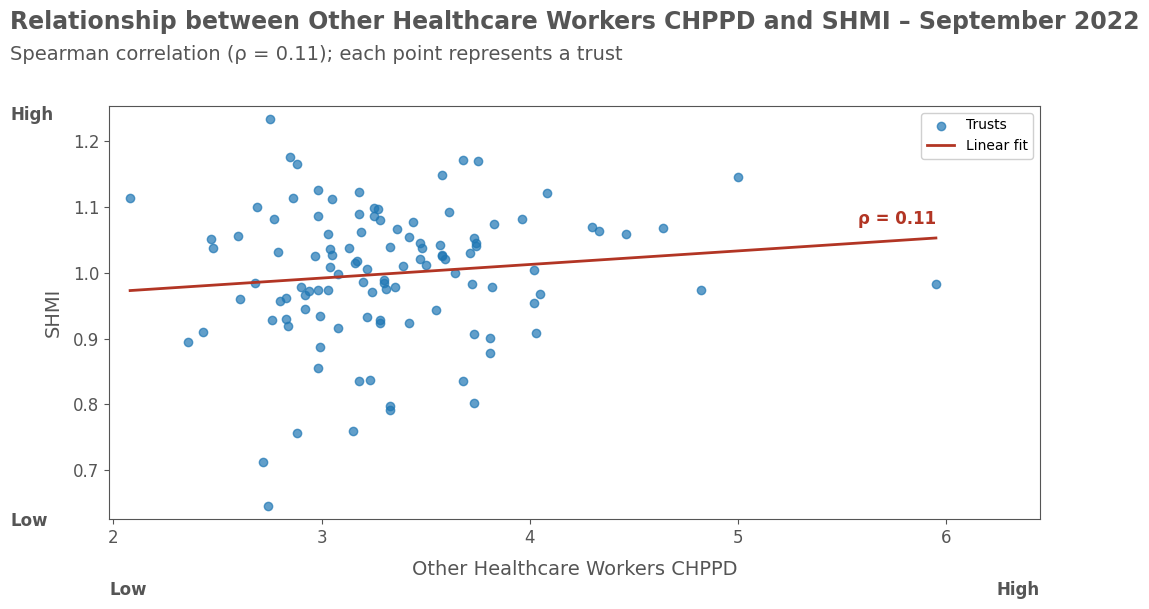

Processing month: 2022-10 (118 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_10.png


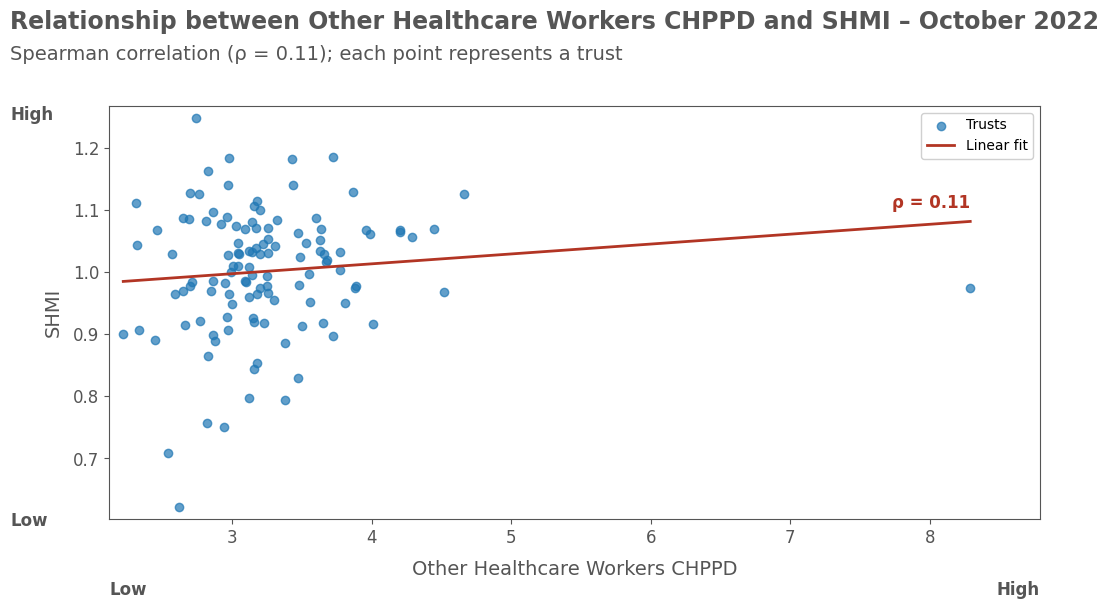

Processing month: 2022-11 (118 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_11.png


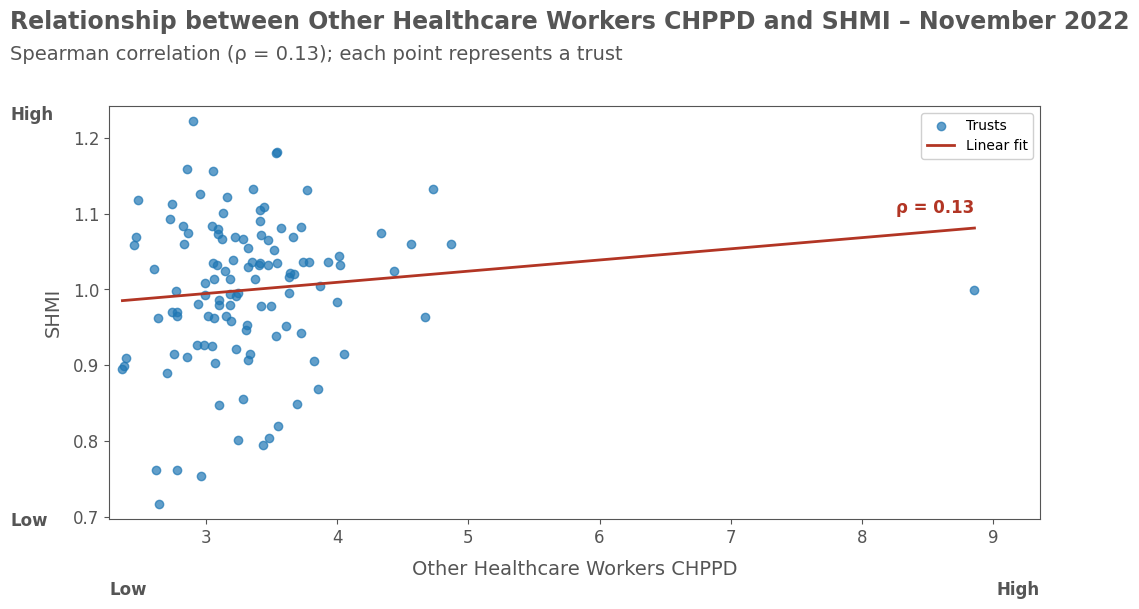

Processing month: 2022-12 (118 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2022_12.png


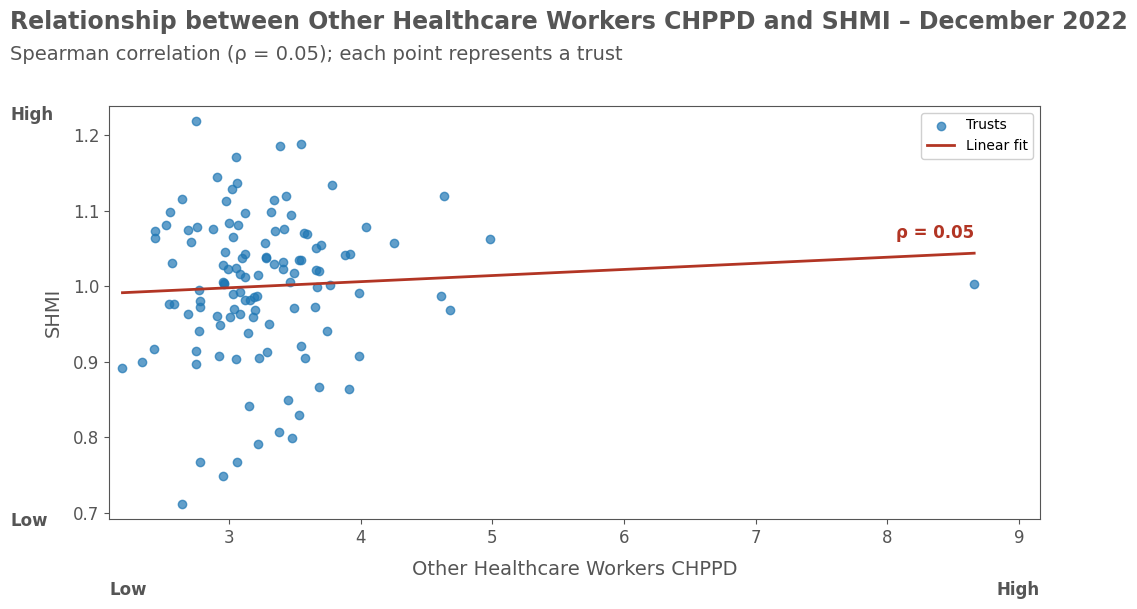

Processing month: 2023-01 (111 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_01.png


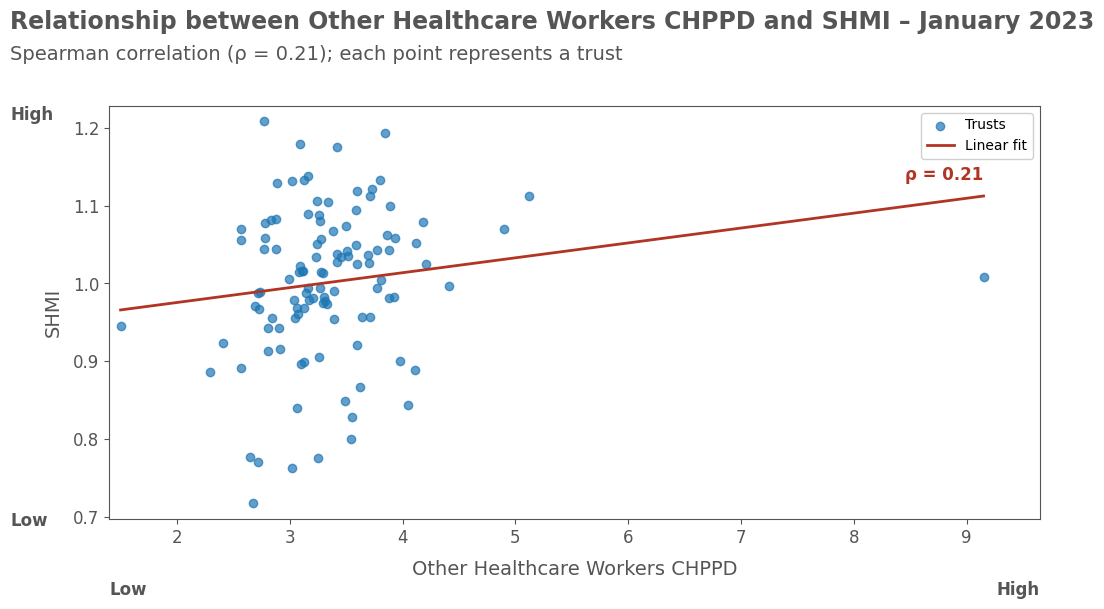

Processing month: 2023-02 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_02.png


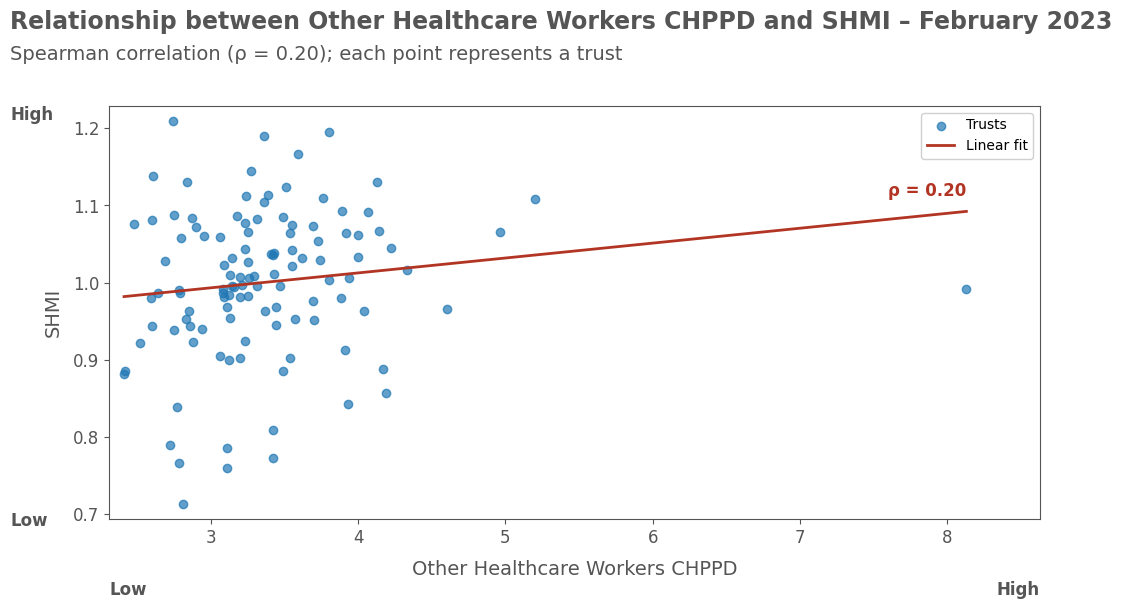

Processing month: 2023-03 (117 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_03.png


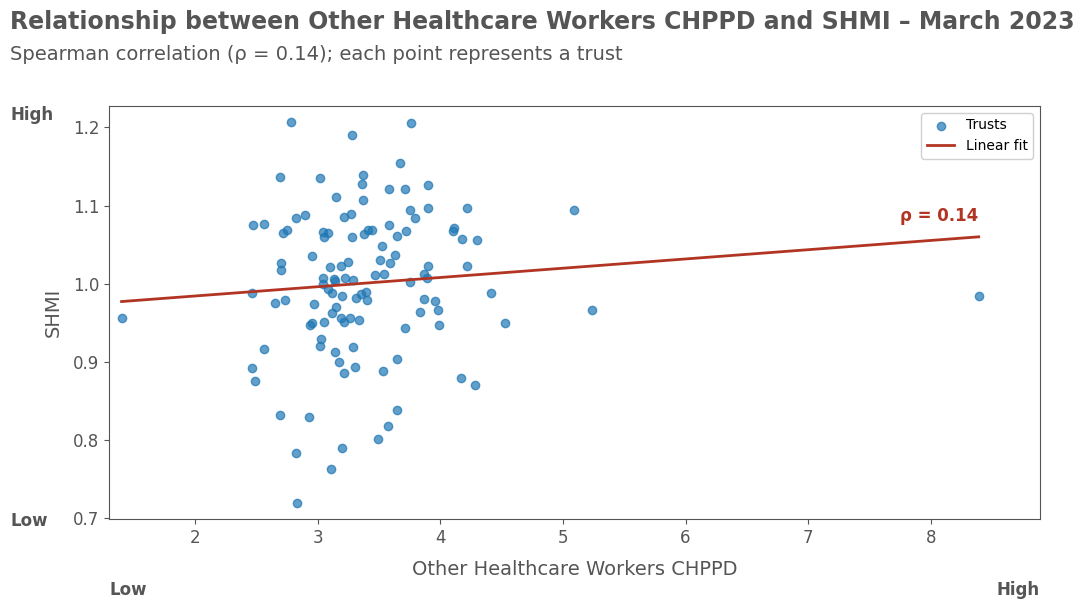

Processing month: 2023-04 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_04.png


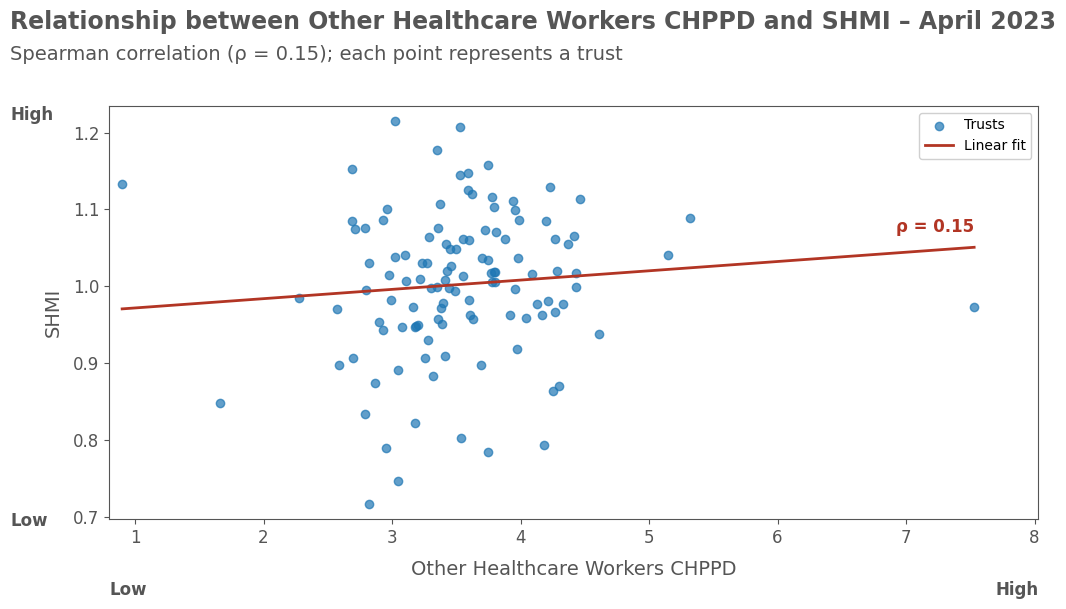

Processing month: 2023-05 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_05.png


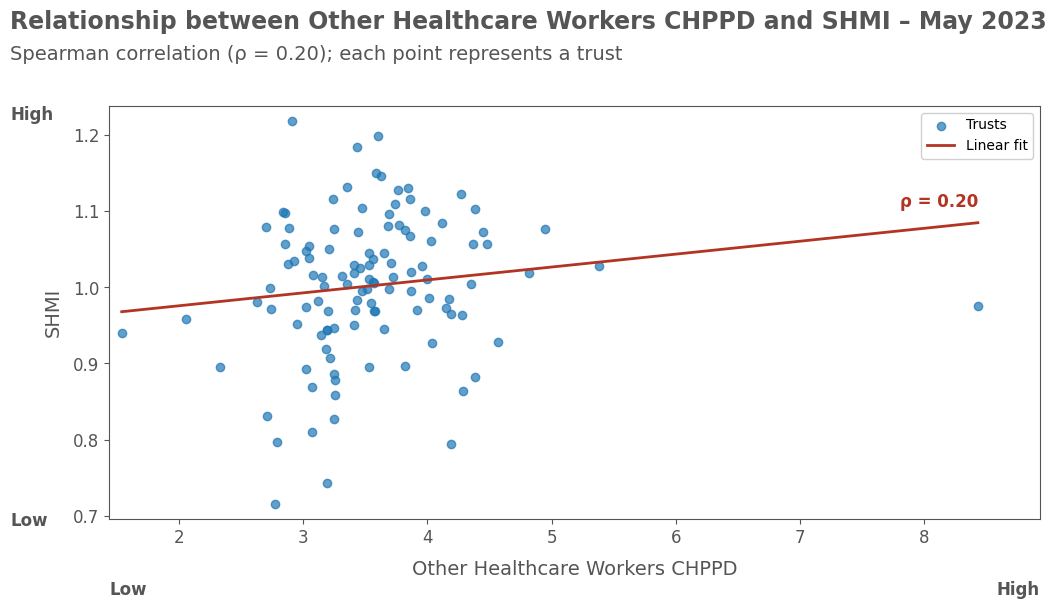

Processing month: 2023-06 (117 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_06.png


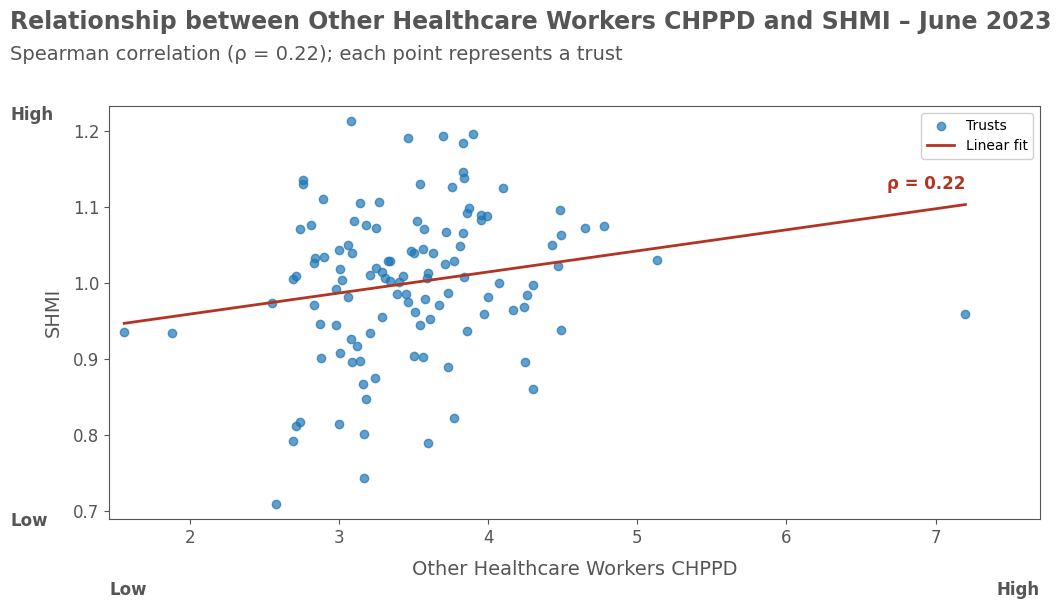

Processing month: 2023-07 (115 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_07.png


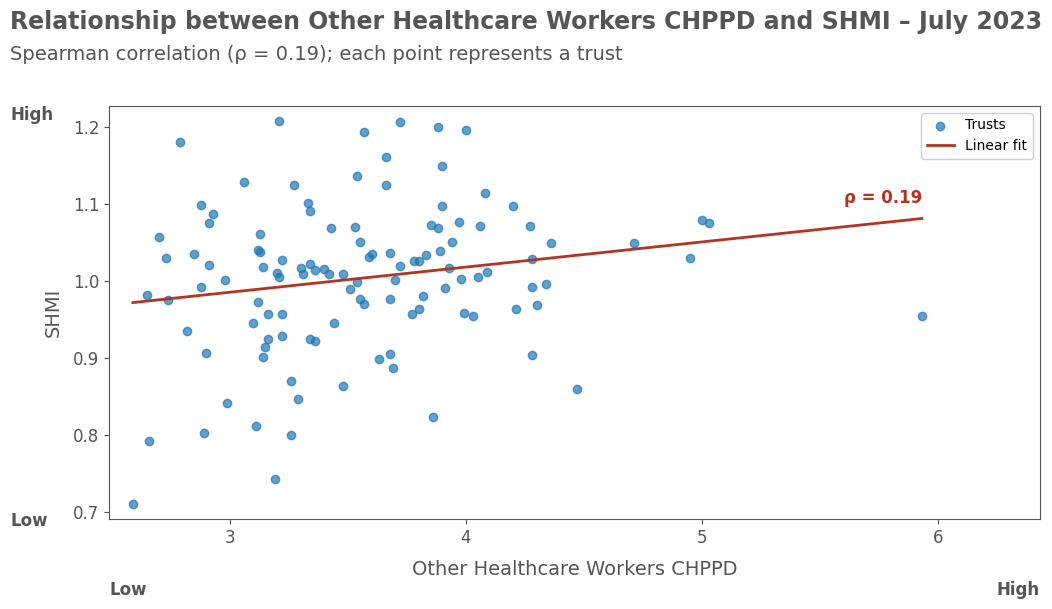

Processing month: 2023-08 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_08.png


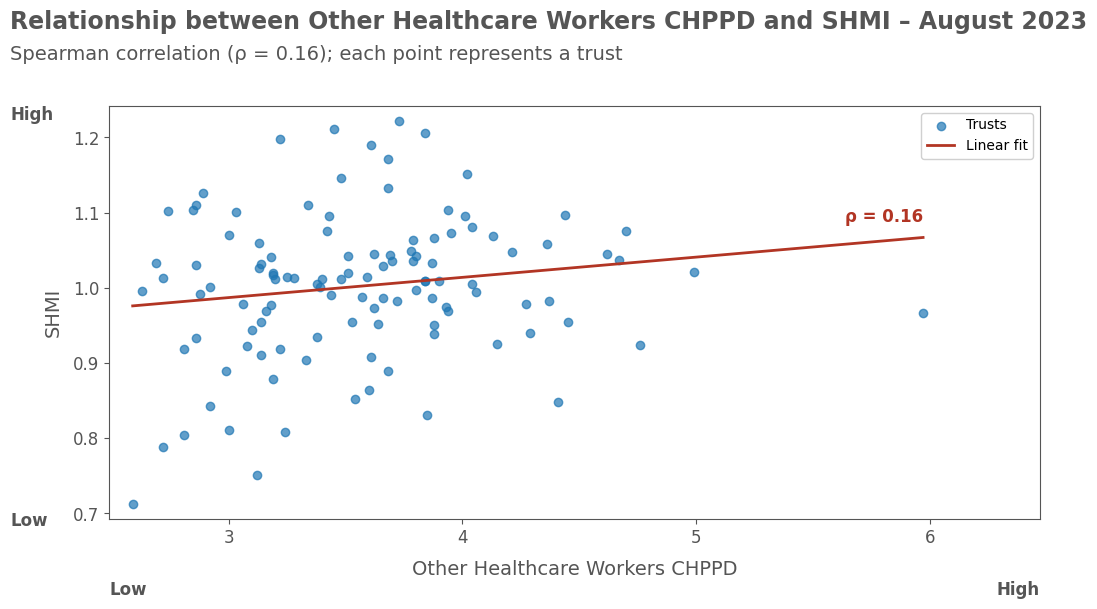

Processing month: 2023-09 (115 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_09.png


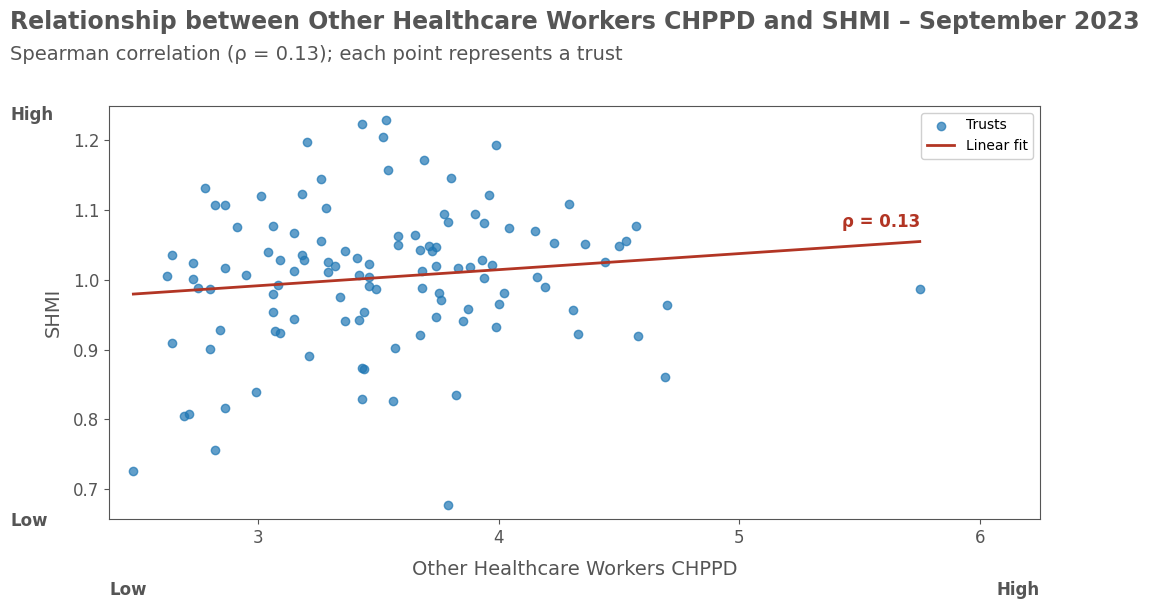

Processing month: 2023-10 (115 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_10.png


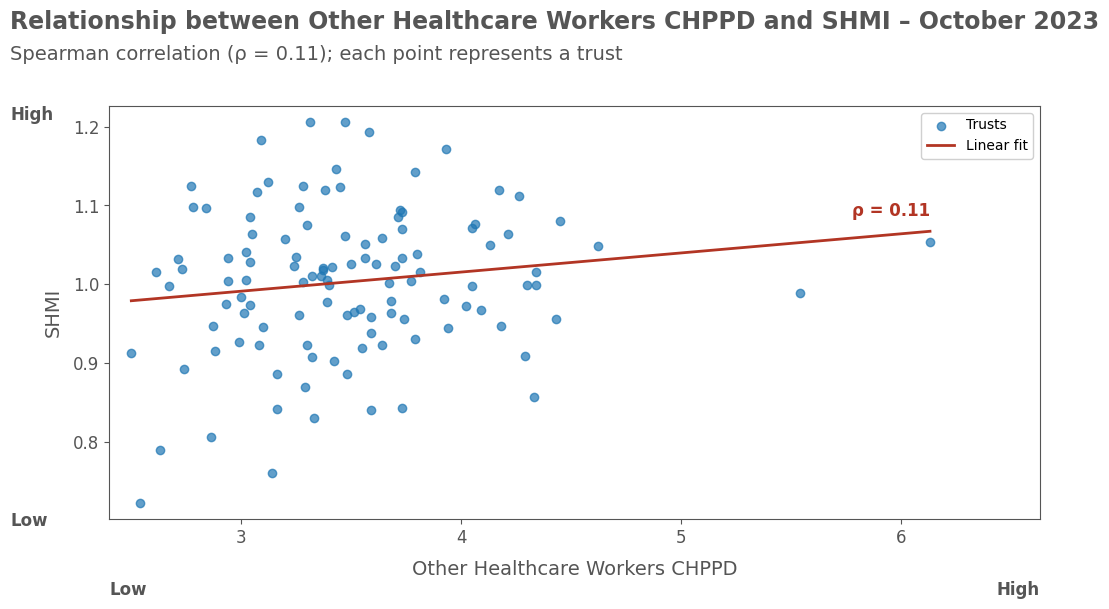

Processing month: 2023-11 (113 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_11.png


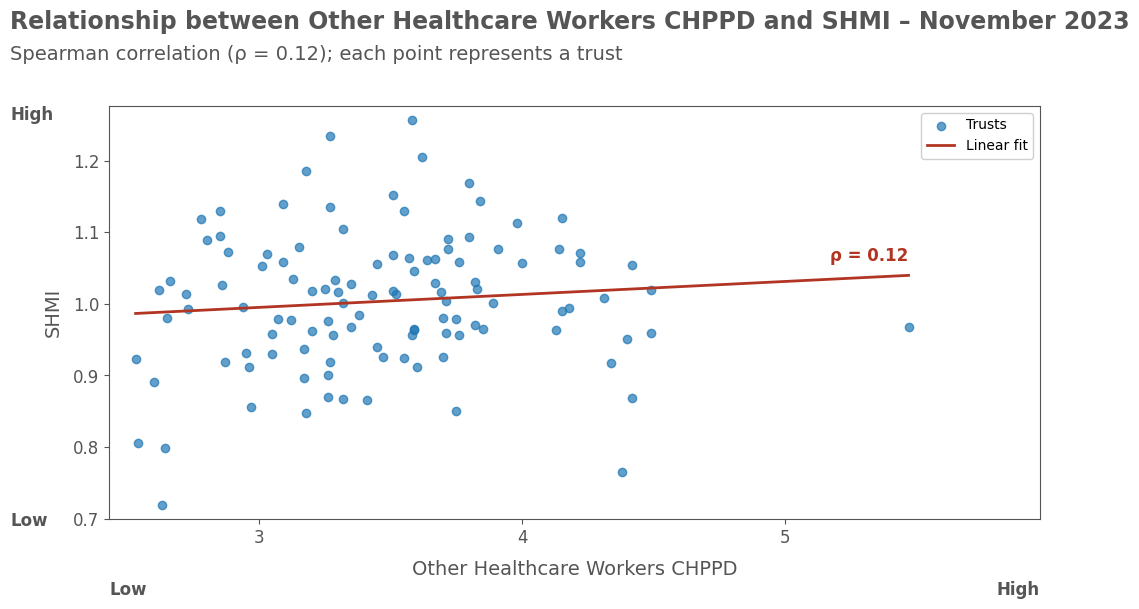

Processing month: 2023-12 (111 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2023_12.png


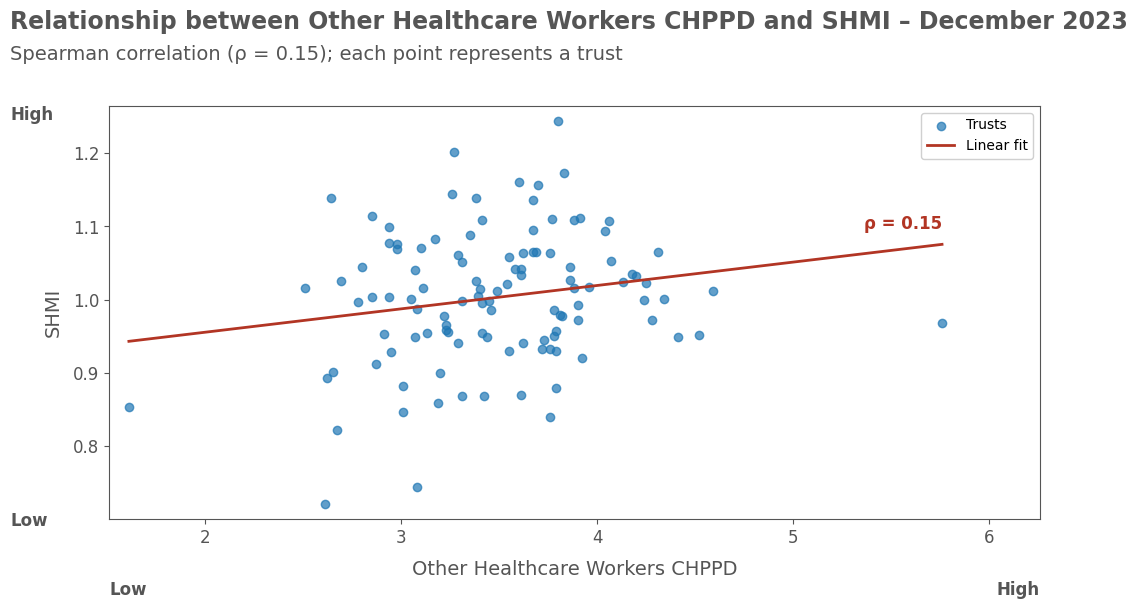

Processing month: 2024-01 (112 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_01.png


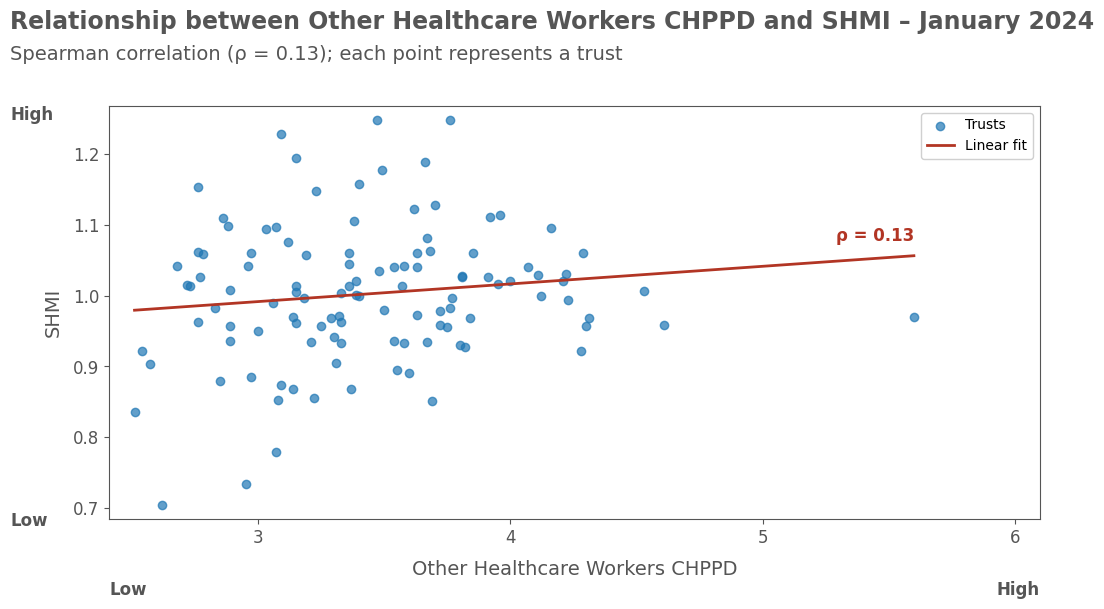

Processing month: 2024-02 (110 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_02.png


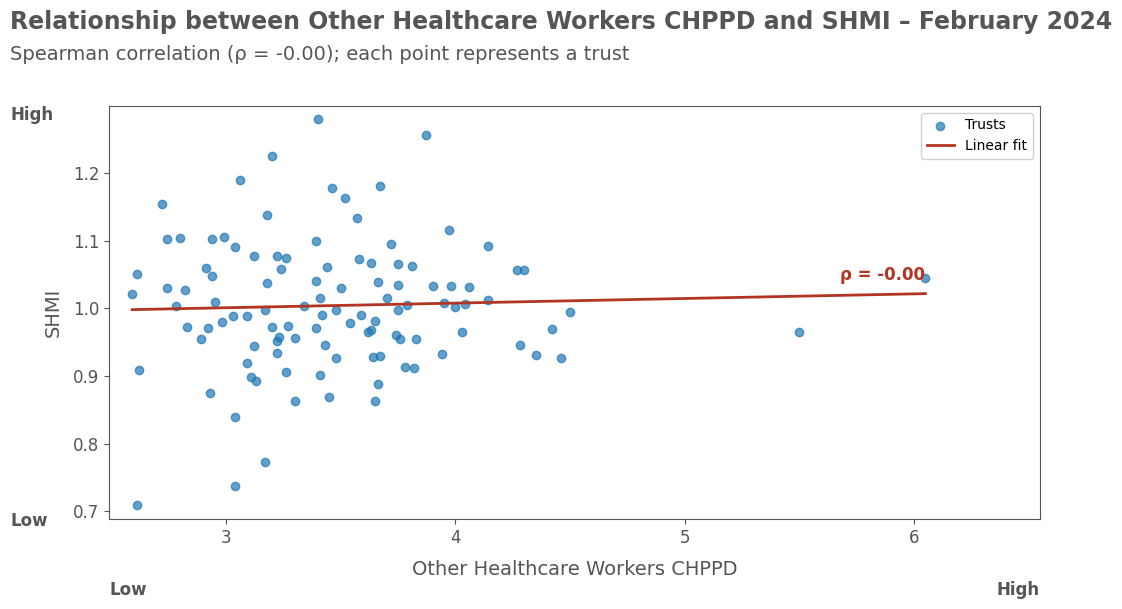

Processing month: 2024-03 (111 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_03.png


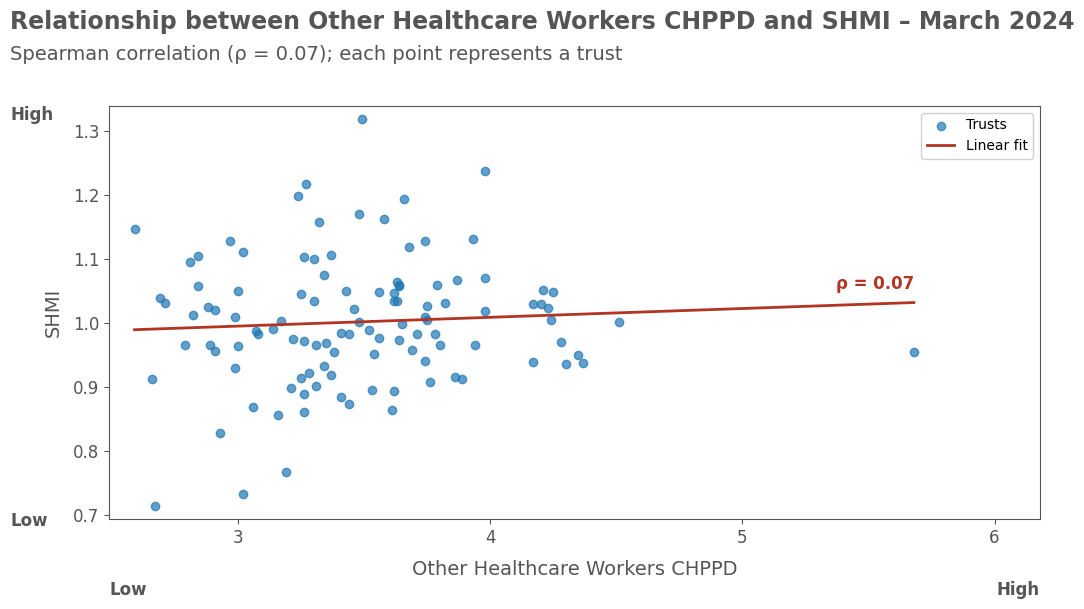

Processing month: 2024-04 (107 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_04.png


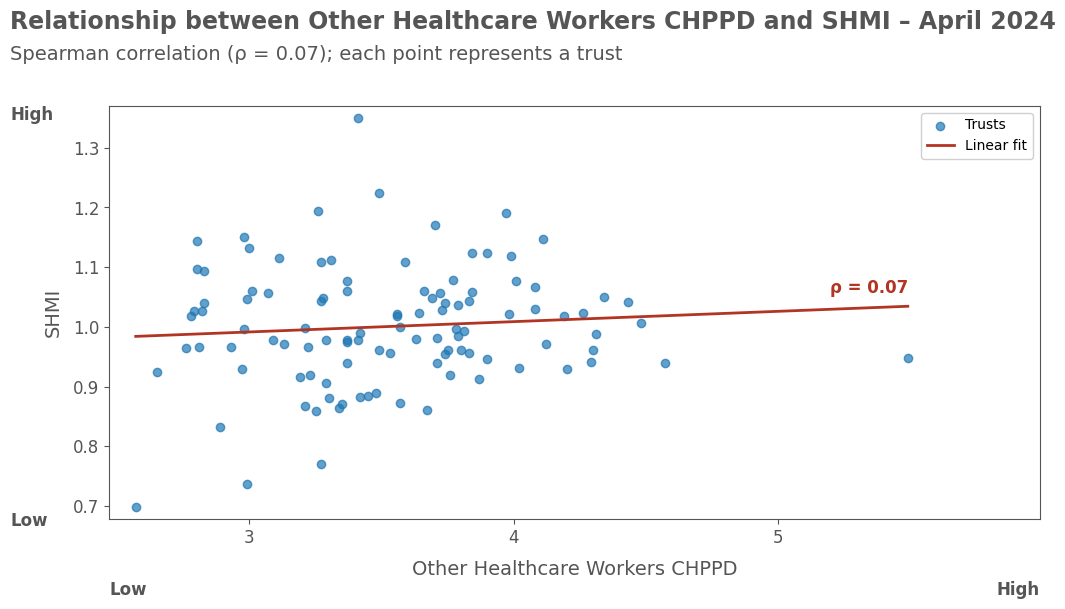

Processing month: 2024-05 (111 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_05.png


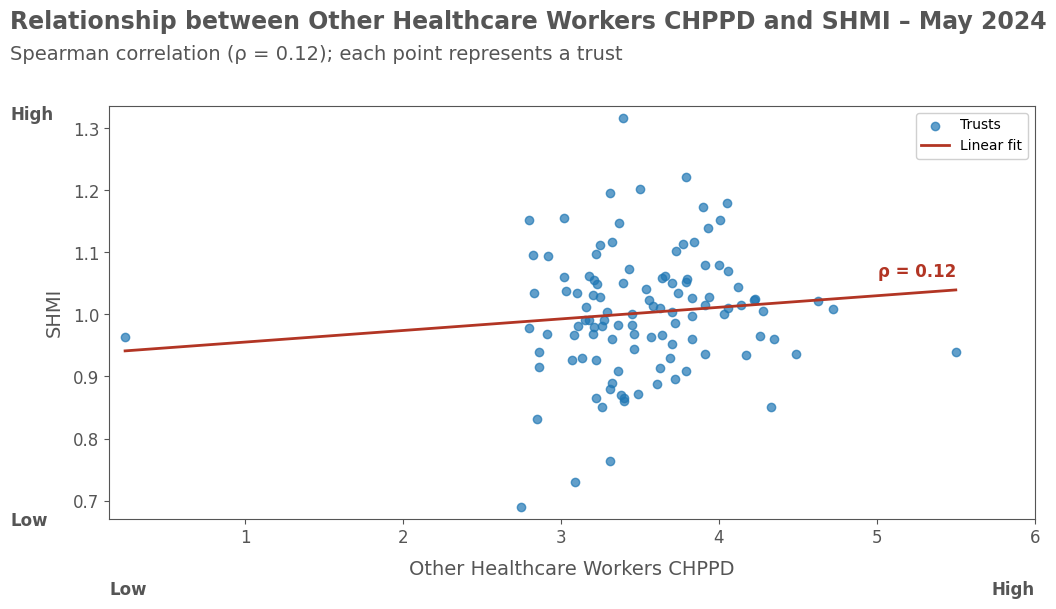

Processing month: 2024-06 (112 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_06.png


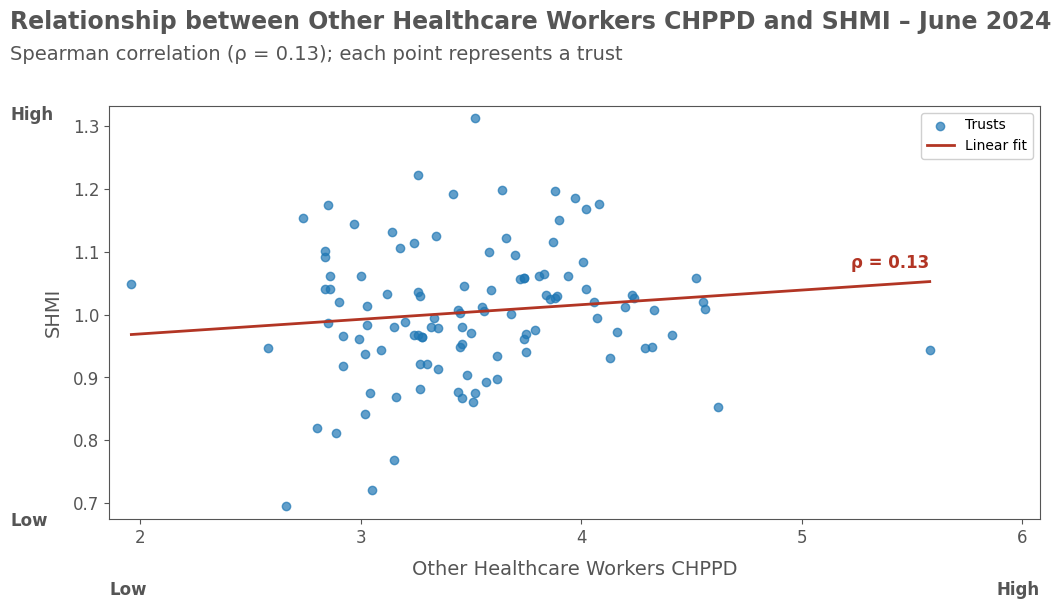

Processing month: 2024-07 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_07.png


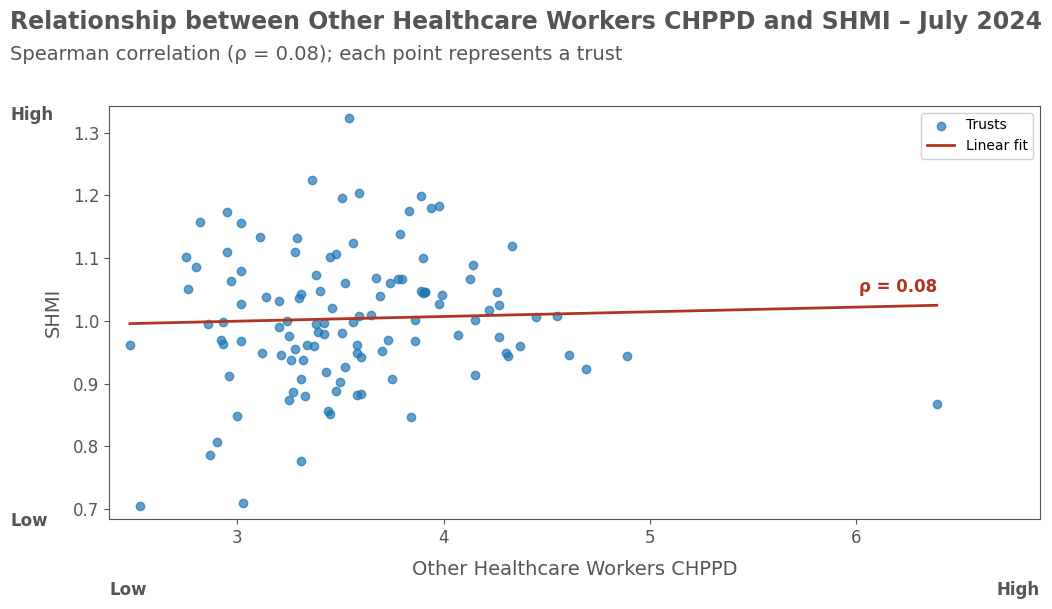

Processing month: 2024-08 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_08.png


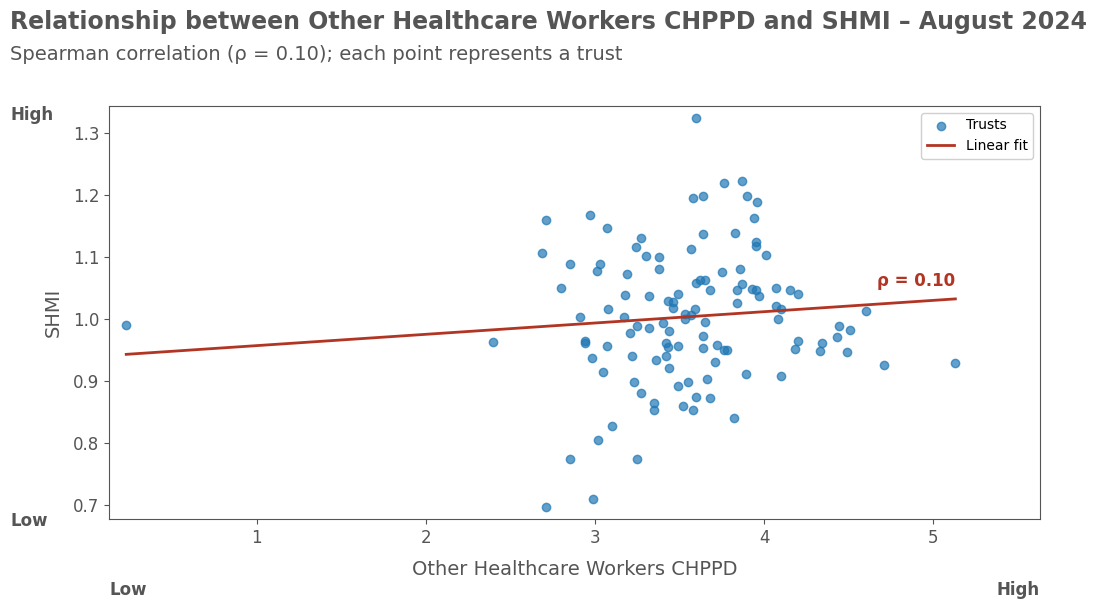

Processing month: 2024-09 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_09.png


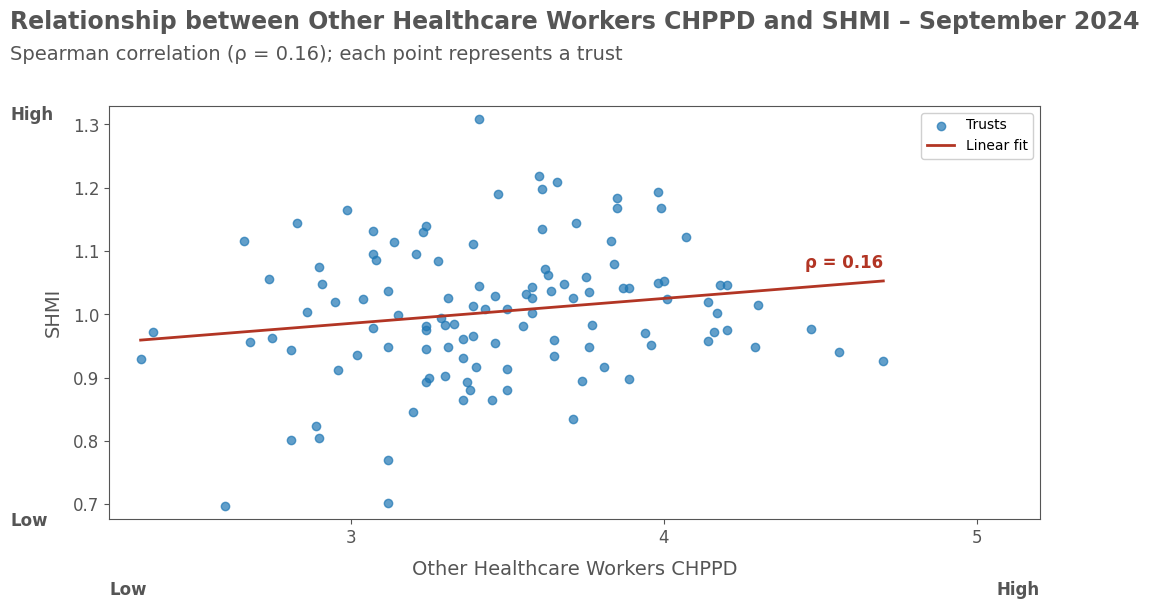

Processing month: 2024-10 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_10.png


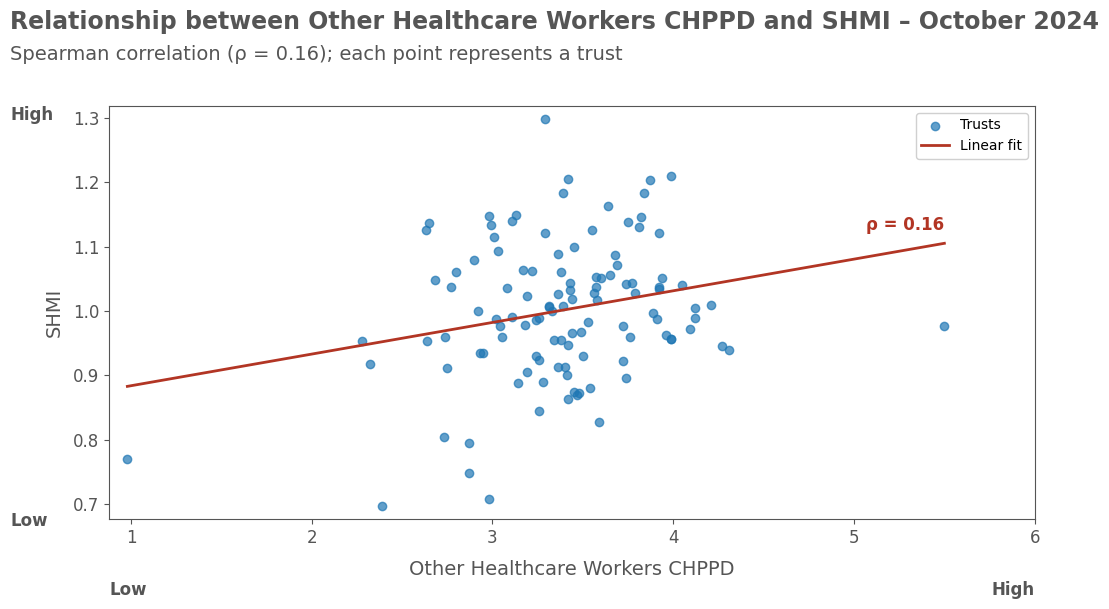

Processing month: 2024-11 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_11.png


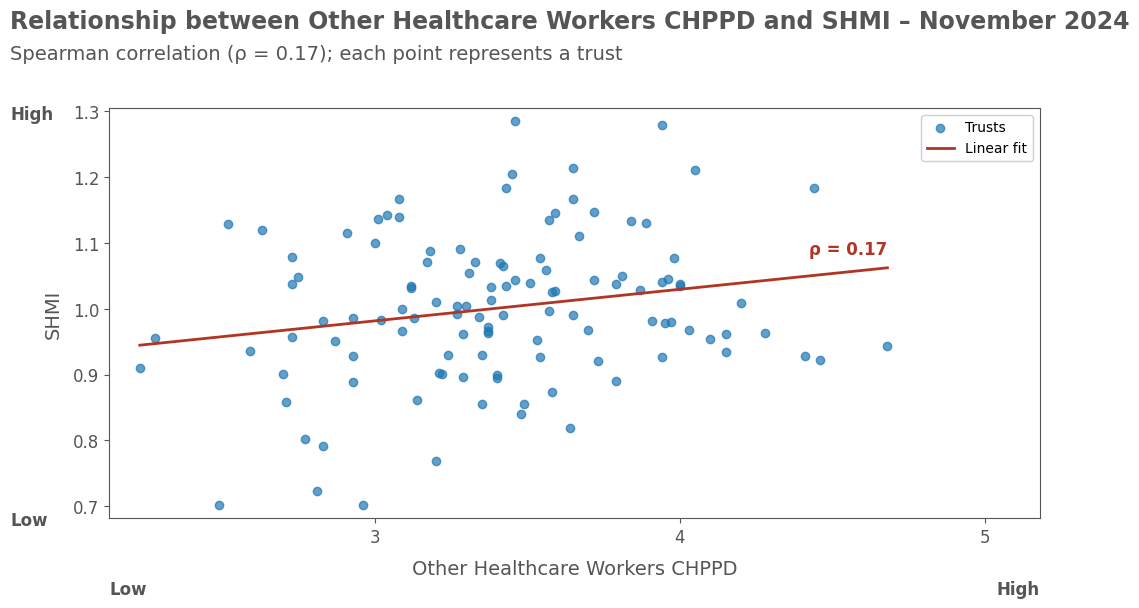

Processing month: 2024-12 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2024_12.png


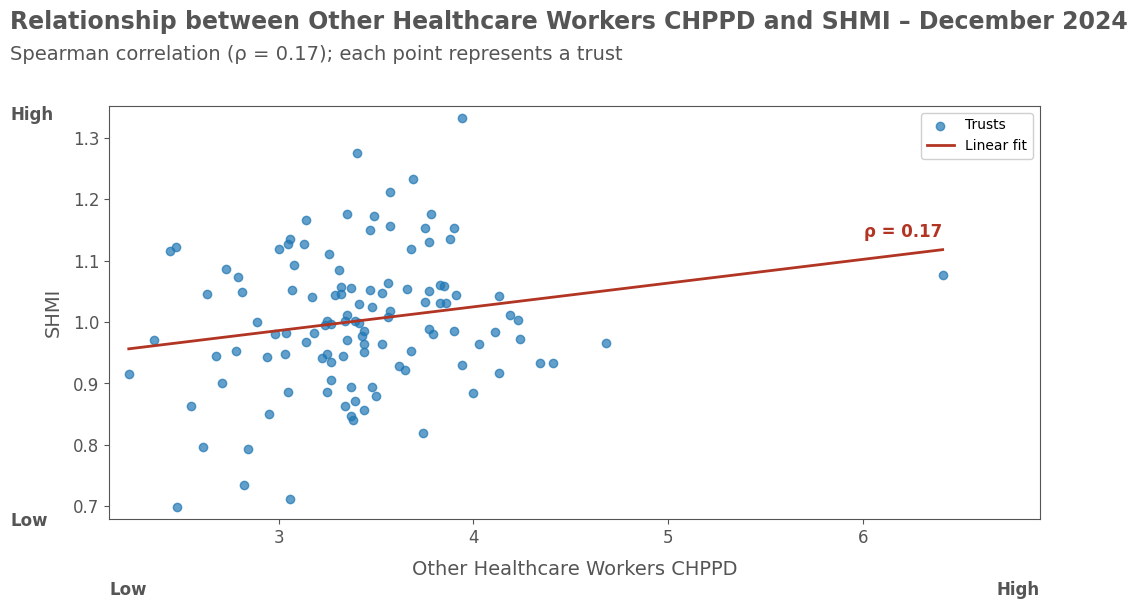

Processing month: 2025-01 (103 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2025_01.png


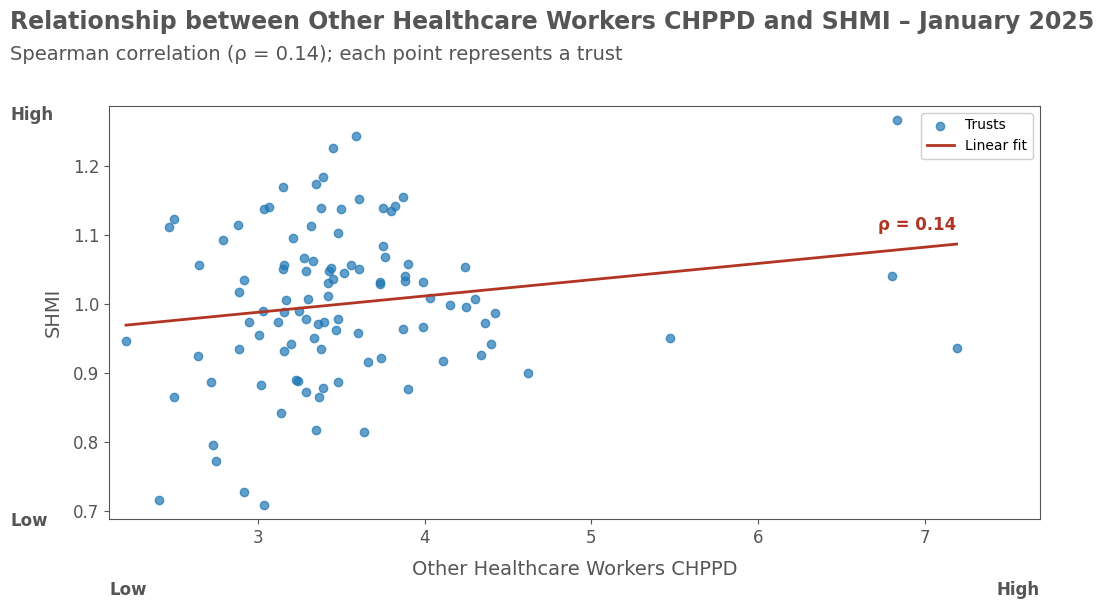

Processing month: 2025-02 (115 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2025_02.png


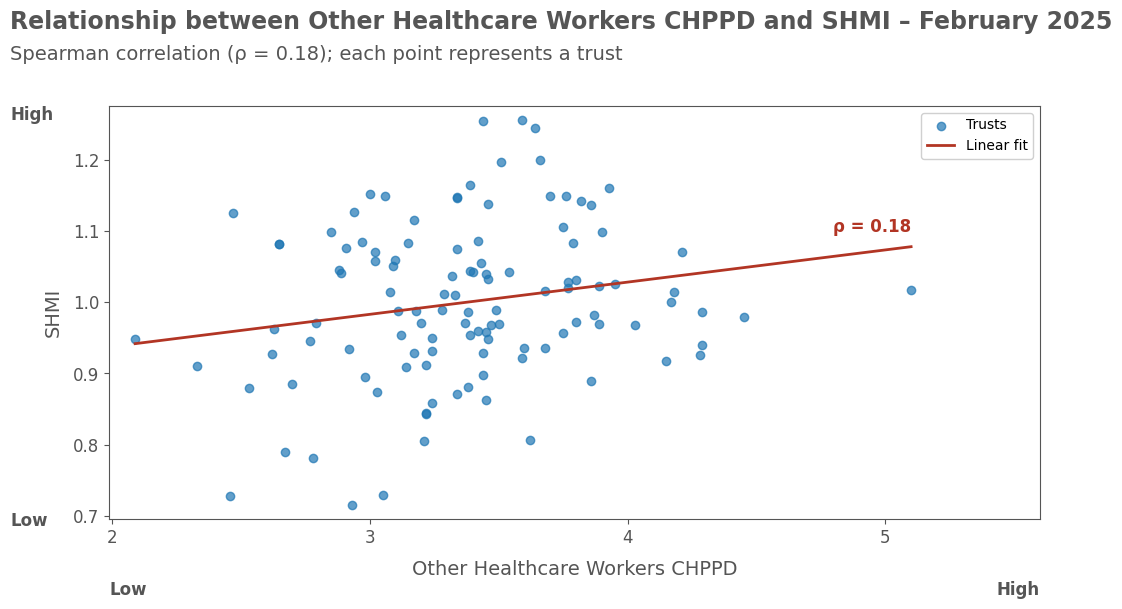

Processing month: 2025-03 (115 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2025_03.png


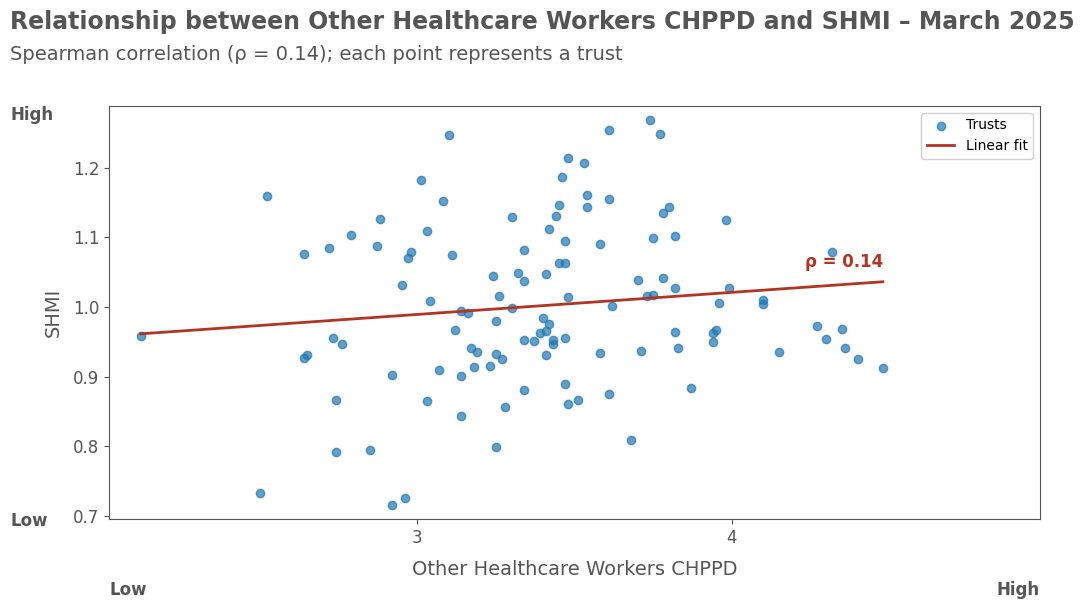

Processing month: 2025-04 (116 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2025_04.png


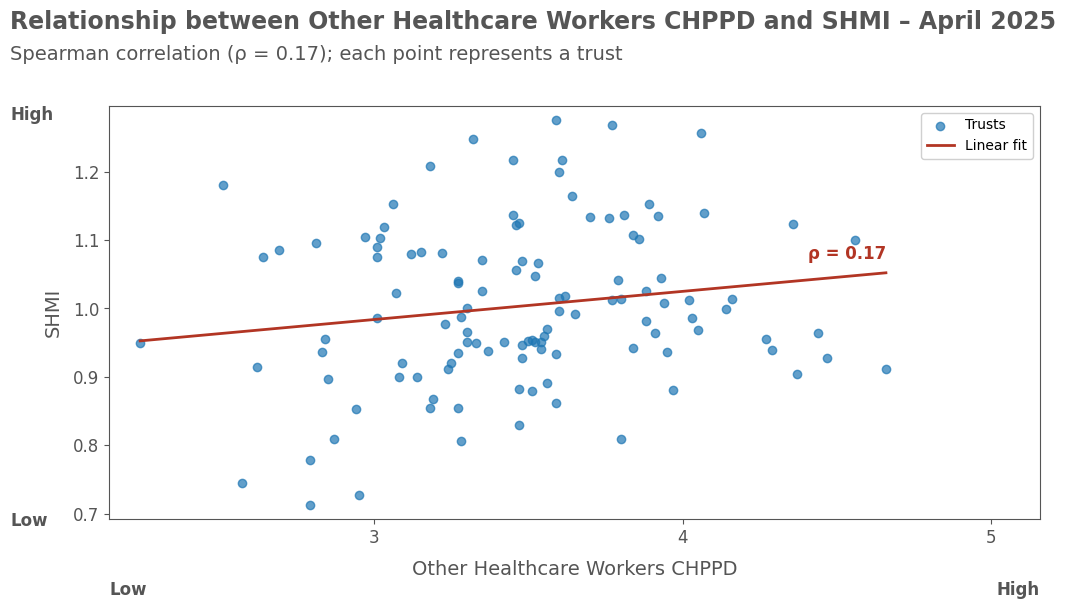

Processing month: 2025-05 (112 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2025_05.png


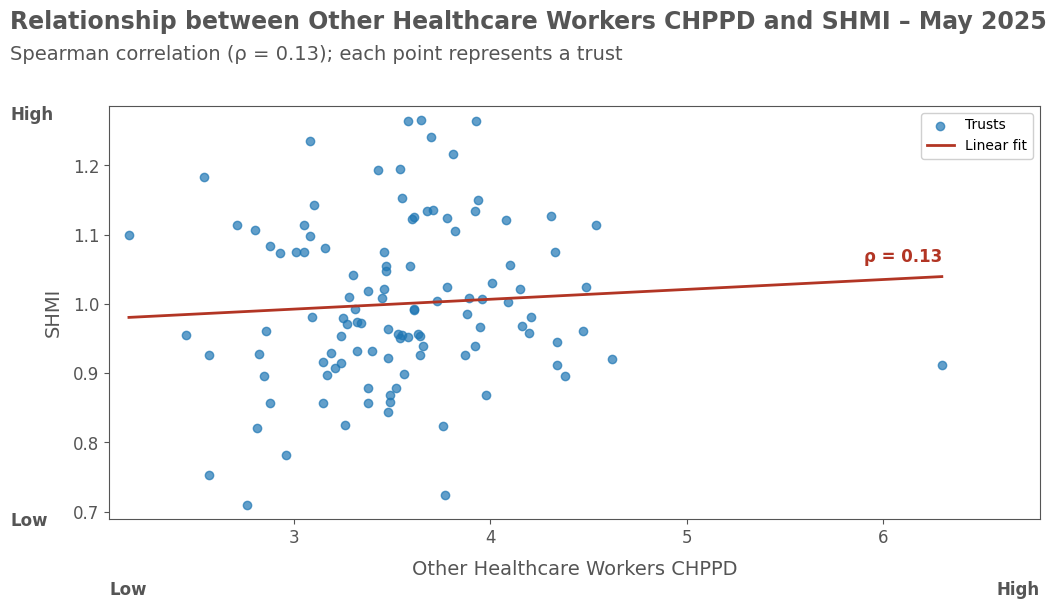

Processing month: 2025-06 (114 rows)
Saved to: /Users/e410675/Desktop/Plots/B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_2025_06.png


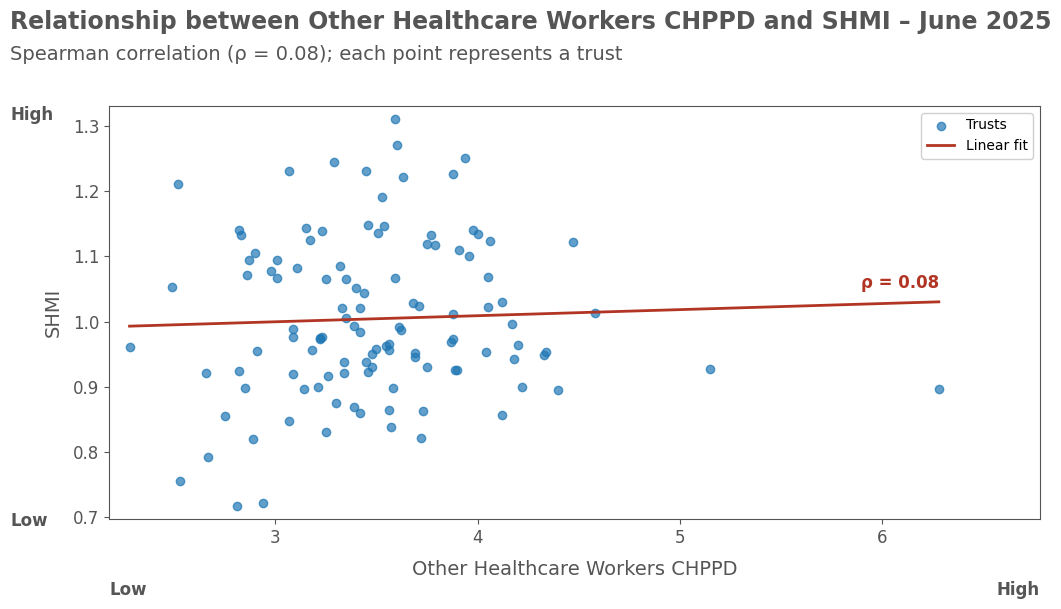

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os   # for saving
from scipy.stats import spearmanr
from matplotlib.ticker import MultipleLocator
import matplotlib.lines as mlines

# -----------------------------
# Styling constants (AfC-style)
# -----------------------------
YEAR_LABEL_GRAY = "#555555"

# -----------------------------
# Load and prepare the data
# -----------------------------
file_path = "chppd-smhi_merged filter with year month.csv"
df = pd.read_csv(file_path)

# Remove outliers where Overall CHPPD > 16 (same rule as other plot)
df_clean = df[df["CHPPD - Overall"] <= 16].copy()
removed_high = len(df) - len(df_clean)
print(f"Removed {removed_high} outlier rows with Overall CHPPD > 16.")

# Remove extreme low SHMI values (< 0.1)
before_shmi = len(df_clean)
df_clean = df_clean[df_clean["SHMI_VALUE"] >= 0.1].copy()
removed_low = before_shmi - len(df_clean)
print(f"Removed {removed_low} rows with SHMI < 0.1.")

df = df_clean.copy()

# Rename columns to simpler names
df = df.rename(columns={
    "Organisation Name": "org_name",
    "CHPPD - Overall": "overall_chppd",
    "CHPPD – Registered Nurses and Midwives": "rnmid_chppd",
    "Non-registered Nurses": "nonreg_chppd",
    "SHMI_VALUE": "shmi",
    "year_month": "date"
})

# Parse year_month as datetime (YYYY-MM)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

# Ensure output folder exists
os.makedirs(plot_save_path, exist_ok=True)

# -----------------------------
# LOOP FOR EACH MONTH IN DF
# -----------------------------
month_periods = sorted(df["date"].dt.to_period("M").unique())
print(f"Found {len(month_periods)} distinct months in the data.")

for period in month_periods:
    mask = (df["date"].dt.to_period("M") == period)
    df_latest = df[mask].copy()

    if df_latest.empty:
        continue
    if len(df_latest) < 2:
        print(f"Skipping {period} (only {len(df_latest)} row).")
        continue

    latest_date = df_latest["date"].iloc[0]
    print(
        f"Processing month: {latest_date.strftime('%Y-%m')} "
        f"({len(df_latest)} rows)"
    )

    # -----------------------------
    # Data for regression (Other Healthcare Workers)
    # -----------------------------
    x = df_latest["nonreg_chppd"].values
    y = df_latest["shmi"].values

    # Linear regression (still valid as a visual guide)
    m, b = np.polyfit(x, y, 1)

    # ===========================================
    # Spearman correlation
    # ===========================================
    rho_value, rho_p = spearmanr(x, y)

    # -----------------------------
    # Axis span
    # -----------------------------
    x_min_data = df_latest["nonreg_chppd"].min()
    x_max_data = df_latest["nonreg_chppd"].max()
    y_min_data = df_latest["shmi"].min()
    y_max_data = df_latest["shmi"].max()

    margin_x = 0.5
    margin_y = 0.02

    # -----------------------------
    # Plot
    # -----------------------------
    fig, ax = plt.subplots(figsize=(11, 7))
    fig.patch.set_facecolor("white")

    blue_color = "#1f77b4"
    red_color = "#b23524"

    all_scatter = ax.scatter(
        df_latest["nonreg_chppd"], df_latest["shmi"],
        alpha=0.7, color=blue_color, label="Trusts"
    )

    x_fit = np.linspace(x_min_data, x_max_data, 200)
    y_fit = m * x_fit + b

    reg_line, = ax.plot(
        x_fit, y_fit,
        linewidth=2,
        color=red_color,
        label="Linear fit"
    )

    # -----------------------------
    # ρ label at the end of the regression line
    # -----------------------------
    x_r = x_fit.max()
    y_r = m * x_r + b

    ax.text(
        x_r,
        y_r + 0.015,
        f"ρ = {rho_value:.2f}",
        color=red_color,
        fontsize=12,
        fontweight="bold",
        ha="right",
        va="bottom"
    )

    # -----------------------------
    # Axis limits
    # -----------------------------
    ax.set_xlim(x_min_data - 0.1, x_max_data + margin_x)
    ax.set_ylim(y_min_data - margin_y, y_max_data + margin_y)

    ax.set_xlabel(
        "Other Healthcare Workers CHPPD",
        color=YEAR_LABEL_GRAY, fontsize=14
    )
    ax.xaxis.set_label_coords(0.5, -0.10)
    ax.set_ylabel("")
    ax.tick_params(axis="x", labelsize=12, colors=YEAR_LABEL_GRAY)
    ax.tick_params(axis="y", labelsize=12, colors=YEAR_LABEL_GRAY)

    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))

    ax.grid(False)
    ax.minorticks_off()

    for side in ["top", "right", "left", "bottom"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color(YEAR_LABEL_GRAY)

    # -----------------------------
    # Titles
    # -----------------------------
    main_title = (
        f"Relationship between Other Healthcare Workers CHPPD and SHMI – "
        f"{latest_date.strftime('%B %Y')}"
    )

    subtitle = (
        f"Spearman correlation (ρ = {rho_value:.2f}); each point represents a trust"
    )

    fig.suptitle(
        main_title, x=0.03, y=0.96,
        ha="left", fontsize=17, fontweight="bold", color=YEAR_LABEL_GRAY
    )

    fig.text(
        0.03, 0.91, subtitle,
        ha="left", va="top", fontsize=14, color=YEAR_LABEL_GRAY
    )

    # Side labels
    fig.text(0.03, 0.81, "High", ha="left", va="center",
             fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY)
    fig.text(0.03, 0.23, "Low", ha="left", va="center",
             fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY)

    ax.text(
        -0.06, 0.5, "SHMI",
        transform=ax.transAxes,
        rotation=90, ha="center", va="center",
        fontsize=14, color=YEAR_LABEL_GRAY,
    )

    ax.text(
        0.0, -0.15, "Low",
        transform=ax.transAxes, ha="left", va="top",
        fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY,
    )
    ax.text(
        1.0, -0.15, "High",
        transform=ax.transAxes, ha="right", va="top",
        fontsize=12, fontweight="bold", color=YEAR_LABEL_GRAY,
    )

    # Legend
    ax.legend(
        handles=[all_scatter, reg_line],
        loc="upper right",
        frameon=True,
        facecolor="#FFFFFF",
        edgecolor="#d0d0d0",
        framealpha=1.0,
    )

    fig.subplots_adjust(left=0.10)
    plt.tight_layout(rect=[0.05, 0.07, 0.98, 0.9])

    # -----------------------------
    # Save plot (per month)
    # -----------------------------
    month_str = latest_date.strftime("%Y_%m")
    filename = f"B1_OtherHCW_CHPPD_SHMI_Scatter_Regression_Spearman_{month_str}.png"
    save_path = os.path.join(plot_save_path, filename)

    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    print(f"Saved to: {save_path}")

    plt.show(fig)
